# Part 3: Feature extraction
1. Peform a test/train split (include path, basename, sex, and emotion in y)
2. Create the appropriate files
 - Average features (averaged across time); extract y's for sex, emotion and a concatenation
 - Raw audio
 - 2D with both chroma and mel
 
 *This notebook should be run using the audio5.yml environment*

### Load libraries and data from Part 2

In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import os
import pickle
import wave

import librosa
import librosa.display
from IPython.display import Audio

import pydub

import seaborn as sns

from sklearn.model_selection import train_test_split

from scipy import stats

import itertools

In [2]:
# Load the dataframe from Part_2
df = pd.read_pickle('dataframes_and_dictionaries/concatenated_observations.pkl')

In [3]:
# Laod the dictionary of trimmed audio from Part_2
with open('dataframes_and_dictionaries/trimmed_audio_dict.pkl', 'rb') as handle:
   trimmed_audio_dict = pickle.load(handle)

## Create integer representations of the target columns
- We will convert emotion to a zero-indexed integer. We name this column y_emotion

Some research has suggested that adding additional categories to represent the combination of emotion and sex improves accuracy. We will prepare target variables for this as well.
- Convert sex to a zero-indexed integer. We name this column y_sex.
- Create a new column with combinations of sex and emotion named sex_emotion. Convert this to a zero-indexed integer named y_sex_emotion.

We begin by creating holding dictionary to contain dictionaries for interpreting each of the variables prefixed by 'y_' that were listed above.

#### Create a holding dictionary to contain dictionaries for interpreting each variable prefixed with 'y_'

In [4]:
# initialize a holding dictionary
target_var_dict = {}
# initialize an empty dictionary inside the holding dictionary for each target variable
target_var_dict['y_emotion'] = {}
target_var_dict['y_sex'] = {}
target_var_dict['y_sex_emotion'] = {}

#### For emotion, establish a dicitonary of integer keys and emotion values; create a y_emotion column

In [5]:
# get a list of emotions
emotion_list = list(df['emotion'].unique())
emotion_list

['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']

In [6]:
# Let's put neutral at the beginning
emotion_list.insert(0,emotion_list.pop(4))
emotion_list

['NEU', 'ANG', 'DIS', 'FEA', 'HAP', 'SAD']

In [7]:
# Let's put happy in the second position and sad in the third
emotion_list.insert(1,emotion_list.pop(4))
emotion_list.insert(2,emotion_list.pop(5))
emotion_list

['NEU', 'HAP', 'SAD', 'ANG', 'DIS', 'FEA']

In [8]:
# Let's add these emotions to our dictionary

# iterate over the positions in our emotion_list
for position in range(len(emotion_list)):
    # assign each position to be a key and list element at that position to be a value
    target_var_dict['y_emotion'][position] = emotion_list[position]
    
# look at the dictionary
target_var_dict['y_emotion']

{0: 'NEU', 1: 'HAP', 2: 'SAD', 3: 'ANG', 4: 'DIS', 5: 'FEA'}

In [9]:
# create a new column, y_emotion, by finding the position of each emotion in our emotion_list
df['y_emotion'] = df['emotion'].apply(lambda x: emotion_list.index(x))

In [10]:
# compare the emotion and y_emotion columns to confirm that our dicitonary will properly interpret values
df[['emotion','y_emotion']].sample(10)

,emotion,y_emotion
5786,DIS,4
3802,HAP,1
5778,SAD,2
3180,ANG,3
3380,HAP,1
271,NEU,0
4515,FEA,5
7173,DIS,4
6022,HAP,1
3668,HAP,1


#### For sex, establish a dicitonary of integer keys and sex values; create a y_sex column

In [11]:
# get a list of emotions
sex_list = list(df['sex'].unique())
sex_list

['male', 'female']

In [12]:
# Let's add the sex values to our dictionary

# iterate over the positions in our sex_list
for position in range(len(sex_list)):
    # assign each position to be a key and list element at that position to be a value
    target_var_dict['y_sex'][position] = sex_list[position]
    
# look at the dictionary
target_var_dict['y_sex']

{0: 'male', 1: 'female'}

In [13]:
# create a new column, y_sex, by finding the position of each sex in our sex_list
df['y_sex'] = df['sex'].apply(lambda x: sex_list.index(x))

In [14]:
# compare the emotion and y_emotion columns to confirm that our dicitonary will properly interpret values
df[['sex','y_sex']].sample(5)

,sex,y_sex
5435,male,0
4925,female,1
6880,male,0
2112,male,0
376,male,0


#### For combinations of sex and emotion, create new column; establish a dicitonary of integer keys and values; create a y_sex_emotion column

In [15]:
# create a new column with concatenated values
df['sex_emotion'] = df['sex'] + '-' + df['emotion']
# view the new column
df['sex_emotion'].sample(5)

7618      male-HAP
5175      male-ANG
4596      male-DIS
5112    female-DIS
7283      male-DIS
Name: sex_emotion, dtype: object

In [16]:
# create a new list with all the concatenated values

sex_emotion_list = []

# iterate over the positions in the emotion_list
for position in range(len(emotion_list)):
    # append the sex_emotion_list with 'female-' appended to the front of the emotion
    sex_emotion_list.append('female-' + emotion_list[position])
    
# iterate over the positions in the emotion_list
for position in range(len(emotion_list)):
    # append the sex_emotion_list with 'male-' appended to the front of the emotion
    sex_emotion_list.append('male-' + emotion_list[position])
    
sex_emotion_list    

['female-NEU',
 'female-HAP',
 'female-SAD',
 'female-ANG',
 'female-DIS',
 'female-FEA',
 'male-NEU',
 'male-HAP',
 'male-SAD',
 'male-ANG',
 'male-DIS',
 'male-FEA']

In [17]:
# Let's add these values to our dictionary

# iterate over the positions in our list
for position in range(len(sex_emotion_list)):
    # assign each position to be a key and list element at that position to be a value
    target_var_dict['y_sex_emotion'][position] = sex_emotion_list[position]
    
# look at the dictionary
target_var_dict['y_sex_emotion']

{0: 'female-NEU',
 1: 'female-HAP',
 2: 'female-SAD',
 3: 'female-ANG',
 4: 'female-DIS',
 5: 'female-FEA',
 6: 'male-NEU',
 7: 'male-HAP',
 8: 'male-SAD',
 9: 'male-ANG',
 10: 'male-DIS',
 11: 'male-FEA'}

In [18]:
# create a new column, y_sex_emotion, by finding the position of each value in our list
df['y_sex_emotion'] = df['sex_emotion'].apply(lambda x: sex_emotion_list.index(x))

In [19]:
# compare the emotion and y_emotion columns to confirm that our dicitonary will properly interpret values
df[['sex_emotion','y_sex_emotion']].sample(5)

,sex_emotion,y_sex_emotion
3249,male-ANG,9
6321,female-SAD,2
1763,male-FEA,11
6413,female-HAP,1
2592,male-SAD,8


## Perform test/train split
We will split up our data into train and test subsets.

For our features, we will include path and basename, as well as the extracted features.

For our target, we will include out three potential target variables in both integer form and string form. We will also include basename as an additional reference point for exploring misclassifications.


#### Split the data into features and targets
- The target dataframe includes emotion, sex and the sex_emotion concatenation as potential targets for use in modeling. Utimately, we only display results for emotion as the targete. Test runs with the other targets did not show any improvements in accuracy.
- the target dataframe includes both intergere values for classes as well as string values. Integer values for classes are used by the tensor flow model. The string values are used for intepretation of results.

In [20]:
# create feature and target dataframes
X = df.loc[:,['path', 'basename', 'tempo',
       'avg_zero_crossing_rate', 'avg_spectral_centroid',
       'avg_spectral_flatness', 'avg_spectral_rolloff',
       'avg_spectral_bandwidth']]
y = df.loc[:,['basename','emotion','sex','sex_emotion','y_emotion','y_sex','y_sex_emotion']]

#### Split the data into train and test subsets
- The split is done with stratification on a concatenation of sex and emotion. This ensures that original datasets balances across sex and balance across emotion are preserved in both the test and train subsets.
- While this method allows for a single actor to show up in both test and train; however, the actor will not be exhibiting the same emotion with the same sentence in both test and train sets.

In [21]:
# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17,
                                                    stratify=y['sex_emotion'])

#### Check the shapes of the split data

In [22]:
X_train.shape

(6792, 8)

In [23]:
X_test.shape

(1699, 8)

In [24]:
y_train.shape

(6792, 7)

In [25]:
y_test.shape

(1699, 7)

The shapes all look correct.

#### Pickle the y dataframes and intepretation dictionary for use in Part_4

In [26]:
y_train.to_pickle('extracted_features_for_modeling/y_train_pickled.pkl')
y_test.to_pickle('extracted_features_for_modeling/y_test_pickled.pkl')

In [27]:
# check if the read pickle is the same as the original
y_train.equals(pd.read_pickle('extracted_features_for_modeling/y_train_pickled.pkl'))

True

In [28]:
# check if the read pickle is the same as the original
y_test.equals(pd.read_pickle('extracted_features_for_modeling/y_test_pickled.pkl'))

True

In [29]:
with open('dataframes_and_dictionaries/target_var_dict.pkl', 'wb') as handle:
    pickle.dump(target_var_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Extract average features for dense neural network modeling

For our simplest model, a dense neural network, we will extract new summary features from the data:
- MFCCs averaged over time
- Chromas averaged over time
- Mels averaged over time

We will then also  include the original summary features that we extracted in Part 2:
- 'avg_zero_crossing_rate'
- 'avg_spectral_centroid'
- 'avg_spectral_flatness'
- 'avg_spectral_rolloff'
- 'avg_spectral_bandwidth'

#### Extract the new summary features from X_test and X_train

In [30]:
# define a function to extract all the features
def avg_features(df):
    '''
    take a dataframe that is a subset of the loaded dataframe, extract average features for mel, mfcc, and chroma,
    concatenate them, along with the original summary features, into a one-dimensional array, return a list of those arrays
    
    Input:
    ------
    a subset of the loaded dataframe, 'concatenated_observations.pkl', that includes the column 'basename'
    
    Return:
    -------
    a list containing one-dimensional arrays for each basename with extracted features averaged over time
    '''

    # initialize a counter to track progress
    counter = 0

    # initialize a list to hold the results
    results = []

    for i in df.index:
        # increment the progress counter
        counter += 1
        print(f'Loading file {counter} of {df.shape[0]} with index of {i}')

        # extract the basename for use as the dictionary's key
        key = df.loc[i,'basename']
        # extract the y and sr values from the dictionary
        y = trimmed_audio_dict[key]['y']
        sr = trimmed_audio_dict[key]['sr']
        
        # extract mfcc from the audio data
        print(f'Extracting MFCC for index {i}')
        mfcc_40 = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        # take the average of the mfcc's over the time axis
        mfcc_40_means = np.mean(mfcc_40.T, axis=0)
        
        # conduct a short term fourier transform
        print(f'Extracting chroma for index {i}')
        stft=np.abs(librosa.stft(y))
        # calculate the chroma
        chroma=librosa.feature.chroma_stft(S=stft, sr=sr)
        # take the average chroma over the time axis
        chroma_means=np.mean(chroma.T,axis=0)
    
        # extract the mel coefficients
        print(f'Extracting mels for index {i}')
        mel=librosa.feature.melspectrogram(y=y, sr=sr)
        # take the average chroma over the time axis
        mel_means=np.mean(mel.T,axis=0)
        
        #extract the original summary features
        print(f'Extracting original features for index {i}')
        original_features = df.loc[i,['tempo', 'avg_zero_crossing_rate', 'avg_spectral_centroid',
                                              'avg_spectral_flatness', 'avg_spectral_rolloff',
                                              'avg_spectral_bandwidth']].to_numpy()
        
        # stack the various means into a single one-dimensional array
        print('Stacking arrays')
        row = np.hstack([mfcc_40_means,chroma_means,mel_means,original_features])
        
        # append the extracted features for a single audio clip to the results list
        results.append(row)
    
    return results

In [31]:
%%time
X_test_new_summary_features = avg_features(X_test)

Loading file 1 of 1699 with index of 6105
Extracting MFCC for index 6105
Extracting chroma for index 6105
Extracting mels for index 6105
Extracting original features for index 6105
Stacking arrays
Loading file 2 of 1699 with index of 120
Extracting MFCC for index 120
Extracting chroma for index 120
Extracting mels for index 120
Extracting original features for index 120
Stacking arrays
Loading file 3 of 1699 with index of 2694
Extracting MFCC for index 2694
Extracting chroma for index 2694
Extracting mels for index 2694
Extracting original features for index 2694
Stacking arrays
Loading file 4 of 1699 with index of 7911
Extracting MFCC for index 7911
Extracting chroma for index 7911
Extracting mels for index 7911
Extracting original features for index 7911
Stacking arrays
Loading file 5 of 1699 with index of 3015
Extracting MFCC for index 3015
Extracting chroma for index 3015
Extracting mels for index 3015
Extracting original features for index 3015
Stacking arrays
Loading file 6 of 16

Extracting mels for index 5548
Extracting original features for index 5548
Stacking arrays
Loading file 47 of 1699 with index of 2870
Extracting MFCC for index 2870
Extracting chroma for index 2870
Extracting mels for index 2870
Extracting original features for index 2870
Stacking arrays
Loading file 48 of 1699 with index of 3368
Extracting MFCC for index 3368
Extracting chroma for index 3368
Extracting mels for index 3368
Extracting original features for index 3368
Stacking arrays
Loading file 49 of 1699 with index of 6095
Extracting MFCC for index 6095
Extracting chroma for index 6095
Extracting mels for index 6095
Extracting original features for index 6095
Stacking arrays
Loading file 50 of 1699 with index of 2044
Extracting MFCC for index 2044
Extracting chroma for index 2044
Extracting mels for index 2044
Extracting original features for index 2044
Stacking arrays
Loading file 51 of 1699 with index of 1136
Extracting MFCC for index 1136
Extracting chroma for index 1136
Extracting

Extracting mels for index 4022
Extracting original features for index 4022
Stacking arrays
Loading file 90 of 1699 with index of 7366
Extracting MFCC for index 7366
Extracting chroma for index 7366
Extracting mels for index 7366
Extracting original features for index 7366
Stacking arrays
Loading file 91 of 1699 with index of 4718
Extracting MFCC for index 4718
Extracting chroma for index 4718
Extracting mels for index 4718
Extracting original features for index 4718
Stacking arrays
Loading file 92 of 1699 with index of 1384
Extracting MFCC for index 1384
Extracting chroma for index 1384
Extracting mels for index 1384
Extracting original features for index 1384
Stacking arrays
Loading file 93 of 1699 with index of 1349
Extracting MFCC for index 1349
Extracting chroma for index 1349
Extracting mels for index 1349
Extracting original features for index 1349
Stacking arrays
Loading file 94 of 1699 with index of 8040
Extracting MFCC for index 8040
Extracting chroma for index 8040
Extracting

Extracting original features for index 3921
Stacking arrays
Loading file 134 of 1699 with index of 7795
Extracting MFCC for index 7795
Extracting chroma for index 7795
Extracting mels for index 7795
Extracting original features for index 7795
Stacking arrays
Loading file 135 of 1699 with index of 8266
Extracting MFCC for index 8266
Extracting chroma for index 8266
Extracting mels for index 8266
Extracting original features for index 8266
Stacking arrays
Loading file 136 of 1699 with index of 2607
Extracting MFCC for index 2607
Extracting chroma for index 2607
Extracting mels for index 2607
Extracting original features for index 2607
Stacking arrays
Loading file 137 of 1699 with index of 1344
Extracting MFCC for index 1344
Extracting chroma for index 1344
Extracting mels for index 1344
Extracting original features for index 1344
Stacking arrays
Loading file 138 of 1699 with index of 7854
Extracting MFCC for index 7854
Extracting chroma for index 7854
Extracting mels for index 7854
Extra

Extracting chroma for index 5213
Extracting mels for index 5213
Extracting original features for index 5213
Stacking arrays
Loading file 180 of 1699 with index of 1287
Extracting MFCC for index 1287
Extracting chroma for index 1287
Extracting mels for index 1287
Extracting original features for index 1287
Stacking arrays
Loading file 181 of 1699 with index of 4210
Extracting MFCC for index 4210
Extracting chroma for index 4210
Extracting mels for index 4210
Extracting original features for index 4210
Stacking arrays
Loading file 182 of 1699 with index of 2610
Extracting MFCC for index 2610
Extracting chroma for index 2610
Extracting mels for index 2610
Extracting original features for index 2610
Stacking arrays
Loading file 183 of 1699 with index of 8353
Extracting MFCC for index 8353
Extracting chroma for index 8353
Extracting mels for index 8353
Extracting original features for index 8353
Stacking arrays
Loading file 184 of 1699 with index of 693
Extracting MFCC for index 693
Extract

Extracting original features for index 3616
Stacking arrays
Loading file 225 of 1699 with index of 8039
Extracting MFCC for index 8039
Extracting chroma for index 8039
Extracting mels for index 8039
Extracting original features for index 8039
Stacking arrays
Loading file 226 of 1699 with index of 7564
Extracting MFCC for index 7564
Extracting chroma for index 7564
Extracting mels for index 7564
Extracting original features for index 7564
Stacking arrays
Loading file 227 of 1699 with index of 5690
Extracting MFCC for index 5690
Extracting chroma for index 5690
Extracting mels for index 5690
Extracting original features for index 5690
Stacking arrays
Loading file 228 of 1699 with index of 2317
Extracting MFCC for index 2317
Extracting chroma for index 2317
Extracting mels for index 2317
Extracting original features for index 2317
Stacking arrays
Loading file 229 of 1699 with index of 6296
Extracting MFCC for index 6296
Extracting chroma for index 6296
Extracting mels for index 6296
Extra

Extracting original features for index 7904
Stacking arrays
Loading file 269 of 1699 with index of 2236
Extracting MFCC for index 2236
Extracting chroma for index 2236
Extracting mels for index 2236
Extracting original features for index 2236
Stacking arrays
Loading file 270 of 1699 with index of 6666
Extracting MFCC for index 6666
Extracting chroma for index 6666
Extracting mels for index 6666
Extracting original features for index 6666
Stacking arrays
Loading file 271 of 1699 with index of 3712
Extracting MFCC for index 3712
Extracting chroma for index 3712
Extracting mels for index 3712
Extracting original features for index 3712
Stacking arrays
Loading file 272 of 1699 with index of 5653
Extracting MFCC for index 5653
Extracting chroma for index 5653
Extracting mels for index 5653
Extracting original features for index 5653
Stacking arrays
Loading file 273 of 1699 with index of 7116
Extracting MFCC for index 7116
Extracting chroma for index 7116
Extracting mels for index 7116
Extra

Extracting chroma for index 4502
Extracting mels for index 4502
Extracting original features for index 4502
Stacking arrays
Loading file 312 of 1699 with index of 5570
Extracting MFCC for index 5570
Extracting chroma for index 5570
Extracting mels for index 5570
Extracting original features for index 5570
Stacking arrays
Loading file 313 of 1699 with index of 2632
Extracting MFCC for index 2632
Extracting chroma for index 2632
Extracting mels for index 2632
Extracting original features for index 2632
Stacking arrays
Loading file 314 of 1699 with index of 4834
Extracting MFCC for index 4834
Extracting chroma for index 4834
Extracting mels for index 4834
Extracting original features for index 4834
Stacking arrays
Loading file 315 of 1699 with index of 4276
Extracting MFCC for index 4276
Extracting chroma for index 4276
Extracting mels for index 4276
Extracting original features for index 4276
Stacking arrays
Loading file 316 of 1699 with index of 2037
Extracting MFCC for index 2037
Extra

Extracting chroma for index 2131
Extracting mels for index 2131
Extracting original features for index 2131
Stacking arrays
Loading file 356 of 1699 with index of 6014
Extracting MFCC for index 6014
Extracting chroma for index 6014
Extracting mels for index 6014
Extracting original features for index 6014
Stacking arrays
Loading file 357 of 1699 with index of 6616
Extracting MFCC for index 6616
Extracting chroma for index 6616
Extracting mels for index 6616
Extracting original features for index 6616
Stacking arrays
Loading file 358 of 1699 with index of 105
Extracting MFCC for index 105
Extracting chroma for index 105
Extracting mels for index 105
Extracting original features for index 105
Stacking arrays
Loading file 359 of 1699 with index of 7320
Extracting MFCC for index 7320
Extracting chroma for index 7320
Extracting mels for index 7320
Extracting original features for index 7320
Stacking arrays
Loading file 360 of 1699 with index of 5182
Extracting MFCC for index 5182
Extracting

Extracting chroma for index 5519
Extracting mels for index 5519
Extracting original features for index 5519
Stacking arrays
Loading file 399 of 1699 with index of 561
Extracting MFCC for index 561
Extracting chroma for index 561
Extracting mels for index 561
Extracting original features for index 561
Stacking arrays
Loading file 400 of 1699 with index of 51
Extracting MFCC for index 51
Extracting chroma for index 51
Extracting mels for index 51
Extracting original features for index 51
Stacking arrays
Loading file 401 of 1699 with index of 1740
Extracting MFCC for index 1740
Extracting chroma for index 1740
Extracting mels for index 1740
Extracting original features for index 1740
Stacking arrays
Loading file 402 of 1699 with index of 3254
Extracting MFCC for index 3254
Extracting chroma for index 3254
Extracting mels for index 3254
Extracting original features for index 3254
Stacking arrays
Loading file 403 of 1699 with index of 1129
Extracting MFCC for index 1129
Extracting chroma fo

Extracting chroma for index 4561
Extracting mels for index 4561
Extracting original features for index 4561
Stacking arrays
Loading file 441 of 1699 with index of 5857
Extracting MFCC for index 5857
Extracting chroma for index 5857
Extracting mels for index 5857
Extracting original features for index 5857
Stacking arrays
Loading file 442 of 1699 with index of 1316
Extracting MFCC for index 1316
Extracting chroma for index 1316
Extracting mels for index 1316
Extracting original features for index 1316
Stacking arrays
Loading file 443 of 1699 with index of 265
Extracting MFCC for index 265
Extracting chroma for index 265
Extracting mels for index 265
Extracting original features for index 265
Stacking arrays
Loading file 444 of 1699 with index of 232
Extracting MFCC for index 232
Extracting chroma for index 232
Extracting mels for index 232
Extracting original features for index 232
Stacking arrays
Loading file 445 of 1699 with index of 4660
Extracting MFCC for index 4660
Extracting chro

Extracting mels for index 2520
Extracting original features for index 2520
Stacking arrays
Loading file 486 of 1699 with index of 6322
Extracting MFCC for index 6322
Extracting chroma for index 6322
Extracting mels for index 6322
Extracting original features for index 6322
Stacking arrays
Loading file 487 of 1699 with index of 3958
Extracting MFCC for index 3958
Extracting chroma for index 3958
Extracting mels for index 3958
Extracting original features for index 3958
Stacking arrays
Loading file 488 of 1699 with index of 5358
Extracting MFCC for index 5358
Extracting chroma for index 5358
Extracting mels for index 5358
Extracting original features for index 5358
Stacking arrays
Loading file 489 of 1699 with index of 2291
Extracting MFCC for index 2291
Extracting chroma for index 2291
Extracting mels for index 2291
Extracting original features for index 2291
Stacking arrays
Loading file 490 of 1699 with index of 7632
Extracting MFCC for index 7632
Extracting chroma for index 7632
Extra

Extracting chroma for index 7533
Extracting mels for index 7533
Extracting original features for index 7533
Stacking arrays
Loading file 530 of 1699 with index of 1827
Extracting MFCC for index 1827
Extracting chroma for index 1827
Extracting mels for index 1827
Extracting original features for index 1827
Stacking arrays
Loading file 531 of 1699 with index of 3110
Extracting MFCC for index 3110
Extracting chroma for index 3110
Extracting mels for index 3110
Extracting original features for index 3110
Stacking arrays
Loading file 532 of 1699 with index of 5614
Extracting MFCC for index 5614
Extracting chroma for index 5614
Extracting mels for index 5614
Extracting original features for index 5614
Stacking arrays
Loading file 533 of 1699 with index of 3691
Extracting MFCC for index 3691
Extracting chroma for index 3691
Extracting mels for index 3691
Extracting original features for index 3691
Stacking arrays
Loading file 534 of 1699 with index of 4815
Extracting MFCC for index 4815
Extra

Extracting chroma for index 5312
Extracting mels for index 5312
Extracting original features for index 5312
Stacking arrays
Loading file 579 of 1699 with index of 716
Extracting MFCC for index 716
Extracting chroma for index 716
Extracting mels for index 716
Extracting original features for index 716
Stacking arrays
Loading file 580 of 1699 with index of 4785
Extracting MFCC for index 4785
Extracting chroma for index 4785
Extracting mels for index 4785
Extracting original features for index 4785
Stacking arrays
Loading file 581 of 1699 with index of 4029
Extracting MFCC for index 4029
Extracting chroma for index 4029
Extracting mels for index 4029
Extracting original features for index 4029
Stacking arrays
Loading file 582 of 1699 with index of 1128
Extracting MFCC for index 1128
Extracting chroma for index 1128
Extracting mels for index 1128
Extracting original features for index 1128
Stacking arrays
Loading file 583 of 1699 with index of 6917
Extracting MFCC for index 6917
Extracting

Extracting chroma for index 5025
Extracting mels for index 5025
Extracting original features for index 5025
Stacking arrays
Loading file 622 of 1699 with index of 6565
Extracting MFCC for index 6565
Extracting chroma for index 6565
Extracting mels for index 6565
Extracting original features for index 6565
Stacking arrays
Loading file 623 of 1699 with index of 8281
Extracting MFCC for index 8281
Extracting chroma for index 8281
Extracting mels for index 8281
Extracting original features for index 8281
Stacking arrays
Loading file 624 of 1699 with index of 3309
Extracting MFCC for index 3309
Extracting chroma for index 3309
Extracting mels for index 3309
Extracting original features for index 3309
Stacking arrays
Loading file 625 of 1699 with index of 7312
Extracting MFCC for index 7312
Extracting chroma for index 7312
Extracting mels for index 7312
Extracting original features for index 7312
Stacking arrays
Loading file 626 of 1699 with index of 7083
Extracting MFCC for index 7083
Extra

Extracting original features for index 2752
Stacking arrays
Loading file 665 of 1699 with index of 708
Extracting MFCC for index 708
Extracting chroma for index 708
Extracting mels for index 708
Extracting original features for index 708
Stacking arrays
Loading file 666 of 1699 with index of 6798
Extracting MFCC for index 6798
Extracting chroma for index 6798
Extracting mels for index 6798
Extracting original features for index 6798
Stacking arrays
Loading file 667 of 1699 with index of 1164
Extracting MFCC for index 1164
Extracting chroma for index 1164
Extracting mels for index 1164
Extracting original features for index 1164
Stacking arrays
Loading file 668 of 1699 with index of 7697
Extracting MFCC for index 7697
Extracting chroma for index 7697
Extracting mels for index 7697
Extracting original features for index 7697
Stacking arrays
Loading file 669 of 1699 with index of 7887
Extracting MFCC for index 7887
Extracting chroma for index 7887
Extracting mels for index 7887
Extracting

Extracting mels for index 960
Extracting original features for index 960
Stacking arrays
Loading file 712 of 1699 with index of 2942
Extracting MFCC for index 2942
Extracting chroma for index 2942
Extracting mels for index 2942
Extracting original features for index 2942
Stacking arrays
Loading file 713 of 1699 with index of 7499
Extracting MFCC for index 7499
Extracting chroma for index 7499
Extracting mels for index 7499
Extracting original features for index 7499
Stacking arrays
Loading file 714 of 1699 with index of 7439
Extracting MFCC for index 7439
Extracting chroma for index 7439
Extracting mels for index 7439
Extracting original features for index 7439
Stacking arrays
Loading file 715 of 1699 with index of 2523
Extracting MFCC for index 2523
Extracting chroma for index 2523
Extracting mels for index 2523
Extracting original features for index 2523
Stacking arrays
Loading file 716 of 1699 with index of 482
Extracting MFCC for index 482
Extracting chroma for index 482
Extracting

Extracting chroma for index 6021
Extracting mels for index 6021
Extracting original features for index 6021
Stacking arrays
Loading file 761 of 1699 with index of 4071
Extracting MFCC for index 4071
Extracting chroma for index 4071
Extracting mels for index 4071
Extracting original features for index 4071
Stacking arrays
Loading file 762 of 1699 with index of 1367
Extracting MFCC for index 1367
Extracting chroma for index 1367
Extracting mels for index 1367
Extracting original features for index 1367
Stacking arrays
Loading file 763 of 1699 with index of 5659
Extracting MFCC for index 5659
Extracting chroma for index 5659
Extracting mels for index 5659
Extracting original features for index 5659
Stacking arrays
Loading file 764 of 1699 with index of 3105
Extracting MFCC for index 3105
Extracting chroma for index 3105
Extracting mels for index 3105
Extracting original features for index 3105
Stacking arrays
Loading file 765 of 1699 with index of 3069
Extracting MFCC for index 3069
Extra

Extracting mels for index 6256
Extracting original features for index 6256
Stacking arrays
Loading file 805 of 1699 with index of 2183
Extracting MFCC for index 2183
Extracting chroma for index 2183
Extracting mels for index 2183
Extracting original features for index 2183
Stacking arrays
Loading file 806 of 1699 with index of 2122
Extracting MFCC for index 2122
Extracting chroma for index 2122
Extracting mels for index 2122
Extracting original features for index 2122
Stacking arrays
Loading file 807 of 1699 with index of 242
Extracting MFCC for index 242
Extracting chroma for index 242
Extracting mels for index 242
Extracting original features for index 242
Stacking arrays
Loading file 808 of 1699 with index of 3607
Extracting MFCC for index 3607
Extracting chroma for index 3607
Extracting mels for index 3607
Extracting original features for index 3607
Stacking arrays
Loading file 809 of 1699 with index of 7251
Extracting MFCC for index 7251
Extracting chroma for index 7251
Extracting

Extracting chroma for index 7241
Extracting mels for index 7241
Extracting original features for index 7241
Stacking arrays
Loading file 847 of 1699 with index of 7095
Extracting MFCC for index 7095
Extracting chroma for index 7095
Extracting mels for index 7095
Extracting original features for index 7095
Stacking arrays
Loading file 848 of 1699 with index of 6085
Extracting MFCC for index 6085
Extracting chroma for index 6085
Extracting mels for index 6085
Extracting original features for index 6085
Stacking arrays
Loading file 849 of 1699 with index of 2491
Extracting MFCC for index 2491
Extracting chroma for index 2491
Extracting mels for index 2491
Extracting original features for index 2491
Stacking arrays
Loading file 850 of 1699 with index of 1586
Extracting MFCC for index 1586
Extracting chroma for index 1586
Extracting mels for index 1586
Extracting original features for index 1586
Stacking arrays
Loading file 851 of 1699 with index of 630
Extracting MFCC for index 630
Extract

Extracting chroma for index 457
Extracting mels for index 457
Extracting original features for index 457
Stacking arrays
Loading file 892 of 1699 with index of 5652
Extracting MFCC for index 5652
Extracting chroma for index 5652
Extracting mels for index 5652
Extracting original features for index 5652
Stacking arrays
Loading file 893 of 1699 with index of 6118
Extracting MFCC for index 6118
Extracting chroma for index 6118
Extracting mels for index 6118
Extracting original features for index 6118
Stacking arrays
Loading file 894 of 1699 with index of 2875
Extracting MFCC for index 2875
Extracting chroma for index 2875
Extracting mels for index 2875
Extracting original features for index 2875
Stacking arrays
Loading file 895 of 1699 with index of 2102
Extracting MFCC for index 2102
Extracting chroma for index 2102
Extracting mels for index 2102
Extracting original features for index 2102
Stacking arrays
Loading file 896 of 1699 with index of 225
Extracting MFCC for index 225
Extracting

Extracting chroma for index 8430
Extracting mels for index 8430
Extracting original features for index 8430
Stacking arrays
Loading file 937 of 1699 with index of 8185
Extracting MFCC for index 8185
Extracting chroma for index 8185
Extracting mels for index 8185
Extracting original features for index 8185
Stacking arrays
Loading file 938 of 1699 with index of 474
Extracting MFCC for index 474
Extracting chroma for index 474
Extracting mels for index 474
Extracting original features for index 474
Stacking arrays
Loading file 939 of 1699 with index of 5721
Extracting MFCC for index 5721
Extracting chroma for index 5721
Extracting mels for index 5721
Extracting original features for index 5721
Stacking arrays
Loading file 940 of 1699 with index of 2045
Extracting MFCC for index 2045
Extracting chroma for index 2045
Extracting mels for index 2045
Extracting original features for index 2045
Stacking arrays
Loading file 941 of 1699 with index of 3246
Extracting MFCC for index 3246
Extracting

Extracting mels for index 404
Extracting original features for index 404
Stacking arrays
Loading file 979 of 1699 with index of 2736
Extracting MFCC for index 2736
Extracting chroma for index 2736
Extracting mels for index 2736
Extracting original features for index 2736
Stacking arrays
Loading file 980 of 1699 with index of 3718
Extracting MFCC for index 3718
Extracting chroma for index 3718
Extracting mels for index 3718
Extracting original features for index 3718
Stacking arrays
Loading file 981 of 1699 with index of 2421
Extracting MFCC for index 2421
Extracting chroma for index 2421
Extracting mels for index 2421
Extracting original features for index 2421
Stacking arrays
Loading file 982 of 1699 with index of 865
Extracting MFCC for index 865
Extracting chroma for index 865
Extracting mels for index 865
Extracting original features for index 865
Stacking arrays
Loading file 983 of 1699 with index of 1500
Extracting MFCC for index 1500
Extracting chroma for index 1500
Extracting m

Extracting original features for index 6265
Stacking arrays
Loading file 1024 of 1699 with index of 8362
Extracting MFCC for index 8362
Extracting chroma for index 8362
Extracting mels for index 8362
Extracting original features for index 8362
Stacking arrays
Loading file 1025 of 1699 with index of 2191
Extracting MFCC for index 2191
Extracting chroma for index 2191
Extracting mels for index 2191
Extracting original features for index 2191
Stacking arrays
Loading file 1026 of 1699 with index of 5141
Extracting MFCC for index 5141
Extracting chroma for index 5141
Extracting mels for index 5141
Extracting original features for index 5141
Stacking arrays
Loading file 1027 of 1699 with index of 6938
Extracting MFCC for index 6938
Extracting chroma for index 6938
Extracting mels for index 6938
Extracting original features for index 6938
Stacking arrays
Loading file 1028 of 1699 with index of 7334
Extracting MFCC for index 7334
Extracting chroma for index 7334
Extracting mels for index 7334


Extracting chroma for index 469
Extracting mels for index 469
Extracting original features for index 469
Stacking arrays
Loading file 1068 of 1699 with index of 8367
Extracting MFCC for index 8367
Extracting chroma for index 8367
Extracting mels for index 8367
Extracting original features for index 8367
Stacking arrays
Loading file 1069 of 1699 with index of 3376
Extracting MFCC for index 3376
Extracting chroma for index 3376
Extracting mels for index 3376
Extracting original features for index 3376
Stacking arrays
Loading file 1070 of 1699 with index of 7542
Extracting MFCC for index 7542
Extracting chroma for index 7542
Extracting mels for index 7542
Extracting original features for index 7542
Stacking arrays
Loading file 1071 of 1699 with index of 138
Extracting MFCC for index 138
Extracting chroma for index 138
Extracting mels for index 138
Extracting original features for index 138
Stacking arrays
Loading file 1072 of 1699 with index of 7260
Extracting MFCC for index 7260
Extracti

Extracting chroma for index 4476
Extracting mels for index 4476
Extracting original features for index 4476
Stacking arrays
Loading file 1112 of 1699 with index of 1276
Extracting MFCC for index 1276
Extracting chroma for index 1276
Extracting mels for index 1276
Extracting original features for index 1276
Stacking arrays
Loading file 1113 of 1699 with index of 7482
Extracting MFCC for index 7482
Extracting chroma for index 7482
Extracting mels for index 7482
Extracting original features for index 7482
Stacking arrays
Loading file 1114 of 1699 with index of 4894
Extracting MFCC for index 4894
Extracting chroma for index 4894
Extracting mels for index 4894
Extracting original features for index 4894
Stacking arrays
Loading file 1115 of 1699 with index of 3391
Extracting MFCC for index 3391
Extracting chroma for index 3391
Extracting mels for index 3391
Extracting original features for index 3391
Stacking arrays
Loading file 1116 of 1699 with index of 6977
Extracting MFCC for index 6977


Extracting mels for index 4480
Extracting original features for index 4480
Stacking arrays
Loading file 1156 of 1699 with index of 1883
Extracting MFCC for index 1883
Extracting chroma for index 1883
Extracting mels for index 1883
Extracting original features for index 1883
Stacking arrays
Loading file 1157 of 1699 with index of 6432
Extracting MFCC for index 6432
Extracting chroma for index 6432
Extracting mels for index 6432
Extracting original features for index 6432
Stacking arrays
Loading file 1158 of 1699 with index of 1322
Extracting MFCC for index 1322
Extracting chroma for index 1322
Extracting mels for index 1322
Extracting original features for index 1322
Stacking arrays
Loading file 1159 of 1699 with index of 1177
Extracting MFCC for index 1177
Extracting chroma for index 1177
Extracting mels for index 1177
Extracting original features for index 1177
Stacking arrays
Loading file 1160 of 1699 with index of 7870
Extracting MFCC for index 7870
Extracting chroma for index 7870


Extracting original features for index 500
Stacking arrays
Loading file 1198 of 1699 with index of 6239
Extracting MFCC for index 6239
Extracting chroma for index 6239
Extracting mels for index 6239
Extracting original features for index 6239
Stacking arrays
Loading file 1199 of 1699 with index of 6909
Extracting MFCC for index 6909
Extracting chroma for index 6909
Extracting mels for index 6909
Extracting original features for index 6909
Stacking arrays
Loading file 1200 of 1699 with index of 115
Extracting MFCC for index 115
Extracting chroma for index 115
Extracting mels for index 115
Extracting original features for index 115
Stacking arrays
Loading file 1201 of 1699 with index of 6981
Extracting MFCC for index 6981
Extracting chroma for index 6981
Extracting mels for index 6981
Extracting original features for index 6981
Stacking arrays
Loading file 1202 of 1699 with index of 2237
Extracting MFCC for index 2237
Extracting chroma for index 2237
Extracting mels for index 2237
Extrac

Extracting chroma for index 4995
Extracting mels for index 4995
Extracting original features for index 4995
Stacking arrays
Loading file 1242 of 1699 with index of 3012
Extracting MFCC for index 3012
Extracting chroma for index 3012
Extracting mels for index 3012
Extracting original features for index 3012
Stacking arrays
Loading file 1243 of 1699 with index of 9
Extracting MFCC for index 9
Extracting chroma for index 9
Extracting mels for index 9
Extracting original features for index 9
Stacking arrays
Loading file 1244 of 1699 with index of 7001
Extracting MFCC for index 7001
Extracting chroma for index 7001
Extracting mels for index 7001
Extracting original features for index 7001
Stacking arrays
Loading file 1245 of 1699 with index of 5322
Extracting MFCC for index 5322
Extracting chroma for index 5322
Extracting mels for index 5322
Extracting original features for index 5322
Stacking arrays
Loading file 1246 of 1699 with index of 5871
Extracting MFCC for index 5871
Extracting chro

Extracting chroma for index 6027
Extracting mels for index 6027
Extracting original features for index 6027
Stacking arrays
Loading file 1290 of 1699 with index of 3909
Extracting MFCC for index 3909
Extracting chroma for index 3909
Extracting mels for index 3909
Extracting original features for index 3909
Stacking arrays
Loading file 1291 of 1699 with index of 3467
Extracting MFCC for index 3467
Extracting chroma for index 3467
Extracting mels for index 3467
Extracting original features for index 3467
Stacking arrays
Loading file 1292 of 1699 with index of 1408
Extracting MFCC for index 1408
Extracting chroma for index 1408
Extracting mels for index 1408
Extracting original features for index 1408
Stacking arrays
Loading file 1293 of 1699 with index of 8257
Extracting MFCC for index 8257
Extracting chroma for index 8257
Extracting mels for index 8257
Extracting original features for index 8257
Stacking arrays
Loading file 1294 of 1699 with index of 3868
Extracting MFCC for index 3868


Extracting mels for index 1373
Extracting original features for index 1373
Stacking arrays
Loading file 1336 of 1699 with index of 4813
Extracting MFCC for index 4813
Extracting chroma for index 4813
Extracting mels for index 4813
Extracting original features for index 4813
Stacking arrays
Loading file 1337 of 1699 with index of 1514
Extracting MFCC for index 1514
Extracting chroma for index 1514
Extracting mels for index 1514
Extracting original features for index 1514
Stacking arrays
Loading file 1338 of 1699 with index of 5157
Extracting MFCC for index 5157
Extracting chroma for index 5157
Extracting mels for index 5157
Extracting original features for index 5157
Stacking arrays
Loading file 1339 of 1699 with index of 7176
Extracting MFCC for index 7176
Extracting chroma for index 7176
Extracting mels for index 7176
Extracting original features for index 7176
Stacking arrays
Loading file 1340 of 1699 with index of 6422
Extracting MFCC for index 6422
Extracting chroma for index 6422


Extracting chroma for index 6961
Extracting mels for index 6961
Extracting original features for index 6961
Stacking arrays
Loading file 1385 of 1699 with index of 6173
Extracting MFCC for index 6173
Extracting chroma for index 6173
Extracting mels for index 6173
Extracting original features for index 6173
Stacking arrays
Loading file 1386 of 1699 with index of 8033
Extracting MFCC for index 8033
Extracting chroma for index 8033
Extracting mels for index 8033
Extracting original features for index 8033
Stacking arrays
Loading file 1387 of 1699 with index of 2163
Extracting MFCC for index 2163
Extracting chroma for index 2163
Extracting mels for index 2163
Extracting original features for index 2163
Stacking arrays
Loading file 1388 of 1699 with index of 2814
Extracting MFCC for index 2814
Extracting chroma for index 2814
Extracting mels for index 2814
Extracting original features for index 2814
Stacking arrays
Loading file 1389 of 1699 with index of 5065
Extracting MFCC for index 5065


Extracting original features for index 7337
Stacking arrays
Loading file 1426 of 1699 with index of 5391
Extracting MFCC for index 5391
Extracting chroma for index 5391
Extracting mels for index 5391
Extracting original features for index 5391
Stacking arrays
Loading file 1427 of 1699 with index of 3904
Extracting MFCC for index 3904
Extracting chroma for index 3904
Extracting mels for index 3904
Extracting original features for index 3904
Stacking arrays
Loading file 1428 of 1699 with index of 7568
Extracting MFCC for index 7568
Extracting chroma for index 7568
Extracting mels for index 7568
Extracting original features for index 7568
Stacking arrays
Loading file 1429 of 1699 with index of 6982
Extracting MFCC for index 6982
Extracting chroma for index 6982
Extracting mels for index 6982
Extracting original features for index 6982
Stacking arrays
Loading file 1430 of 1699 with index of 5855
Extracting MFCC for index 5855
Extracting chroma for index 5855
Extracting mels for index 5855


Extracting original features for index 5377
Stacking arrays
Loading file 1473 of 1699 with index of 4164
Extracting MFCC for index 4164
Extracting chroma for index 4164
Extracting mels for index 4164
Extracting original features for index 4164
Stacking arrays
Loading file 1474 of 1699 with index of 7322
Extracting MFCC for index 7322
Extracting chroma for index 7322
Extracting mels for index 7322
Extracting original features for index 7322
Stacking arrays
Loading file 1475 of 1699 with index of 4993
Extracting MFCC for index 4993
Extracting chroma for index 4993
Extracting mels for index 4993
Extracting original features for index 4993
Stacking arrays
Loading file 1476 of 1699 with index of 6154
Extracting MFCC for index 6154
Extracting chroma for index 6154
Extracting mels for index 6154
Extracting original features for index 6154
Stacking arrays
Loading file 1477 of 1699 with index of 4036
Extracting MFCC for index 4036
Extracting chroma for index 4036
Extracting mels for index 4036


Extracting mels for index 3796
Extracting original features for index 3796
Stacking arrays
Loading file 1519 of 1699 with index of 8060
Extracting MFCC for index 8060
Extracting chroma for index 8060
Extracting mels for index 8060
Extracting original features for index 8060
Stacking arrays
Loading file 1520 of 1699 with index of 8476
Extracting MFCC for index 8476
Extracting chroma for index 8476
Extracting mels for index 8476
Extracting original features for index 8476
Stacking arrays
Loading file 1521 of 1699 with index of 742
Extracting MFCC for index 742
Extracting chroma for index 742
Extracting mels for index 742
Extracting original features for index 742
Stacking arrays
Loading file 1522 of 1699 with index of 5689
Extracting MFCC for index 5689
Extracting chroma for index 5689
Extracting mels for index 5689
Extracting original features for index 5689
Stacking arrays
Loading file 1523 of 1699 with index of 4388
Extracting MFCC for index 4388
Extracting chroma for index 4388
Extra

Extracting chroma for index 5263
Extracting mels for index 5263
Extracting original features for index 5263
Stacking arrays
Loading file 1566 of 1699 with index of 4245
Extracting MFCC for index 4245
Extracting chroma for index 4245
Extracting mels for index 4245
Extracting original features for index 4245
Stacking arrays
Loading file 1567 of 1699 with index of 1210
Extracting MFCC for index 1210
Extracting chroma for index 1210
Extracting mels for index 1210
Extracting original features for index 1210
Stacking arrays
Loading file 1568 of 1699 with index of 1721
Extracting MFCC for index 1721
Extracting chroma for index 1721
Extracting mels for index 1721
Extracting original features for index 1721
Stacking arrays
Loading file 1569 of 1699 with index of 6827
Extracting MFCC for index 6827
Extracting chroma for index 6827
Extracting mels for index 6827
Extracting original features for index 6827
Stacking arrays
Loading file 1570 of 1699 with index of 5250
Extracting MFCC for index 5250


Extracting chroma for index 5563
Extracting mels for index 5563
Extracting original features for index 5563
Stacking arrays
Loading file 1608 of 1699 with index of 6109
Extracting MFCC for index 6109
Extracting chroma for index 6109
Extracting mels for index 6109
Extracting original features for index 6109
Stacking arrays
Loading file 1609 of 1699 with index of 6563
Extracting MFCC for index 6563
Extracting chroma for index 6563
Extracting mels for index 6563
Extracting original features for index 6563
Stacking arrays
Loading file 1610 of 1699 with index of 3511
Extracting MFCC for index 3511
Extracting chroma for index 3511
Extracting mels for index 3511
Extracting original features for index 3511
Stacking arrays
Loading file 1611 of 1699 with index of 2517
Extracting MFCC for index 2517
Extracting chroma for index 2517
Extracting mels for index 2517
Extracting original features for index 2517
Stacking arrays
Loading file 1612 of 1699 with index of 1949
Extracting MFCC for index 1949


Extracting chroma for index 5889
Extracting mels for index 5889
Extracting original features for index 5889
Stacking arrays
Loading file 1654 of 1699 with index of 7660
Extracting MFCC for index 7660
Extracting chroma for index 7660
Extracting mels for index 7660
Extracting original features for index 7660
Stacking arrays
Loading file 1655 of 1699 with index of 2494
Extracting MFCC for index 2494
Extracting chroma for index 2494
Extracting mels for index 2494
Extracting original features for index 2494
Stacking arrays
Loading file 1656 of 1699 with index of 68
Extracting MFCC for index 68
Extracting chroma for index 68
Extracting mels for index 68
Extracting original features for index 68
Stacking arrays
Loading file 1657 of 1699 with index of 3286
Extracting MFCC for index 3286
Extracting chroma for index 3286
Extracting mels for index 3286
Extracting original features for index 3286
Stacking arrays
Loading file 1658 of 1699 with index of 7
Extracting MFCC for index 7
Extracting chrom

CPU times: total: 1min 20s
Wall time: 49.1 s


In [32]:
%%time
X_train_new_summary_features = avg_features(X_train)

Loading file 1 of 6792 with index of 6691
Extracting MFCC for index 6691
Extracting chroma for index 6691
Extracting mels for index 6691
Extracting original features for index 6691
Stacking arrays
Loading file 2 of 6792 with index of 4067
Extracting MFCC for index 4067
Extracting chroma for index 4067
Extracting mels for index 4067
Extracting original features for index 4067
Stacking arrays
Loading file 3 of 6792 with index of 3414
Extracting MFCC for index 3414
Extracting chroma for index 3414
Extracting mels for index 3414
Extracting original features for index 3414
Stacking arrays
Loading file 4 of 6792 with index of 1047
Extracting MFCC for index 1047
Extracting chroma for index 1047
Extracting mels for index 1047
Extracting original features for index 1047
Stacking arrays
Loading file 5 of 6792 with index of 939
Extracting MFCC for index 939
Extracting chroma for index 939
Extracting mels for index 939
Extracting original features for index 939
Stacking arrays
Loading file 6 of 67

Extracting chroma for index 168
Extracting mels for index 168
Extracting original features for index 168
Stacking arrays
Loading file 51 of 6792 with index of 1904
Extracting MFCC for index 1904
Extracting chroma for index 1904
Extracting mels for index 1904
Extracting original features for index 1904
Stacking arrays
Loading file 52 of 6792 with index of 4645
Extracting MFCC for index 4645
Extracting chroma for index 4645
Extracting mels for index 4645
Extracting original features for index 4645
Stacking arrays
Loading file 53 of 6792 with index of 4489
Extracting MFCC for index 4489
Extracting chroma for index 4489
Extracting mels for index 4489
Extracting original features for index 4489
Stacking arrays
Loading file 54 of 6792 with index of 8130
Extracting MFCC for index 8130
Extracting chroma for index 8130
Extracting mels for index 8130
Extracting original features for index 8130
Stacking arrays
Loading file 55 of 6792 with index of 2533
Extracting MFCC for index 2533
Extracting ch

Extracting chroma for index 1837
Extracting mels for index 1837
Extracting original features for index 1837
Stacking arrays
Loading file 101 of 6792 with index of 7897
Extracting MFCC for index 7897
Extracting chroma for index 7897
Extracting mels for index 7897
Extracting original features for index 7897
Stacking arrays
Loading file 102 of 6792 with index of 1005
Extracting MFCC for index 1005
Extracting chroma for index 1005
Extracting mels for index 1005
Extracting original features for index 1005
Stacking arrays
Loading file 103 of 6792 with index of 3645
Extracting MFCC for index 3645
Extracting chroma for index 3645
Extracting mels for index 3645
Extracting original features for index 3645
Stacking arrays
Loading file 104 of 6792 with index of 2761
Extracting MFCC for index 2761
Extracting chroma for index 2761
Extracting mels for index 2761
Extracting original features for index 2761
Stacking arrays
Loading file 105 of 6792 with index of 8333
Extracting MFCC for index 8333
Extra

Extracting original features for index 2176
Stacking arrays
Loading file 143 of 6792 with index of 1790
Extracting MFCC for index 1790
Extracting chroma for index 1790
Extracting mels for index 1790
Extracting original features for index 1790
Stacking arrays
Loading file 144 of 6792 with index of 7706
Extracting MFCC for index 7706
Extracting chroma for index 7706
Extracting mels for index 7706
Extracting original features for index 7706
Stacking arrays
Loading file 145 of 6792 with index of 829
Extracting MFCC for index 829
Extracting chroma for index 829
Extracting mels for index 829
Extracting original features for index 829
Stacking arrays
Loading file 146 of 6792 with index of 4410
Extracting MFCC for index 4410
Extracting chroma for index 4410
Extracting mels for index 4410
Extracting original features for index 4410
Stacking arrays
Loading file 147 of 6792 with index of 4905
Extracting MFCC for index 4905
Extracting chroma for index 4905
Extracting mels for index 4905
Extracting

Extracting mels for index 3436
Extracting original features for index 3436
Stacking arrays
Loading file 190 of 6792 with index of 338
Extracting MFCC for index 338
Extracting chroma for index 338
Extracting mels for index 338
Extracting original features for index 338
Stacking arrays
Loading file 191 of 6792 with index of 7614
Extracting MFCC for index 7614
Extracting chroma for index 7614
Extracting mels for index 7614
Extracting original features for index 7614
Stacking arrays
Loading file 192 of 6792 with index of 6806
Extracting MFCC for index 6806
Extracting chroma for index 6806
Extracting mels for index 6806
Extracting original features for index 6806
Stacking arrays
Loading file 193 of 6792 with index of 1625
Extracting MFCC for index 1625
Extracting chroma for index 1625
Extracting mels for index 1625
Extracting original features for index 1625
Stacking arrays
Loading file 194 of 6792 with index of 8166
Extracting MFCC for index 8166
Extracting chroma for index 8166
Extracting

Extracting mels for index 956
Extracting original features for index 956
Stacking arrays
Loading file 234 of 6792 with index of 7645
Extracting MFCC for index 7645
Extracting chroma for index 7645
Extracting mels for index 7645
Extracting original features for index 7645
Stacking arrays
Loading file 235 of 6792 with index of 1822
Extracting MFCC for index 1822
Extracting chroma for index 1822
Extracting mels for index 1822
Extracting original features for index 1822
Stacking arrays
Loading file 236 of 6792 with index of 5237
Extracting MFCC for index 5237
Extracting chroma for index 5237
Extracting mels for index 5237
Extracting original features for index 5237
Stacking arrays
Loading file 237 of 6792 with index of 5740
Extracting MFCC for index 5740
Extracting chroma for index 5740
Extracting mels for index 5740
Extracting original features for index 5740
Stacking arrays
Loading file 238 of 6792 with index of 8193
Extracting MFCC for index 8193
Extracting chroma for index 8193
Extract

Extracting chroma for index 3486
Extracting mels for index 3486
Extracting original features for index 3486
Stacking arrays
Loading file 279 of 6792 with index of 6338
Extracting MFCC for index 6338
Extracting chroma for index 6338
Extracting mels for index 6338
Extracting original features for index 6338
Stacking arrays
Loading file 280 of 6792 with index of 2319
Extracting MFCC for index 2319
Extracting chroma for index 2319
Extracting mels for index 2319
Extracting original features for index 2319
Stacking arrays
Loading file 281 of 6792 with index of 3001
Extracting MFCC for index 3001
Extracting chroma for index 3001
Extracting mels for index 3001
Extracting original features for index 3001
Stacking arrays
Loading file 282 of 6792 with index of 179
Extracting MFCC for index 179
Extracting chroma for index 179
Extracting mels for index 179
Extracting original features for index 179
Stacking arrays
Loading file 283 of 6792 with index of 5711
Extracting MFCC for index 5711
Extracting

C:\Users\Stonebreaker06\Anaconda3\envs\audio5\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


Extracting original features for index 4599
Stacking arrays
Loading file 292 of 6792 with index of 8300
Extracting MFCC for index 8300
Extracting chroma for index 8300
Extracting mels for index 8300
Extracting original features for index 8300
Stacking arrays
Loading file 293 of 6792 with index of 3043
Extracting MFCC for index 3043
Extracting chroma for index 3043
Extracting mels for index 3043
Extracting original features for index 3043
Stacking arrays
Loading file 294 of 6792 with index of 4078
Extracting MFCC for index 4078
Extracting chroma for index 4078
Extracting mels for index 4078
Extracting original features for index 4078
Stacking arrays
Loading file 295 of 6792 with index of 5370
Extracting MFCC for index 5370
Extracting chroma for index 5370
Extracting mels for index 5370
Extracting original features for index 5370
Stacking arrays
Loading file 296 of 6792 with index of 4466
Extracting MFCC for index 4466
Extracting chroma for index 4466
Extracting mels for index 4466
Extra

Extracting chroma for index 7330
Extracting mels for index 7330
Extracting original features for index 7330
Stacking arrays
Loading file 335 of 6792 with index of 1170
Extracting MFCC for index 1170
Extracting chroma for index 1170
Extracting mels for index 1170
Extracting original features for index 1170
Stacking arrays
Loading file 336 of 6792 with index of 4303
Extracting MFCC for index 4303
Extracting chroma for index 4303
Extracting mels for index 4303
Extracting original features for index 4303
Stacking arrays
Loading file 337 of 6792 with index of 8112
Extracting MFCC for index 8112
Extracting chroma for index 8112
Extracting mels for index 8112
Extracting original features for index 8112
Stacking arrays
Loading file 338 of 6792 with index of 933
Extracting MFCC for index 933
Extracting chroma for index 933
Extracting mels for index 933
Extracting original features for index 933
Stacking arrays
Loading file 339 of 6792 with index of 8298
Extracting MFCC for index 8298
Extracting

Extracting mels for index 7300
Extracting original features for index 7300
Stacking arrays
Loading file 377 of 6792 with index of 515
Extracting MFCC for index 515
Extracting chroma for index 515
Extracting mels for index 515
Extracting original features for index 515
Stacking arrays
Loading file 378 of 6792 with index of 1708
Extracting MFCC for index 1708
Extracting chroma for index 1708
Extracting mels for index 1708
Extracting original features for index 1708
Stacking arrays
Loading file 379 of 6792 with index of 1079
Extracting MFCC for index 1079
Extracting chroma for index 1079
Extracting mels for index 1079
Extracting original features for index 1079
Stacking arrays
Loading file 380 of 6792 with index of 1010
Extracting MFCC for index 1010
Extracting chroma for index 1010
Extracting mels for index 1010
Extracting original features for index 1010
Stacking arrays
Loading file 381 of 6792 with index of 826
Extracting MFCC for index 826
Extracting chroma for index 826
Extracting me

Extracting original features for index 7644
Stacking arrays
Loading file 427 of 6792 with index of 7527
Extracting MFCC for index 7527
Extracting chroma for index 7527
Extracting mels for index 7527
Extracting original features for index 7527
Stacking arrays
Loading file 428 of 6792 with index of 7655
Extracting MFCC for index 7655
Extracting chroma for index 7655
Extracting mels for index 7655
Extracting original features for index 7655
Stacking arrays
Loading file 429 of 6792 with index of 8030
Extracting MFCC for index 8030
Extracting chroma for index 8030
Extracting mels for index 8030
Extracting original features for index 8030
Stacking arrays
Loading file 430 of 6792 with index of 6196
Extracting MFCC for index 6196
Extracting chroma for index 6196
Extracting mels for index 6196
Extracting original features for index 6196
Stacking arrays
Loading file 431 of 6792 with index of 3567
Extracting MFCC for index 3567
Extracting chroma for index 3567
Extracting mels for index 3567
Extra

Extracting chroma for index 2095
Extracting mels for index 2095
Extracting original features for index 2095
Stacking arrays
Loading file 470 of 6792 with index of 6793
Extracting MFCC for index 6793
Extracting chroma for index 6793
Extracting mels for index 6793
Extracting original features for index 6793
Stacking arrays
Loading file 471 of 6792 with index of 63
Extracting MFCC for index 63
Extracting chroma for index 63
Extracting mels for index 63
Extracting original features for index 63
Stacking arrays
Loading file 472 of 6792 with index of 3329
Extracting MFCC for index 3329
Extracting chroma for index 3329
Extracting mels for index 3329
Extracting original features for index 3329
Stacking arrays
Loading file 473 of 6792 with index of 6001
Extracting MFCC for index 6001
Extracting chroma for index 6001
Extracting mels for index 6001
Extracting original features for index 6001
Stacking arrays
Loading file 474 of 6792 with index of 6800
Extracting MFCC for index 6800
Extracting chro

Extracting mels for index 2577
Extracting original features for index 2577
Stacking arrays
Loading file 519 of 6792 with index of 5053
Extracting MFCC for index 5053
Extracting chroma for index 5053
Extracting mels for index 5053
Extracting original features for index 5053
Stacking arrays
Loading file 520 of 6792 with index of 6345
Extracting MFCC for index 6345
Extracting chroma for index 6345
Extracting mels for index 6345
Extracting original features for index 6345
Stacking arrays
Loading file 521 of 6792 with index of 6566
Extracting MFCC for index 6566
Extracting chroma for index 6566
Extracting mels for index 6566
Extracting original features for index 6566
Stacking arrays
Loading file 522 of 6792 with index of 6654
Extracting MFCC for index 6654
Extracting chroma for index 6654
Extracting mels for index 6654
Extracting original features for index 6654
Stacking arrays
Loading file 523 of 6792 with index of 5515
Extracting MFCC for index 5515
Extracting chroma for index 5515
Extra

Extracting mels for index 896
Extracting original features for index 896
Stacking arrays
Loading file 566 of 6792 with index of 2271
Extracting MFCC for index 2271
Extracting chroma for index 2271
Extracting mels for index 2271
Extracting original features for index 2271
Stacking arrays
Loading file 567 of 6792 with index of 6117
Extracting MFCC for index 6117
Extracting chroma for index 6117
Extracting mels for index 6117
Extracting original features for index 6117
Stacking arrays
Loading file 568 of 6792 with index of 4161
Extracting MFCC for index 4161
Extracting chroma for index 4161
Extracting mels for index 4161
Extracting original features for index 4161
Stacking arrays
Loading file 569 of 6792 with index of 4227
Extracting MFCC for index 4227
Extracting chroma for index 4227
Extracting mels for index 4227
Extracting original features for index 4227
Stacking arrays
Loading file 570 of 6792 with index of 7005
Extracting MFCC for index 7005
Extracting chroma for index 7005
Extract

Extracting original features for index 5681
Stacking arrays
Loading file 617 of 6792 with index of 5626
Extracting MFCC for index 5626
Extracting chroma for index 5626
Extracting mels for index 5626
Extracting original features for index 5626
Stacking arrays
Loading file 618 of 6792 with index of 2747
Extracting MFCC for index 2747
Extracting chroma for index 2747
Extracting mels for index 2747
Extracting original features for index 2747
Stacking arrays
Loading file 619 of 6792 with index of 4006
Extracting MFCC for index 4006
Extracting chroma for index 4006
Extracting mels for index 4006
Extracting original features for index 4006
Stacking arrays
Loading file 620 of 6792 with index of 5822
Extracting MFCC for index 5822
Extracting chroma for index 5822
Extracting mels for index 5822
Extracting original features for index 5822
Stacking arrays
Loading file 621 of 6792 with index of 7145
Extracting MFCC for index 7145
Extracting chroma for index 7145
Extracting mels for index 7145
Extra

Extracting chroma for index 4632
Extracting mels for index 4632
Extracting original features for index 4632
Stacking arrays
Loading file 659 of 6792 with index of 6257
Extracting MFCC for index 6257
Extracting chroma for index 6257
Extracting mels for index 6257
Extracting original features for index 6257
Stacking arrays
Loading file 660 of 6792 with index of 5670
Extracting MFCC for index 5670
Extracting chroma for index 5670
Extracting mels for index 5670
Extracting original features for index 5670
Stacking arrays
Loading file 661 of 6792 with index of 882
Extracting MFCC for index 882
Extracting chroma for index 882
Extracting mels for index 882
Extracting original features for index 882
Stacking arrays
Loading file 662 of 6792 with index of 1998
Extracting MFCC for index 1998
Extracting chroma for index 1998
Extracting mels for index 1998
Extracting original features for index 1998
Stacking arrays
Loading file 663 of 6792 with index of 6009
Extracting MFCC for index 6009
Extracting

Extracting mels for index 3312
Extracting original features for index 3312
Stacking arrays
Loading file 710 of 6792 with index of 5734
Extracting MFCC for index 5734
Extracting chroma for index 5734
Extracting mels for index 5734
Extracting original features for index 5734
Stacking arrays
Loading file 711 of 6792 with index of 7537
Extracting MFCC for index 7537
Extracting chroma for index 7537
Extracting mels for index 7537
Extracting original features for index 7537
Stacking arrays
Loading file 712 of 6792 with index of 4566
Extracting MFCC for index 4566
Extracting chroma for index 4566
Extracting mels for index 4566
Extracting original features for index 4566
Stacking arrays
Loading file 713 of 6792 with index of 7800
Extracting MFCC for index 7800
Extracting chroma for index 7800
Extracting mels for index 7800
Extracting original features for index 7800
Stacking arrays
Loading file 714 of 6792 with index of 5918
Extracting MFCC for index 5918
Extracting chroma for index 5918
Extra

Extracting mels for index 6747
Extracting original features for index 6747
Stacking arrays
Loading file 752 of 6792 with index of 3476
Extracting MFCC for index 3476
Extracting chroma for index 3476
Extracting mels for index 3476
Extracting original features for index 3476
Stacking arrays
Loading file 753 of 6792 with index of 5639
Extracting MFCC for index 5639
Extracting chroma for index 5639
Extracting mels for index 5639
Extracting original features for index 5639
Stacking arrays
Loading file 754 of 6792 with index of 4636
Extracting MFCC for index 4636
Extracting chroma for index 4636
Extracting mels for index 4636
Extracting original features for index 4636
Stacking arrays
Loading file 755 of 6792 with index of 8366
Extracting MFCC for index 8366
Extracting chroma for index 8366
Extracting mels for index 8366
Extracting original features for index 8366
Stacking arrays
Loading file 756 of 6792 with index of 1307
Extracting MFCC for index 1307
Extracting chroma for index 1307
Extra

Extracting chroma for index 1251
Extracting mels for index 1251
Extracting original features for index 1251
Stacking arrays
Loading file 800 of 6792 with index of 7266
Extracting MFCC for index 7266
Extracting chroma for index 7266
Extracting mels for index 7266
Extracting original features for index 7266
Stacking arrays
Loading file 801 of 6792 with index of 729
Extracting MFCC for index 729
Extracting chroma for index 729
Extracting mels for index 729
Extracting original features for index 729
Stacking arrays
Loading file 802 of 6792 with index of 6834
Extracting MFCC for index 6834
Extracting chroma for index 6834
Extracting mels for index 6834
Extracting original features for index 6834
Stacking arrays
Loading file 803 of 6792 with index of 988
Extracting MFCC for index 988
Extracting chroma for index 988
Extracting mels for index 988
Extracting original features for index 988
Stacking arrays
Loading file 804 of 6792 with index of 5044
Extracting MFCC for index 5044
Extracting chro

Extracting chroma for index 245
Extracting mels for index 245
Extracting original features for index 245
Stacking arrays
Loading file 845 of 6792 with index of 2121
Extracting MFCC for index 2121
Extracting chroma for index 2121
Extracting mels for index 2121
Extracting original features for index 2121
Stacking arrays
Loading file 846 of 6792 with index of 4522
Extracting MFCC for index 4522
Extracting chroma for index 4522
Extracting mels for index 4522
Extracting original features for index 4522
Stacking arrays
Loading file 847 of 6792 with index of 7211
Extracting MFCC for index 7211
Extracting chroma for index 7211
Extracting mels for index 7211
Extracting original features for index 7211
Stacking arrays
Loading file 848 of 6792 with index of 211
Extracting MFCC for index 211
Extracting chroma for index 211
Extracting mels for index 211
Extracting original features for index 211
Stacking arrays
Loading file 849 of 6792 with index of 815
Extracting MFCC for index 815
Extracting chro

Extracting mels for index 6631
Extracting original features for index 6631
Stacking arrays
Loading file 892 of 6792 with index of 5812
Extracting MFCC for index 5812
Extracting chroma for index 5812
Extracting mels for index 5812
Extracting original features for index 5812
Stacking arrays
Loading file 893 of 6792 with index of 1240
Extracting MFCC for index 1240
Extracting chroma for index 1240
Extracting mels for index 1240
Extracting original features for index 1240
Stacking arrays
Loading file 894 of 6792 with index of 6810
Extracting MFCC for index 6810
Extracting chroma for index 6810
Extracting mels for index 6810
Extracting original features for index 6810
Stacking arrays
Loading file 895 of 6792 with index of 3558
Extracting MFCC for index 3558
Extracting chroma for index 3558
Extracting mels for index 3558
Extracting original features for index 3558
Stacking arrays
Loading file 896 of 6792 with index of 990
Extracting MFCC for index 990
Extracting chroma for index 990
Extracti

Extracting chroma for index 2065
Extracting mels for index 2065
Extracting original features for index 2065
Stacking arrays
Loading file 943 of 6792 with index of 925
Extracting MFCC for index 925
Extracting chroma for index 925
Extracting mels for index 925
Extracting original features for index 925
Stacking arrays
Loading file 944 of 6792 with index of 3541
Extracting MFCC for index 3541
Extracting chroma for index 3541
Extracting mels for index 3541
Extracting original features for index 3541
Stacking arrays
Loading file 945 of 6792 with index of 3525
Extracting MFCC for index 3525
Extracting chroma for index 3525
Extracting mels for index 3525
Extracting original features for index 3525
Stacking arrays
Loading file 946 of 6792 with index of 6411
Extracting MFCC for index 6411
Extracting chroma for index 6411
Extracting mels for index 6411
Extracting original features for index 6411
Stacking arrays
Loading file 947 of 6792 with index of 7425
Extracting MFCC for index 7425
Extracting

Extracting mels for index 5158
Extracting original features for index 5158
Stacking arrays
Loading file 993 of 6792 with index of 4996
Extracting MFCC for index 4996
Extracting chroma for index 4996
Extracting mels for index 4996
Extracting original features for index 4996
Stacking arrays
Loading file 994 of 6792 with index of 8108
Extracting MFCC for index 8108
Extracting chroma for index 8108
Extracting mels for index 8108
Extracting original features for index 8108
Stacking arrays
Loading file 995 of 6792 with index of 7502
Extracting MFCC for index 7502
Extracting chroma for index 7502
Extracting mels for index 7502
Extracting original features for index 7502
Stacking arrays
Loading file 996 of 6792 with index of 6069
Extracting MFCC for index 6069
Extracting chroma for index 6069
Extracting mels for index 6069
Extracting original features for index 6069
Stacking arrays
Loading file 997 of 6792 with index of 7429
Extracting MFCC for index 7429
Extracting chroma for index 7429
Extra

Extracting mels for index 7788
Extracting original features for index 7788
Stacking arrays
Loading file 1042 of 6792 with index of 7972
Extracting MFCC for index 7972
Extracting chroma for index 7972
Extracting mels for index 7972
Extracting original features for index 7972
Stacking arrays
Loading file 1043 of 6792 with index of 8068
Extracting MFCC for index 8068
Extracting chroma for index 8068
Extracting mels for index 8068
Extracting original features for index 8068
Stacking arrays
Loading file 1044 of 6792 with index of 7784
Extracting MFCC for index 7784
Extracting chroma for index 7784
Extracting mels for index 7784
Extracting original features for index 7784
Stacking arrays
Loading file 1045 of 6792 with index of 663
Extracting MFCC for index 663
Extracting chroma for index 663
Extracting mels for index 663
Extracting original features for index 663
Stacking arrays
Loading file 1046 of 6792 with index of 2923
Extracting MFCC for index 2923
Extracting chroma for index 2923
Extra

Extracting original features for index 5268
Stacking arrays
Loading file 1084 of 6792 with index of 4030
Extracting MFCC for index 4030
Extracting chroma for index 4030
Extracting mels for index 4030
Extracting original features for index 4030
Stacking arrays
Loading file 1085 of 6792 with index of 2637
Extracting MFCC for index 2637
Extracting chroma for index 2637
Extracting mels for index 2637
Extracting original features for index 2637
Stacking arrays
Loading file 1086 of 6792 with index of 897
Extracting MFCC for index 897
Extracting chroma for index 897
Extracting mels for index 897
Extracting original features for index 897
Stacking arrays
Loading file 1087 of 6792 with index of 1831
Extracting MFCC for index 1831
Extracting chroma for index 1831
Extracting mels for index 1831
Extracting original features for index 1831
Stacking arrays
Loading file 1088 of 6792 with index of 2888
Extracting MFCC for index 2888
Extracting chroma for index 2888
Extracting mels for index 2888
Extra

Extracting chroma for index 4983
Extracting mels for index 4983
Extracting original features for index 4983
Stacking arrays
Loading file 1135 of 6792 with index of 5214
Extracting MFCC for index 5214
Extracting chroma for index 5214
Extracting mels for index 5214
Extracting original features for index 5214
Stacking arrays
Loading file 1136 of 6792 with index of 7047
Extracting MFCC for index 7047
Extracting chroma for index 7047
Extracting mels for index 7047
Extracting original features for index 7047
Stacking arrays
Loading file 1137 of 6792 with index of 2354
Extracting MFCC for index 2354
Extracting chroma for index 2354
Extracting mels for index 2354
Extracting original features for index 2354
Stacking arrays
Loading file 1138 of 6792 with index of 5407
Extracting MFCC for index 5407
Extracting chroma for index 5407
Extracting mels for index 5407
Extracting original features for index 5407
Stacking arrays
Loading file 1139 of 6792 with index of 7974
Extracting MFCC for index 7974


Extracting original features for index 1862
Stacking arrays
Loading file 1176 of 6792 with index of 2153
Extracting MFCC for index 2153
Extracting chroma for index 2153
Extracting mels for index 2153
Extracting original features for index 2153
Stacking arrays
Loading file 1177 of 6792 with index of 5466
Extracting MFCC for index 5466
Extracting chroma for index 5466
Extracting mels for index 5466
Extracting original features for index 5466
Stacking arrays
Loading file 1178 of 6792 with index of 7029
Extracting MFCC for index 7029
Extracting chroma for index 7029
Extracting mels for index 7029
Extracting original features for index 7029
Stacking arrays
Loading file 1179 of 6792 with index of 375
Extracting MFCC for index 375
Extracting chroma for index 375
Extracting mels for index 375
Extracting original features for index 375
Stacking arrays
Loading file 1180 of 6792 with index of 7355
Extracting MFCC for index 7355
Extracting chroma for index 7355
Extracting mels for index 7355
Extra

Extracting chroma for index 8071
Extracting mels for index 8071
Extracting original features for index 8071
Stacking arrays
Loading file 1218 of 6792 with index of 7108
Extracting MFCC for index 7108
Extracting chroma for index 7108
Extracting mels for index 7108
Extracting original features for index 7108
Stacking arrays
Loading file 1219 of 6792 with index of 1776
Extracting MFCC for index 1776
Extracting chroma for index 1776
Extracting mels for index 1776
Extracting original features for index 1776
Stacking arrays
Loading file 1220 of 6792 with index of 6441
Extracting MFCC for index 6441
Extracting chroma for index 6441
Extracting mels for index 6441
Extracting original features for index 6441
Stacking arrays
Loading file 1221 of 6792 with index of 935
Extracting MFCC for index 935
Extracting chroma for index 935
Extracting mels for index 935
Extracting original features for index 935
Stacking arrays
Loading file 1222 of 6792 with index of 4214
Extracting MFCC for index 4214
Extra

Extracting original features for index 6908
Stacking arrays
Loading file 1260 of 6792 with index of 4306
Extracting MFCC for index 4306
Extracting chroma for index 4306
Extracting mels for index 4306
Extracting original features for index 4306
Stacking arrays
Loading file 1261 of 6792 with index of 8174
Extracting MFCC for index 8174
Extracting chroma for index 8174
Extracting mels for index 8174
Extracting original features for index 8174
Stacking arrays
Loading file 1262 of 6792 with index of 1388
Extracting MFCC for index 1388
Extracting chroma for index 1388
Extracting mels for index 1388
Extracting original features for index 1388
Stacking arrays
Loading file 1263 of 6792 with index of 6510
Extracting MFCC for index 6510
Extracting chroma for index 6510
Extracting mels for index 6510
Extracting original features for index 6510
Stacking arrays
Loading file 1264 of 6792 with index of 2882
Extracting MFCC for index 2882
Extracting chroma for index 2882
Extracting mels for index 2882


Extracting mels for index 391
Extracting original features for index 391
Stacking arrays
Loading file 1303 of 6792 with index of 2443
Extracting MFCC for index 2443
Extracting chroma for index 2443
Extracting mels for index 2443
Extracting original features for index 2443
Stacking arrays
Loading file 1304 of 6792 with index of 3894
Extracting MFCC for index 3894
Extracting chroma for index 3894
Extracting mels for index 3894
Extracting original features for index 3894
Stacking arrays
Loading file 1305 of 6792 with index of 2728
Extracting MFCC for index 2728
Extracting chroma for index 2728
Extracting mels for index 2728
Extracting original features for index 2728
Stacking arrays
Loading file 1306 of 6792 with index of 8428
Extracting MFCC for index 8428
Extracting chroma for index 8428
Extracting mels for index 8428
Extracting original features for index 8428
Stacking arrays
Loading file 1307 of 6792 with index of 2571
Extracting MFCC for index 2571
Extracting chroma for index 2571
Ex

Extracting chroma for index 7612
Extracting mels for index 7612
Extracting original features for index 7612
Stacking arrays
Loading file 1352 of 6792 with index of 3273
Extracting MFCC for index 3273
Extracting chroma for index 3273
Extracting mels for index 3273
Extracting original features for index 3273
Stacking arrays
Loading file 1353 of 6792 with index of 5564
Extracting MFCC for index 5564
Extracting chroma for index 5564
Extracting mels for index 5564
Extracting original features for index 5564
Stacking arrays
Loading file 1354 of 6792 with index of 1138
Extracting MFCC for index 1138
Extracting chroma for index 1138
Extracting mels for index 1138
Extracting original features for index 1138
Stacking arrays
Loading file 1355 of 6792 with index of 2667
Extracting MFCC for index 2667
Extracting chroma for index 2667
Extracting mels for index 2667
Extracting original features for index 2667
Stacking arrays
Loading file 1356 of 6792 with index of 8202
Extracting MFCC for index 8202


Extracting original features for index 476
Stacking arrays
Loading file 1393 of 6792 with index of 6610
Extracting MFCC for index 6610
Extracting chroma for index 6610
Extracting mels for index 6610
Extracting original features for index 6610
Stacking arrays
Loading file 1394 of 6792 with index of 1574
Extracting MFCC for index 1574
Extracting chroma for index 1574
Extracting mels for index 1574
Extracting original features for index 1574
Stacking arrays
Loading file 1395 of 6792 with index of 3412
Extracting MFCC for index 3412
Extracting chroma for index 3412
Extracting mels for index 3412
Extracting original features for index 3412
Stacking arrays
Loading file 1396 of 6792 with index of 7362
Extracting MFCC for index 7362
Extracting chroma for index 7362
Extracting mels for index 7362
Extracting original features for index 7362
Stacking arrays
Loading file 1397 of 6792 with index of 4258
Extracting MFCC for index 4258
Extracting chroma for index 4258
Extracting mels for index 4258
E

Extracting chroma for index 3044
Extracting mels for index 3044
Extracting original features for index 3044
Stacking arrays
Loading file 1436 of 6792 with index of 7949
Extracting MFCC for index 7949
Extracting chroma for index 7949
Extracting mels for index 7949
Extracting original features for index 7949
Stacking arrays
Loading file 1437 of 6792 with index of 3181
Extracting MFCC for index 3181
Extracting chroma for index 3181
Extracting mels for index 3181
Extracting original features for index 3181
Stacking arrays
Loading file 1438 of 6792 with index of 2301
Extracting MFCC for index 2301
Extracting chroma for index 2301
Extracting mels for index 2301
Extracting original features for index 2301
Stacking arrays
Loading file 1439 of 6792 with index of 1080
Extracting MFCC for index 1080
Extracting chroma for index 1080
Extracting mels for index 1080
Extracting original features for index 1080
Stacking arrays
Loading file 1440 of 6792 with index of 8011
Extracting MFCC for index 8011


Extracting chroma for index 5276
Extracting mels for index 5276
Extracting original features for index 5276
Stacking arrays
Loading file 1479 of 6792 with index of 1771
Extracting MFCC for index 1771
Extracting chroma for index 1771
Extracting mels for index 1771
Extracting original features for index 1771
Stacking arrays
Loading file 1480 of 6792 with index of 1014
Extracting MFCC for index 1014
Extracting chroma for index 1014
Extracting mels for index 1014
Extracting original features for index 1014
Stacking arrays
Loading file 1481 of 6792 with index of 1888
Extracting MFCC for index 1888
Extracting chroma for index 1888
Extracting mels for index 1888
Extracting original features for index 1888
Stacking arrays
Loading file 1482 of 6792 with index of 7990
Extracting MFCC for index 7990
Extracting chroma for index 7990
Extracting mels for index 7990
Extracting original features for index 7990
Stacking arrays
Loading file 1483 of 6792 with index of 3573
Extracting MFCC for index 3573


Extracting original features for index 922
Stacking arrays
Loading file 1520 of 6792 with index of 135
Extracting MFCC for index 135
Extracting chroma for index 135
Extracting mels for index 135
Extracting original features for index 135
Stacking arrays
Loading file 1521 of 6792 with index of 3021
Extracting MFCC for index 3021
Extracting chroma for index 3021
Extracting mels for index 3021
Extracting original features for index 3021
Stacking arrays
Loading file 1522 of 6792 with index of 5159
Extracting MFCC for index 5159
Extracting chroma for index 5159
Extracting mels for index 5159
Extracting original features for index 5159
Stacking arrays
Loading file 1523 of 6792 with index of 8358
Extracting MFCC for index 8358
Extracting chroma for index 8358
Extracting mels for index 8358
Extracting original features for index 8358
Stacking arrays
Loading file 1524 of 6792 with index of 112
Extracting MFCC for index 112
Extracting chroma for index 112
Extracting mels for index 112
Extracting

Extracting original features for index 7719
Stacking arrays
Loading file 1567 of 6792 with index of 6005
Extracting MFCC for index 6005
Extracting chroma for index 6005
Extracting mels for index 6005
Extracting original features for index 6005
Stacking arrays
Loading file 1568 of 6792 with index of 3679
Extracting MFCC for index 3679
Extracting chroma for index 3679
Extracting mels for index 3679
Extracting original features for index 3679
Stacking arrays
Loading file 1569 of 6792 with index of 7609
Extracting MFCC for index 7609
Extracting chroma for index 7609
Extracting mels for index 7609
Extracting original features for index 7609
Stacking arrays
Loading file 1570 of 6792 with index of 4604
Extracting MFCC for index 4604
Extracting chroma for index 4604
Extracting mels for index 4604
Extracting original features for index 4604
Stacking arrays
Loading file 1571 of 6792 with index of 6183
Extracting MFCC for index 6183
Extracting chroma for index 6183
Extracting mels for index 6183


Extracting chroma for index 8482
Extracting mels for index 8482
Extracting original features for index 8482
Stacking arrays
Loading file 1613 of 6792 with index of 7882
Extracting MFCC for index 7882
Extracting chroma for index 7882
Extracting mels for index 7882
Extracting original features for index 7882
Stacking arrays
Loading file 1614 of 6792 with index of 732
Extracting MFCC for index 732
Extracting chroma for index 732
Extracting mels for index 732
Extracting original features for index 732
Stacking arrays
Loading file 1615 of 6792 with index of 7895
Extracting MFCC for index 7895
Extracting chroma for index 7895
Extracting mels for index 7895
Extracting original features for index 7895
Stacking arrays
Loading file 1616 of 6792 with index of 6641
Extracting MFCC for index 6641
Extracting chroma for index 6641
Extracting mels for index 6641
Extracting original features for index 6641
Stacking arrays
Loading file 1617 of 6792 with index of 4952
Extracting MFCC for index 4952
Extra

Extracting mels for index 201
Extracting original features for index 201
Stacking arrays
Loading file 1656 of 6792 with index of 6529
Extracting MFCC for index 6529
Extracting chroma for index 6529
Extracting mels for index 6529
Extracting original features for index 6529
Stacking arrays
Loading file 1657 of 6792 with index of 5628
Extracting MFCC for index 5628
Extracting chroma for index 5628
Extracting mels for index 5628
Extracting original features for index 5628
Stacking arrays
Loading file 1658 of 6792 with index of 7340
Extracting MFCC for index 7340
Extracting chroma for index 7340
Extracting mels for index 7340
Extracting original features for index 7340
Stacking arrays
Loading file 1659 of 6792 with index of 6897
Extracting MFCC for index 6897
Extracting chroma for index 6897
Extracting mels for index 6897
Extracting original features for index 6897
Stacking arrays
Loading file 1660 of 6792 with index of 285
Extracting MFCC for index 285
Extracting chroma for index 285
Extra

Extracting chroma for index 8420
Extracting mels for index 8420
Extracting original features for index 8420
Stacking arrays
Loading file 1704 of 6792 with index of 2970
Extracting MFCC for index 2970
Extracting chroma for index 2970
Extracting mels for index 2970
Extracting original features for index 2970
Stacking arrays
Loading file 1705 of 6792 with index of 6330
Extracting MFCC for index 6330
Extracting chroma for index 6330
Extracting mels for index 6330
Extracting original features for index 6330
Stacking arrays
Loading file 1706 of 6792 with index of 2352
Extracting MFCC for index 2352
Extracting chroma for index 2352
Extracting mels for index 2352
Extracting original features for index 2352
Stacking arrays
Loading file 1707 of 6792 with index of 5860
Extracting MFCC for index 5860
Extracting chroma for index 5860
Extracting mels for index 5860
Extracting original features for index 5860
Stacking arrays
Loading file 1708 of 6792 with index of 7488
Extracting MFCC for index 7488


Extracting mels for index 5459
Extracting original features for index 5459
Stacking arrays
Loading file 1752 of 6792 with index of 313
Extracting MFCC for index 313
Extracting chroma for index 313
Extracting mels for index 313
Extracting original features for index 313
Stacking arrays
Loading file 1753 of 6792 with index of 7189
Extracting MFCC for index 7189
Extracting chroma for index 7189
Extracting mels for index 7189
Extracting original features for index 7189
Stacking arrays
Loading file 1754 of 6792 with index of 1214
Extracting MFCC for index 1214
Extracting chroma for index 1214
Extracting mels for index 1214
Extracting original features for index 1214
Stacking arrays
Loading file 1755 of 6792 with index of 4686
Extracting MFCC for index 4686
Extracting chroma for index 4686
Extracting mels for index 4686
Extracting original features for index 4686
Stacking arrays
Loading file 1756 of 6792 with index of 7585
Extracting MFCC for index 7585
Extracting chroma for index 7585
Extra

Extracting chroma for index 3535
Extracting mels for index 3535
Extracting original features for index 3535
Stacking arrays
Loading file 1801 of 6792 with index of 8391
Extracting MFCC for index 8391
Extracting chroma for index 8391
Extracting mels for index 8391
Extracting original features for index 8391
Stacking arrays
Loading file 1802 of 6792 with index of 6413
Extracting MFCC for index 6413
Extracting chroma for index 6413
Extracting mels for index 6413
Extracting original features for index 6413
Stacking arrays
Loading file 1803 of 6792 with index of 2133
Extracting MFCC for index 2133
Extracting chroma for index 2133
Extracting mels for index 2133
Extracting original features for index 2133
Stacking arrays
Loading file 1804 of 6792 with index of 4412
Extracting MFCC for index 4412
Extracting chroma for index 4412
Extracting mels for index 4412
Extracting original features for index 4412
Stacking arrays
Loading file 1805 of 6792 with index of 254
Extracting MFCC for index 254
Ex

Extracting chroma for index 4731
Extracting mels for index 4731
Extracting original features for index 4731
Stacking arrays
Loading file 1847 of 6792 with index of 2839
Extracting MFCC for index 2839
Extracting chroma for index 2839
Extracting mels for index 2839
Extracting original features for index 2839
Stacking arrays
Loading file 1848 of 6792 with index of 6408
Extracting MFCC for index 6408
Extracting chroma for index 6408
Extracting mels for index 6408
Extracting original features for index 6408
Stacking arrays
Loading file 1849 of 6792 with index of 1891
Extracting MFCC for index 1891
Extracting chroma for index 1891
Extracting mels for index 1891
Extracting original features for index 1891
Stacking arrays
Loading file 1850 of 6792 with index of 319
Extracting MFCC for index 319
Extracting chroma for index 319
Extracting mels for index 319
Extracting original features for index 319
Stacking arrays
Loading file 1851 of 6792 with index of 3969
Extracting MFCC for index 3969
Extra

Extracting chroma for index 1691
Extracting mels for index 1691
Extracting original features for index 1691
Stacking arrays
Loading file 1894 of 6792 with index of 665
Extracting MFCC for index 665
Extracting chroma for index 665
Extracting mels for index 665
Extracting original features for index 665
Stacking arrays
Loading file 1895 of 6792 with index of 605
Extracting MFCC for index 605
Extracting chroma for index 605
Extracting mels for index 605
Extracting original features for index 605
Stacking arrays
Loading file 1896 of 6792 with index of 6665
Extracting MFCC for index 6665
Extracting chroma for index 6665
Extracting mels for index 6665
Extracting original features for index 6665
Stacking arrays
Loading file 1897 of 6792 with index of 2342
Extracting MFCC for index 2342
Extracting chroma for index 2342
Extracting mels for index 2342
Extracting original features for index 2342
Stacking arrays
Loading file 1898 of 6792 with index of 5807
Extracting MFCC for index 5807
Extracting

Extracting mels for index 8173
Extracting original features for index 8173
Stacking arrays
Loading file 1941 of 6792 with index of 2035
Extracting MFCC for index 2035
Extracting chroma for index 2035
Extracting mels for index 2035
Extracting original features for index 2035
Stacking arrays
Loading file 1942 of 6792 with index of 1614
Extracting MFCC for index 1614
Extracting chroma for index 1614
Extracting mels for index 1614
Extracting original features for index 1614
Stacking arrays
Loading file 1943 of 6792 with index of 6658
Extracting MFCC for index 6658
Extracting chroma for index 6658
Extracting mels for index 6658
Extracting original features for index 6658
Stacking arrays
Loading file 1944 of 6792 with index of 7134
Extracting MFCC for index 7134
Extracting chroma for index 7134
Extracting mels for index 7134
Extracting original features for index 7134
Stacking arrays
Loading file 1945 of 6792 with index of 5873
Extracting MFCC for index 5873
Extracting chroma for index 5873


Extracting original features for index 7737
Stacking arrays
Loading file 1987 of 6792 with index of 2989
Extracting MFCC for index 2989
Extracting chroma for index 2989
Extracting mels for index 2989
Extracting original features for index 2989
Stacking arrays
Loading file 1988 of 6792 with index of 1362
Extracting MFCC for index 1362
Extracting chroma for index 1362
Extracting mels for index 1362
Extracting original features for index 1362
Stacking arrays
Loading file 1989 of 6792 with index of 1557
Extracting MFCC for index 1557
Extracting chroma for index 1557
Extracting mels for index 1557
Extracting original features for index 1557
Stacking arrays
Loading file 1990 of 6792 with index of 1582
Extracting MFCC for index 1582
Extracting chroma for index 1582
Extracting mels for index 1582
Extracting original features for index 1582
Stacking arrays
Loading file 1991 of 6792 with index of 5599
Extracting MFCC for index 5599
Extracting chroma for index 5599
Extracting mels for index 5599


Extracting original features for index 5469
Stacking arrays
Loading file 2035 of 6792 with index of 1207
Extracting MFCC for index 1207
Extracting chroma for index 1207
Extracting mels for index 1207
Extracting original features for index 1207
Stacking arrays
Loading file 2036 of 6792 with index of 4452
Extracting MFCC for index 4452
Extracting chroma for index 4452
Extracting mels for index 4452
Extracting original features for index 4452
Stacking arrays
Loading file 2037 of 6792 with index of 2304
Extracting MFCC for index 2304
Extracting chroma for index 2304
Extracting mels for index 2304
Extracting original features for index 2304
Stacking arrays
Loading file 2038 of 6792 with index of 6556
Extracting MFCC for index 6556
Extracting chroma for index 6556
Extracting mels for index 6556
Extracting original features for index 6556
Stacking arrays
Loading file 2039 of 6792 with index of 3966
Extracting MFCC for index 3966
Extracting chroma for index 3966
Extracting mels for index 3966


Extracting original features for index 577
Stacking arrays
Loading file 2077 of 6792 with index of 8388
Extracting MFCC for index 8388
Extracting chroma for index 8388
Extracting mels for index 8388
Extracting original features for index 8388
Stacking arrays
Loading file 2078 of 6792 with index of 2543
Extracting MFCC for index 2543
Extracting chroma for index 2543
Extracting mels for index 2543
Extracting original features for index 2543
Stacking arrays
Loading file 2079 of 6792 with index of 4610
Extracting MFCC for index 4610
Extracting chroma for index 4610
Extracting mels for index 4610
Extracting original features for index 4610
Stacking arrays
Loading file 2080 of 6792 with index of 3785
Extracting MFCC for index 3785
Extracting chroma for index 3785
Extracting mels for index 3785
Extracting original features for index 3785
Stacking arrays
Loading file 2081 of 6792 with index of 6395
Extracting MFCC for index 6395
Extracting chroma for index 6395
Extracting mels for index 6395
E

Extracting chroma for index 8379
Extracting mels for index 8379
Extracting original features for index 8379
Stacking arrays
Loading file 2124 of 6792 with index of 423
Extracting MFCC for index 423
Extracting chroma for index 423
Extracting mels for index 423
Extracting original features for index 423
Stacking arrays
Loading file 2125 of 6792 with index of 328
Extracting MFCC for index 328
Extracting chroma for index 328
Extracting mels for index 328
Extracting original features for index 328
Stacking arrays
Loading file 2126 of 6792 with index of 8456
Extracting MFCC for index 8456
Extracting chroma for index 8456
Extracting mels for index 8456
Extracting original features for index 8456
Stacking arrays
Loading file 2127 of 6792 with index of 547
Extracting MFCC for index 547
Extracting chroma for index 547
Extracting mels for index 547
Extracting original features for index 547
Stacking arrays
Loading file 2128 of 6792 with index of 3263
Extracting MFCC for index 3263
Extracting chro

Extracting chroma for index 8464
Extracting mels for index 8464
Extracting original features for index 8464
Stacking arrays
Loading file 2166 of 6792 with index of 2776
Extracting MFCC for index 2776
Extracting chroma for index 2776
Extracting mels for index 2776
Extracting original features for index 2776
Stacking arrays
Loading file 2167 of 6792 with index of 3118
Extracting MFCC for index 3118
Extracting chroma for index 3118
Extracting mels for index 3118
Extracting original features for index 3118
Stacking arrays
Loading file 2168 of 6792 with index of 5485
Extracting MFCC for index 5485
Extracting chroma for index 5485
Extracting mels for index 5485
Extracting original features for index 5485
Stacking arrays
Loading file 2169 of 6792 with index of 3032
Extracting MFCC for index 3032
Extracting chroma for index 3032
Extracting mels for index 3032
Extracting original features for index 3032
Stacking arrays
Loading file 2170 of 6792 with index of 7512
Extracting MFCC for index 7512


Extracting chroma for index 1951
Extracting mels for index 1951
Extracting original features for index 1951
Stacking arrays
Loading file 2211 of 6792 with index of 1161
Extracting MFCC for index 1161
Extracting chroma for index 1161
Extracting mels for index 1161
Extracting original features for index 1161
Stacking arrays
Loading file 2212 of 6792 with index of 1613
Extracting MFCC for index 1613
Extracting chroma for index 1613
Extracting mels for index 1613
Extracting original features for index 1613
Stacking arrays
Loading file 2213 of 6792 with index of 1389
Extracting MFCC for index 1389
Extracting chroma for index 1389
Extracting mels for index 1389
Extracting original features for index 1389
Stacking arrays
Loading file 2214 of 6792 with index of 5509
Extracting MFCC for index 5509
Extracting chroma for index 5509
Extracting mels for index 5509
Extracting original features for index 5509
Stacking arrays
Loading file 2215 of 6792 with index of 7221
Extracting MFCC for index 7221


Extracting mels for index 4663
Extracting original features for index 4663
Stacking arrays
Loading file 2260 of 6792 with index of 7576
Extracting MFCC for index 7576
Extracting chroma for index 7576
Extracting mels for index 7576
Extracting original features for index 7576
Stacking arrays
Loading file 2261 of 6792 with index of 247
Extracting MFCC for index 247
Extracting chroma for index 247
Extracting mels for index 247
Extracting original features for index 247
Stacking arrays
Loading file 2262 of 6792 with index of 8454
Extracting MFCC for index 8454
Extracting chroma for index 8454
Extracting mels for index 8454
Extracting original features for index 8454
Stacking arrays
Loading file 2263 of 6792 with index of 1339
Extracting MFCC for index 1339
Extracting chroma for index 1339
Extracting mels for index 1339
Extracting original features for index 1339
Stacking arrays
Loading file 2264 of 6792 with index of 704
Extracting MFCC for index 704
Extracting chroma for index 704
Extracti

Extracting chroma for index 1779
Extracting mels for index 1779
Extracting original features for index 1779
Stacking arrays
Loading file 2308 of 6792 with index of 2583
Extracting MFCC for index 2583
Extracting chroma for index 2583
Extracting mels for index 2583
Extracting original features for index 2583
Stacking arrays
Loading file 2309 of 6792 with index of 2292
Extracting MFCC for index 2292
Extracting chroma for index 2292
Extracting mels for index 2292
Extracting original features for index 2292
Stacking arrays
Loading file 2310 of 6792 with index of 2269
Extracting MFCC for index 2269
Extracting chroma for index 2269
Extracting mels for index 2269
Extracting original features for index 2269
Stacking arrays
Loading file 2311 of 6792 with index of 2388
Extracting MFCC for index 2388
Extracting chroma for index 2388
Extracting mels for index 2388
Extracting original features for index 2388
Stacking arrays
Loading file 2312 of 6792 with index of 893
Extracting MFCC for index 893
Ex

Extracting mels for index 7336
Extracting original features for index 7336
Stacking arrays
Loading file 2350 of 6792 with index of 2113
Extracting MFCC for index 2113
Extracting chroma for index 2113
Extracting mels for index 2113
Extracting original features for index 2113
Stacking arrays
Loading file 2351 of 6792 with index of 1578
Extracting MFCC for index 1578
Extracting chroma for index 1578
Extracting mels for index 1578
Extracting original features for index 1578
Stacking arrays
Loading file 2352 of 6792 with index of 2614
Extracting MFCC for index 2614
Extracting chroma for index 2614
Extracting mels for index 2614
Extracting original features for index 2614
Stacking arrays
Loading file 2353 of 6792 with index of 3537
Extracting MFCC for index 3537
Extracting chroma for index 3537
Extracting mels for index 3537
Extracting original features for index 3537
Stacking arrays
Loading file 2354 of 6792 with index of 3998
Extracting MFCC for index 3998
Extracting chroma for index 3998


Extracting original features for index 496
Stacking arrays
Loading file 2392 of 6792 with index of 5176
Extracting MFCC for index 5176
Extracting chroma for index 5176
Extracting mels for index 5176
Extracting original features for index 5176
Stacking arrays
Loading file 2393 of 6792 with index of 5447
Extracting MFCC for index 5447
Extracting chroma for index 5447
Extracting mels for index 5447
Extracting original features for index 5447
Stacking arrays
Loading file 2394 of 6792 with index of 4011
Extracting MFCC for index 4011
Extracting chroma for index 4011
Extracting mels for index 4011
Extracting original features for index 4011
Stacking arrays
Loading file 2395 of 6792 with index of 5376
Extracting MFCC for index 5376
Extracting chroma for index 5376
Extracting mels for index 5376
Extracting original features for index 5376
Stacking arrays
Loading file 2396 of 6792 with index of 6093
Extracting MFCC for index 6093
Extracting chroma for index 6093
Extracting mels for index 6093
E

Extracting chroma for index 8431
Extracting mels for index 8431
Extracting original features for index 8431
Stacking arrays
Loading file 2435 of 6792 with index of 2744
Extracting MFCC for index 2744
Extracting chroma for index 2744
Extracting mels for index 2744
Extracting original features for index 2744
Stacking arrays
Loading file 2436 of 6792 with index of 298
Extracting MFCC for index 298
Extracting chroma for index 298
Extracting mels for index 298
Extracting original features for index 298
Stacking arrays
Loading file 2437 of 6792 with index of 2844
Extracting MFCC for index 2844
Extracting chroma for index 2844
Extracting mels for index 2844
Extracting original features for index 2844
Stacking arrays
Loading file 2438 of 6792 with index of 5046
Extracting MFCC for index 5046
Extracting chroma for index 5046
Extracting mels for index 5046
Extracting original features for index 5046
Stacking arrays
Loading file 2439 of 6792 with index of 4104
Extracting MFCC for index 4104
Extra

Extracting mels for index 7498
Extracting original features for index 7498
Stacking arrays
Loading file 2478 of 6792 with index of 5694
Extracting MFCC for index 5694
Extracting chroma for index 5694
Extracting mels for index 5694
Extracting original features for index 5694
Stacking arrays
Loading file 2479 of 6792 with index of 6951
Extracting MFCC for index 6951
Extracting chroma for index 6951
Extracting mels for index 6951
Extracting original features for index 6951
Stacking arrays
Loading file 2480 of 6792 with index of 4942
Extracting MFCC for index 4942
Extracting chroma for index 4942
Extracting mels for index 4942
Extracting original features for index 4942
Stacking arrays
Loading file 2481 of 6792 with index of 1262
Extracting MFCC for index 1262
Extracting chroma for index 1262
Extracting mels for index 1262
Extracting original features for index 1262
Stacking arrays
Loading file 2482 of 6792 with index of 1844
Extracting MFCC for index 1844
Extracting chroma for index 1844


Extracting original features for index 4500
Stacking arrays
Loading file 2520 of 6792 with index of 764
Extracting MFCC for index 764
Extracting chroma for index 764
Extracting mels for index 764
Extracting original features for index 764
Stacking arrays
Loading file 2521 of 6792 with index of 5109
Extracting MFCC for index 5109
Extracting chroma for index 5109
Extracting mels for index 5109
Extracting original features for index 5109
Stacking arrays
Loading file 2522 of 6792 with index of 3589
Extracting MFCC for index 3589
Extracting chroma for index 3589
Extracting mels for index 3589
Extracting original features for index 3589
Stacking arrays
Loading file 2523 of 6792 with index of 5116
Extracting MFCC for index 5116
Extracting chroma for index 5116
Extracting mels for index 5116
Extracting original features for index 5116
Stacking arrays
Loading file 2524 of 6792 with index of 7342
Extracting MFCC for index 7342
Extracting chroma for index 7342
Extracting mels for index 7342
Extra

Extracting original features for index 7960
Stacking arrays
Loading file 2572 of 6792 with index of 7970
Extracting MFCC for index 7970
Extracting chroma for index 7970
Extracting mels for index 7970
Extracting original features for index 7970
Stacking arrays
Loading file 2573 of 6792 with index of 5007
Extracting MFCC for index 5007
Extracting chroma for index 5007
Extracting mels for index 5007
Extracting original features for index 5007
Stacking arrays
Loading file 2574 of 6792 with index of 5935
Extracting MFCC for index 5935
Extracting chroma for index 5935
Extracting mels for index 5935
Extracting original features for index 5935
Stacking arrays
Loading file 2575 of 6792 with index of 7329
Extracting MFCC for index 7329
Extracting chroma for index 7329
Extracting mels for index 7329
Extracting original features for index 7329
Stacking arrays
Loading file 2576 of 6792 with index of 2895
Extracting MFCC for index 2895
Extracting chroma for index 2895
Extracting mels for index 2895


Extracting chroma for index 3489
Extracting mels for index 3489
Extracting original features for index 3489
Stacking arrays
Loading file 2619 of 6792 with index of 4320
Extracting MFCC for index 4320
Extracting chroma for index 4320
Extracting mels for index 4320
Extracting original features for index 4320
Stacking arrays
Loading file 2620 of 6792 with index of 5534
Extracting MFCC for index 5534
Extracting chroma for index 5534
Extracting mels for index 5534
Extracting original features for index 5534
Stacking arrays
Loading file 2621 of 6792 with index of 5613
Extracting MFCC for index 5613
Extracting chroma for index 5613
Extracting mels for index 5613
Extracting original features for index 5613
Stacking arrays
Loading file 2622 of 6792 with index of 2806
Extracting MFCC for index 2806
Extracting chroma for index 2806
Extracting mels for index 2806
Extracting original features for index 2806
Stacking arrays
Loading file 2623 of 6792 with index of 8357
Extracting MFCC for index 8357


Extracting chroma for index 487
Extracting mels for index 487
Extracting original features for index 487
Stacking arrays
Loading file 2663 of 6792 with index of 3149
Extracting MFCC for index 3149
Extracting chroma for index 3149
Extracting mels for index 3149
Extracting original features for index 3149
Stacking arrays
Loading file 2664 of 6792 with index of 730
Extracting MFCC for index 730
Extracting chroma for index 730
Extracting mels for index 730
Extracting original features for index 730
Stacking arrays
Loading file 2665 of 6792 with index of 3179
Extracting MFCC for index 3179
Extracting chroma for index 3179
Extracting mels for index 3179
Extracting original features for index 3179
Stacking arrays
Loading file 2666 of 6792 with index of 1726
Extracting MFCC for index 1726
Extracting chroma for index 1726
Extracting mels for index 1726
Extracting original features for index 1726
Stacking arrays
Loading file 2667 of 6792 with index of 6628
Extracting MFCC for index 6628
Extracti

Extracting mels for index 8344
Extracting original features for index 8344
Stacking arrays
Loading file 2710 of 6792 with index of 2218
Extracting MFCC for index 2218
Extracting chroma for index 2218
Extracting mels for index 2218
Extracting original features for index 2218
Stacking arrays
Loading file 2711 of 6792 with index of 4729
Extracting MFCC for index 4729
Extracting chroma for index 4729
Extracting mels for index 4729
Extracting original features for index 4729
Stacking arrays
Loading file 2712 of 6792 with index of 1974
Extracting MFCC for index 1974
Extracting chroma for index 1974
Extracting mels for index 1974
Extracting original features for index 1974
Stacking arrays
Loading file 2713 of 6792 with index of 3147
Extracting MFCC for index 3147
Extracting chroma for index 3147
Extracting mels for index 3147
Extracting original features for index 3147
Stacking arrays
Loading file 2714 of 6792 with index of 1860
Extracting MFCC for index 1860
Extracting chroma for index 1860


Extracting original features for index 64
Stacking arrays
Loading file 2759 of 6792 with index of 6809
Extracting MFCC for index 6809
Extracting chroma for index 6809
Extracting mels for index 6809
Extracting original features for index 6809
Stacking arrays
Loading file 2760 of 6792 with index of 3294
Extracting MFCC for index 3294
Extracting chroma for index 3294
Extracting mels for index 3294
Extracting original features for index 3294
Stacking arrays
Loading file 2761 of 6792 with index of 8290
Extracting MFCC for index 8290
Extracting chroma for index 8290
Extracting mels for index 8290
Extracting original features for index 8290
Stacking arrays
Loading file 2762 of 6792 with index of 3585
Extracting MFCC for index 3585
Extracting chroma for index 3585
Extracting mels for index 3585
Extracting original features for index 3585
Stacking arrays
Loading file 2763 of 6792 with index of 2624
Extracting MFCC for index 2624
Extracting chroma for index 2624
Extracting mels for index 2624
Ex

Extracting chroma for index 7680
Extracting mels for index 7680
Extracting original features for index 7680
Stacking arrays
Loading file 2801 of 6792 with index of 8229
Extracting MFCC for index 8229
Extracting chroma for index 8229
Extracting mels for index 8229
Extracting original features for index 8229
Stacking arrays
Loading file 2802 of 6792 with index of 7374
Extracting MFCC for index 7374
Extracting chroma for index 7374
Extracting mels for index 7374
Extracting original features for index 7374
Stacking arrays
Loading file 2803 of 6792 with index of 2943
Extracting MFCC for index 2943
Extracting chroma for index 2943
Extracting mels for index 2943
Extracting original features for index 2943
Stacking arrays
Loading file 2804 of 6792 with index of 3316
Extracting MFCC for index 3316
Extracting chroma for index 3316
Extracting mels for index 3316
Extracting original features for index 3316
Stacking arrays
Loading file 2805 of 6792 with index of 1736
Extracting MFCC for index 1736


Extracting original features for index 8046
Stacking arrays
Loading file 2843 of 6792 with index of 5208
Extracting MFCC for index 5208
Extracting chroma for index 5208
Extracting mels for index 5208
Extracting original features for index 5208
Stacking arrays
Loading file 2844 of 6792 with index of 4997
Extracting MFCC for index 4997
Extracting chroma for index 4997
Extracting mels for index 4997
Extracting original features for index 4997
Stacking arrays
Loading file 2845 of 6792 with index of 8250
Extracting MFCC for index 8250
Extracting chroma for index 8250
Extracting mels for index 8250
Extracting original features for index 8250
Stacking arrays
Loading file 2846 of 6792 with index of 4583
Extracting MFCC for index 4583
Extracting chroma for index 4583
Extracting mels for index 4583
Extracting original features for index 4583
Stacking arrays
Loading file 2847 of 6792 with index of 7079
Extracting MFCC for index 7079
Extracting chroma for index 7079
Extracting mels for index 7079


Extracting original features for index 7791
Stacking arrays
Loading file 2892 of 6792 with index of 386
Extracting MFCC for index 386
Extracting chroma for index 386
Extracting mels for index 386
Extracting original features for index 386
Stacking arrays
Loading file 2893 of 6792 with index of 4814
Extracting MFCC for index 4814
Extracting chroma for index 4814
Extracting mels for index 4814
Extracting original features for index 4814
Stacking arrays
Loading file 2894 of 6792 with index of 4596
Extracting MFCC for index 4596
Extracting chroma for index 4596
Extracting mels for index 4596
Extracting original features for index 4596
Stacking arrays
Loading file 2895 of 6792 with index of 6102
Extracting MFCC for index 6102
Extracting chroma for index 6102
Extracting mels for index 6102
Extracting original features for index 6102
Stacking arrays
Loading file 2896 of 6792 with index of 781
Extracting MFCC for index 781
Extracting chroma for index 781
Extracting mels for index 781
Extractin

Extracting chroma for index 2661
Extracting mels for index 2661
Extracting original features for index 2661
Stacking arrays
Loading file 2943 of 6792 with index of 2885
Extracting MFCC for index 2885
Extracting chroma for index 2885
Extracting mels for index 2885
Extracting original features for index 2885
Stacking arrays
Loading file 2944 of 6792 with index of 854
Extracting MFCC for index 854
Extracting chroma for index 854
Extracting mels for index 854
Extracting original features for index 854
Stacking arrays
Loading file 2945 of 6792 with index of 1876
Extracting MFCC for index 1876
Extracting chroma for index 1876
Extracting mels for index 1876
Extracting original features for index 1876
Stacking arrays
Loading file 2946 of 6792 with index of 7379
Extracting MFCC for index 7379
Extracting chroma for index 7379
Extracting mels for index 7379
Extracting original features for index 7379
Stacking arrays
Loading file 2947 of 6792 with index of 6391
Extracting MFCC for index 6391
Extra

Extracting mels for index 7532
Extracting original features for index 7532
Stacking arrays
Loading file 2987 of 6792 with index of 127
Extracting MFCC for index 127
Extracting chroma for index 127
Extracting mels for index 127
Extracting original features for index 127
Stacking arrays
Loading file 2988 of 6792 with index of 8233
Extracting MFCC for index 8233
Extracting chroma for index 8233
Extracting mels for index 8233
Extracting original features for index 8233
Stacking arrays
Loading file 2989 of 6792 with index of 6434
Extracting MFCC for index 6434
Extracting chroma for index 6434
Extracting mels for index 6434
Extracting original features for index 6434
Stacking arrays
Loading file 2990 of 6792 with index of 1913
Extracting MFCC for index 1913
Extracting chroma for index 1913
Extracting mels for index 1913
Extracting original features for index 1913
Stacking arrays
Loading file 2991 of 6792 with index of 4323
Extracting MFCC for index 4323
Extracting chroma for index 4323
Extra

Extracting chroma for index 7477
Extracting mels for index 7477
Extracting original features for index 7477
Stacking arrays
Loading file 3036 of 6792 with index of 969
Extracting MFCC for index 969
Extracting chroma for index 969
Extracting mels for index 969
Extracting original features for index 969
Stacking arrays
Loading file 3037 of 6792 with index of 4739
Extracting MFCC for index 4739
Extracting chroma for index 4739
Extracting mels for index 4739
Extracting original features for index 4739
Stacking arrays
Loading file 3038 of 6792 with index of 6313
Extracting MFCC for index 6313
Extracting chroma for index 6313
Extracting mels for index 6313
Extracting original features for index 6313
Stacking arrays
Loading file 3039 of 6792 with index of 5677
Extracting MFCC for index 5677
Extracting chroma for index 5677
Extracting mels for index 5677
Extracting original features for index 5677
Stacking arrays
Loading file 3040 of 6792 with index of 1221
Extracting MFCC for index 1221
Extra

Extracting mels for index 544
Extracting original features for index 544
Stacking arrays
Loading file 3077 of 6792 with index of 3590
Extracting MFCC for index 3590
Extracting chroma for index 3590
Extracting mels for index 3590
Extracting original features for index 3590
Stacking arrays
Loading file 3078 of 6792 with index of 5819
Extracting MFCC for index 5819
Extracting chroma for index 5819
Extracting mels for index 5819
Extracting original features for index 5819
Stacking arrays
Loading file 3079 of 6792 with index of 3833
Extracting MFCC for index 3833
Extracting chroma for index 3833
Extracting mels for index 3833
Extracting original features for index 3833
Stacking arrays
Loading file 3080 of 6792 with index of 3067
Extracting MFCC for index 3067
Extracting chroma for index 3067
Extracting mels for index 3067
Extracting original features for index 3067
Stacking arrays
Loading file 3081 of 6792 with index of 1414
Extracting MFCC for index 1414
Extracting chroma for index 1414
Ex

Extracting mels for index 915
Extracting original features for index 915
Stacking arrays
Loading file 3126 of 6792 with index of 3163
Extracting MFCC for index 3163
Extracting chroma for index 3163
Extracting mels for index 3163
Extracting original features for index 3163
Stacking arrays
Loading file 3127 of 6792 with index of 2886
Extracting MFCC for index 2886
Extracting chroma for index 2886
Extracting mels for index 2886
Extracting original features for index 2886
Stacking arrays
Loading file 3128 of 6792 with index of 2026
Extracting MFCC for index 2026
Extracting chroma for index 2026
Extracting mels for index 2026
Extracting original features for index 2026
Stacking arrays
Loading file 3129 of 6792 with index of 6808
Extracting MFCC for index 6808
Extracting chroma for index 6808
Extracting mels for index 6808
Extracting original features for index 6808
Stacking arrays
Loading file 3130 of 6792 with index of 2420
Extracting MFCC for index 2420
Extracting chroma for index 2420
Ex

Extracting mels for index 1084
Extracting original features for index 1084
Stacking arrays
Loading file 3172 of 6792 with index of 1100
Extracting MFCC for index 1100
Extracting chroma for index 1100
Extracting mels for index 1100
Extracting original features for index 1100
Stacking arrays
Loading file 3173 of 6792 with index of 999
Extracting MFCC for index 999
Extracting chroma for index 999
Extracting mels for index 999
Extracting original features for index 999
Stacking arrays
Loading file 3174 of 6792 with index of 3440
Extracting MFCC for index 3440
Extracting chroma for index 3440
Extracting mels for index 3440
Extracting original features for index 3440
Stacking arrays
Loading file 3175 of 6792 with index of 1772
Extracting MFCC for index 1772
Extracting chroma for index 1772
Extracting mels for index 1772
Extracting original features for index 1772
Stacking arrays
Loading file 3176 of 6792 with index of 151
Extracting MFCC for index 151
Extracting chroma for index 151
Extracti

Extracting chroma for index 76
Extracting mels for index 76
Extracting original features for index 76
Stacking arrays
Loading file 3223 of 6792 with index of 4185
Extracting MFCC for index 4185
Extracting chroma for index 4185
Extracting mels for index 4185
Extracting original features for index 4185
Stacking arrays
Loading file 3224 of 6792 with index of 4608
Extracting MFCC for index 4608
Extracting chroma for index 4608
Extracting mels for index 4608
Extracting original features for index 4608
Stacking arrays
Loading file 3225 of 6792 with index of 1336
Extracting MFCC for index 1336
Extracting chroma for index 1336
Extracting mels for index 1336
Extracting original features for index 1336
Stacking arrays
Loading file 3226 of 6792 with index of 591
Extracting MFCC for index 591
Extracting chroma for index 591
Extracting mels for index 591
Extracting original features for index 591
Stacking arrays
Loading file 3227 of 6792 with index of 8067
Extracting MFCC for index 8067
Extracting 

Extracting mels for index 6083
Extracting original features for index 6083
Stacking arrays
Loading file 3273 of 6792 with index of 305
Extracting MFCC for index 305
Extracting chroma for index 305
Extracting mels for index 305
Extracting original features for index 305
Stacking arrays
Loading file 3274 of 6792 with index of 2406
Extracting MFCC for index 2406
Extracting chroma for index 2406
Extracting mels for index 2406
Extracting original features for index 2406
Stacking arrays
Loading file 3275 of 6792 with index of 2485
Extracting MFCC for index 2485
Extracting chroma for index 2485
Extracting mels for index 2485
Extracting original features for index 2485
Stacking arrays
Loading file 3276 of 6792 with index of 5688
Extracting MFCC for index 5688
Extracting chroma for index 5688
Extracting mels for index 5688
Extracting original features for index 5688
Stacking arrays
Loading file 3277 of 6792 with index of 7651
Extracting MFCC for index 7651
Extracting chroma for index 7651
Extra

Extracting mels for index 6686
Extracting original features for index 6686
Stacking arrays
Loading file 3323 of 6792 with index of 4770
Extracting MFCC for index 4770
Extracting chroma for index 4770
Extracting mels for index 4770
Extracting original features for index 4770
Stacking arrays
Loading file 3324 of 6792 with index of 3234
Extracting MFCC for index 3234
Extracting chroma for index 3234
Extracting mels for index 3234
Extracting original features for index 3234
Stacking arrays
Loading file 3325 of 6792 with index of 5397
Extracting MFCC for index 5397
Extracting chroma for index 5397
Extracting mels for index 5397
Extracting original features for index 5397
Stacking arrays
Loading file 3326 of 6792 with index of 3381
Extracting MFCC for index 3381
Extracting chroma for index 3381
Extracting mels for index 3381
Extracting original features for index 3381
Stacking arrays
Loading file 3327 of 6792 with index of 5056
Extracting MFCC for index 5056
Extracting chroma for index 5056


Extracting original features for index 3597
Stacking arrays
Loading file 3364 of 6792 with index of 5657
Extracting MFCC for index 5657
Extracting chroma for index 5657
Extracting mels for index 5657
Extracting original features for index 5657
Stacking arrays
Loading file 3365 of 6792 with index of 1458
Extracting MFCC for index 1458
Extracting chroma for index 1458
Extracting mels for index 1458
Extracting original features for index 1458
Stacking arrays
Loading file 3366 of 6792 with index of 8096
Extracting MFCC for index 8096
Extracting chroma for index 8096
Extracting mels for index 8096
Extracting original features for index 8096
Stacking arrays
Loading file 3367 of 6792 with index of 2564
Extracting MFCC for index 2564
Extracting chroma for index 2564
Extracting mels for index 2564
Extracting original features for index 2564
Stacking arrays
Loading file 3368 of 6792 with index of 493
Extracting MFCC for index 493
Extracting chroma for index 493
Extracting mels for index 493
Extr

Extracting mels for index 5582
Extracting original features for index 5582
Stacking arrays
Loading file 3406 of 6792 with index of 3474
Extracting MFCC for index 3474
Extracting chroma for index 3474
Extracting mels for index 3474
Extracting original features for index 3474
Stacking arrays
Loading file 3407 of 6792 with index of 6708
Extracting MFCC for index 6708
Extracting chroma for index 6708
Extracting mels for index 6708
Extracting original features for index 6708
Stacking arrays
Loading file 3408 of 6792 with index of 5586
Extracting MFCC for index 5586
Extracting chroma for index 5586
Extracting mels for index 5586
Extracting original features for index 5586
Stacking arrays
Loading file 3409 of 6792 with index of 1234
Extracting MFCC for index 1234
Extracting chroma for index 1234
Extracting mels for index 1234
Extracting original features for index 1234
Stacking arrays
Loading file 3410 of 6792 with index of 7292
Extracting MFCC for index 7292
Extracting chroma for index 7292


Extracting original features for index 3367
Stacking arrays
Loading file 3457 of 6792 with index of 1268
Extracting MFCC for index 1268
Extracting chroma for index 1268
Extracting mels for index 1268
Extracting original features for index 1268
Stacking arrays
Loading file 3458 of 6792 with index of 7170
Extracting MFCC for index 7170
Extracting chroma for index 7170
Extracting mels for index 7170
Extracting original features for index 7170
Stacking arrays
Loading file 3459 of 6792 with index of 3676
Extracting MFCC for index 3676
Extracting chroma for index 3676
Extracting mels for index 3676
Extracting original features for index 3676
Stacking arrays
Loading file 3460 of 6792 with index of 7565
Extracting MFCC for index 7565
Extracting chroma for index 7565
Extracting mels for index 7565
Extracting original features for index 7565
Stacking arrays
Loading file 3461 of 6792 with index of 2130
Extracting MFCC for index 2130
Extracting chroma for index 2130
Extracting mels for index 2130


Extracting chroma for index 6488
Extracting mels for index 6488
Extracting original features for index 6488
Stacking arrays
Loading file 3509 of 6792 with index of 6219
Extracting MFCC for index 6219
Extracting chroma for index 6219
Extracting mels for index 6219
Extracting original features for index 6219
Stacking arrays
Loading file 3510 of 6792 with index of 7335
Extracting MFCC for index 7335
Extracting chroma for index 7335
Extracting mels for index 7335
Extracting original features for index 7335
Stacking arrays
Loading file 3511 of 6792 with index of 4725
Extracting MFCC for index 4725
Extracting chroma for index 4725
Extracting mels for index 4725
Extracting original features for index 4725
Stacking arrays
Loading file 3512 of 6792 with index of 2379
Extracting MFCC for index 2379
Extracting chroma for index 2379
Extracting mels for index 2379
Extracting original features for index 2379
Stacking arrays
Loading file 3513 of 6792 with index of 31
Extracting MFCC for index 31
Extr

Extracting original features for index 6779
Stacking arrays
Loading file 3555 of 6792 with index of 7641
Extracting MFCC for index 7641
Extracting chroma for index 7641
Extracting mels for index 7641
Extracting original features for index 7641
Stacking arrays
Loading file 3556 of 6792 with index of 633
Extracting MFCC for index 633
Extracting chroma for index 633
Extracting mels for index 633
Extracting original features for index 633
Stacking arrays
Loading file 3557 of 6792 with index of 1167
Extracting MFCC for index 1167
Extracting chroma for index 1167
Extracting mels for index 1167
Extracting original features for index 1167
Stacking arrays
Loading file 3558 of 6792 with index of 7024
Extracting MFCC for index 7024
Extracting chroma for index 7024
Extracting mels for index 7024
Extracting original features for index 7024
Stacking arrays
Loading file 3559 of 6792 with index of 6592
Extracting MFCC for index 6592
Extracting chroma for index 6592
Extracting mels for index 6592
Extra

Extracting chroma for index 698
Extracting mels for index 698
Extracting original features for index 698
Stacking arrays
Loading file 3605 of 6792 with index of 5867
Extracting MFCC for index 5867
Extracting chroma for index 5867
Extracting mels for index 5867
Extracting original features for index 5867
Stacking arrays
Loading file 3606 of 6792 with index of 5697
Extracting MFCC for index 5697
Extracting chroma for index 5697
Extracting mels for index 5697
Extracting original features for index 5697
Stacking arrays
Loading file 3607 of 6792 with index of 3602
Extracting MFCC for index 3602
Extracting chroma for index 3602
Extracting mels for index 3602
Extracting original features for index 3602
Stacking arrays
Loading file 3608 of 6792 with index of 7099
Extracting MFCC for index 7099
Extracting chroma for index 7099
Extracting mels for index 7099
Extracting original features for index 7099
Stacking arrays
Loading file 3609 of 6792 with index of 2222
Extracting MFCC for index 2222
Ext

Extracting chroma for index 1738
Extracting mels for index 1738
Extracting original features for index 1738
Stacking arrays
Loading file 3647 of 6792 with index of 2963
Extracting MFCC for index 2963
Extracting chroma for index 2963
Extracting mels for index 2963
Extracting original features for index 2963
Stacking arrays
Loading file 3648 of 6792 with index of 8122
Extracting MFCC for index 8122
Extracting chroma for index 8122
Extracting mels for index 8122
Extracting original features for index 8122
Stacking arrays
Loading file 3649 of 6792 with index of 1457
Extracting MFCC for index 1457
Extracting chroma for index 1457
Extracting mels for index 1457
Extracting original features for index 1457
Stacking arrays
Loading file 3650 of 6792 with index of 2636
Extracting MFCC for index 2636
Extracting chroma for index 2636
Extracting mels for index 2636
Extracting original features for index 2636
Stacking arrays
Loading file 3651 of 6792 with index of 7392
Extracting MFCC for index 7392


Extracting original features for index 2368
Stacking arrays
Loading file 3696 of 6792 with index of 1205
Extracting MFCC for index 1205
Extracting chroma for index 1205
Extracting mels for index 1205
Extracting original features for index 1205
Stacking arrays
Loading file 3697 of 6792 with index of 7750
Extracting MFCC for index 7750
Extracting chroma for index 7750
Extracting mels for index 7750
Extracting original features for index 7750
Stacking arrays
Loading file 3698 of 6792 with index of 8082
Extracting MFCC for index 8082
Extracting chroma for index 8082
Extracting mels for index 8082
Extracting original features for index 8082
Stacking arrays
Loading file 3699 of 6792 with index of 1165
Extracting MFCC for index 1165
Extracting chroma for index 1165
Extracting mels for index 1165
Extracting original features for index 1165
Stacking arrays
Loading file 3700 of 6792 with index of 5060
Extracting MFCC for index 5060
Extracting chroma for index 5060
Extracting mels for index 5060


Extracting chroma for index 578
Extracting mels for index 578
Extracting original features for index 578
Stacking arrays
Loading file 3740 of 6792 with index of 2343
Extracting MFCC for index 2343
Extracting chroma for index 2343
Extracting mels for index 2343
Extracting original features for index 2343
Stacking arrays
Loading file 3741 of 6792 with index of 4050
Extracting MFCC for index 4050
Extracting chroma for index 4050
Extracting mels for index 4050
Extracting original features for index 4050
Stacking arrays
Loading file 3742 of 6792 with index of 973
Extracting MFCC for index 973
Extracting chroma for index 973
Extracting mels for index 973
Extracting original features for index 973
Stacking arrays
Loading file 3743 of 6792 with index of 7891
Extracting MFCC for index 7891
Extracting chroma for index 7891
Extracting mels for index 7891
Extracting original features for index 7891
Stacking arrays
Loading file 3744 of 6792 with index of 7777
Extracting MFCC for index 7777
Extracti

Extracting mels for index 6823
Extracting original features for index 6823
Stacking arrays
Loading file 3789 of 6792 with index of 2193
Extracting MFCC for index 2193
Extracting chroma for index 2193
Extracting mels for index 2193
Extracting original features for index 2193
Stacking arrays
Loading file 3790 of 6792 with index of 900
Extracting MFCC for index 900
Extracting chroma for index 900
Extracting mels for index 900
Extracting original features for index 900
Stacking arrays
Loading file 3791 of 6792 with index of 3738
Extracting MFCC for index 3738
Extracting chroma for index 3738
Extracting mels for index 3738
Extracting original features for index 3738
Stacking arrays
Loading file 3792 of 6792 with index of 5849
Extracting MFCC for index 5849
Extracting chroma for index 5849
Extracting mels for index 5849
Extracting original features for index 5849
Stacking arrays
Loading file 3793 of 6792 with index of 697
Extracting MFCC for index 697
Extracting chroma for index 697
Extracti

Extracting mels for index 4034
Extracting original features for index 4034
Stacking arrays
Loading file 3838 of 6792 with index of 7934
Extracting MFCC for index 7934
Extracting chroma for index 7934
Extracting mels for index 7934
Extracting original features for index 7934
Stacking arrays
Loading file 3839 of 6792 with index of 5921
Extracting MFCC for index 5921
Extracting chroma for index 5921
Extracting mels for index 5921
Extracting original features for index 5921
Stacking arrays
Loading file 3840 of 6792 with index of 3188
Extracting MFCC for index 3188
Extracting chroma for index 3188
Extracting mels for index 3188
Extracting original features for index 3188
Stacking arrays
Loading file 3841 of 6792 with index of 7797
Extracting MFCC for index 7797
Extracting chroma for index 7797
Extracting mels for index 7797
Extracting original features for index 7797
Stacking arrays
Loading file 3842 of 6792 with index of 4503
Extracting MFCC for index 4503
Extracting chroma for index 4503


Extracting chroma for index 842
Extracting mels for index 842
Extracting original features for index 842
Stacking arrays
Loading file 3884 of 6792 with index of 2643
Extracting MFCC for index 2643
Extracting chroma for index 2643
Extracting mels for index 2643
Extracting original features for index 2643
Stacking arrays
Loading file 3885 of 6792 with index of 2253
Extracting MFCC for index 2253
Extracting chroma for index 2253
Extracting mels for index 2253
Extracting original features for index 2253
Stacking arrays
Loading file 3886 of 6792 with index of 7057
Extracting MFCC for index 7057
Extracting chroma for index 7057
Extracting mels for index 7057
Extracting original features for index 7057
Stacking arrays
Loading file 3887 of 6792 with index of 5185
Extracting MFCC for index 5185
Extracting chroma for index 5185
Extracting mels for index 5185
Extracting original features for index 5185
Stacking arrays
Loading file 3888 of 6792 with index of 6051
Extracting MFCC for index 6051
Ext

Extracting mels for index 7763
Extracting original features for index 7763
Stacking arrays
Loading file 3931 of 6792 with index of 2562
Extracting MFCC for index 2562
Extracting chroma for index 2562
Extracting mels for index 2562
Extracting original features for index 2562
Stacking arrays
Loading file 3932 of 6792 with index of 7483
Extracting MFCC for index 7483
Extracting chroma for index 7483
Extracting mels for index 7483
Extracting original features for index 7483
Stacking arrays
Loading file 3933 of 6792 with index of 6617
Extracting MFCC for index 6617
Extracting chroma for index 6617
Extracting mels for index 6617
Extracting original features for index 6617
Stacking arrays
Loading file 3934 of 6792 with index of 199
Extracting MFCC for index 199
Extracting chroma for index 199
Extracting mels for index 199
Extracting original features for index 199
Stacking arrays
Loading file 3935 of 6792 with index of 905
Extracting MFCC for index 905
Extracting chroma for index 905
Extracti

Extracting chroma for index 1318
Extracting mels for index 1318
Extracting original features for index 1318
Stacking arrays
Loading file 3983 of 6792 with index of 316
Extracting MFCC for index 316
Extracting chroma for index 316
Extracting mels for index 316
Extracting original features for index 316
Stacking arrays
Loading file 3984 of 6792 with index of 3237
Extracting MFCC for index 3237
Extracting chroma for index 3237
Extracting mels for index 3237
Extracting original features for index 3237
Stacking arrays
Loading file 3985 of 6792 with index of 3036
Extracting MFCC for index 3036
Extracting chroma for index 3036
Extracting mels for index 3036
Extracting original features for index 3036
Stacking arrays
Loading file 3986 of 6792 with index of 2017
Extracting MFCC for index 2017
Extracting chroma for index 2017
Extracting mels for index 2017
Extracting original features for index 2017
Stacking arrays
Loading file 3987 of 6792 with index of 5815
Extracting MFCC for index 5815
Extra

Extracting mels for index 5567
Extracting original features for index 5567
Stacking arrays
Loading file 4026 of 6792 with index of 599
Extracting MFCC for index 599
Extracting chroma for index 599
Extracting mels for index 599
Extracting original features for index 599
Stacking arrays
Loading file 4027 of 6792 with index of 8149
Extracting MFCC for index 8149
Extracting chroma for index 8149
Extracting mels for index 8149
Extracting original features for index 8149
Stacking arrays
Loading file 4028 of 6792 with index of 3342
Extracting MFCC for index 3342
Extracting chroma for index 3342
Extracting mels for index 3342
Extracting original features for index 3342
Stacking arrays
Loading file 4029 of 6792 with index of 8051
Extracting MFCC for index 8051
Extracting chroma for index 8051
Extracting mels for index 8051
Extracting original features for index 8051
Stacking arrays
Loading file 4030 of 6792 with index of 3327
Extracting MFCC for index 3327
Extracting chroma for index 3327
Extra

Extracting chroma for index 7665
Extracting mels for index 7665
Extracting original features for index 7665
Stacking arrays
Loading file 4076 of 6792 with index of 3746
Extracting MFCC for index 3746
Extracting chroma for index 3746
Extracting mels for index 3746
Extracting original features for index 3746
Stacking arrays
Loading file 4077 of 6792 with index of 3696
Extracting MFCC for index 3696
Extracting chroma for index 3696
Extracting mels for index 3696
Extracting original features for index 3696
Stacking arrays
Loading file 4078 of 6792 with index of 271
Extracting MFCC for index 271
Extracting chroma for index 271
Extracting mels for index 271
Extracting original features for index 271
Stacking arrays
Loading file 4079 of 6792 with index of 819
Extracting MFCC for index 819
Extracting chroma for index 819
Extracting mels for index 819
Extracting original features for index 819
Stacking arrays
Loading file 4080 of 6792 with index of 7246
Extracting MFCC for index 7246
Extracting

Extracting original features for index 1643
Stacking arrays
Loading file 4123 of 6792 with index of 3216
Extracting MFCC for index 3216
Extracting chroma for index 3216
Extracting mels for index 3216
Extracting original features for index 3216
Stacking arrays
Loading file 4124 of 6792 with index of 3062
Extracting MFCC for index 3062
Extracting chroma for index 3062
Extracting mels for index 3062
Extracting original features for index 3062
Stacking arrays
Loading file 4125 of 6792 with index of 8107
Extracting MFCC for index 8107
Extracting chroma for index 8107
Extracting mels for index 8107
Extracting original features for index 8107
Stacking arrays
Loading file 4126 of 6792 with index of 2329
Extracting MFCC for index 2329
Extracting chroma for index 2329
Extracting mels for index 2329
Extracting original features for index 2329
Stacking arrays
Loading file 4127 of 6792 with index of 4672
Extracting MFCC for index 4672
Extracting chroma for index 4672
Extracting mels for index 4672


Extracting chroma for index 7925
Extracting mels for index 7925
Extracting original features for index 7925
Stacking arrays
Loading file 4174 of 6792 with index of 7538
Extracting MFCC for index 7538
Extracting chroma for index 7538
Extracting mels for index 7538
Extracting original features for index 7538
Stacking arrays
Loading file 4175 of 6792 with index of 1570
Extracting MFCC for index 1570
Extracting chroma for index 1570
Extracting mels for index 1570
Extracting original features for index 1570
Stacking arrays
Loading file 4176 of 6792 with index of 1254
Extracting MFCC for index 1254
Extracting chroma for index 1254
Extracting mels for index 1254
Extracting original features for index 1254
Stacking arrays
Loading file 4177 of 6792 with index of 2027
Extracting MFCC for index 2027
Extracting chroma for index 2027
Extracting mels for index 2027
Extracting original features for index 2027
Stacking arrays
Loading file 4178 of 6792 with index of 8460
Extracting MFCC for index 8460


Extracting mels for index 5472
Extracting original features for index 5472
Stacking arrays
Loading file 4215 of 6792 with index of 8347
Extracting MFCC for index 8347
Extracting chroma for index 8347
Extracting mels for index 8347
Extracting original features for index 8347
Stacking arrays
Loading file 4216 of 6792 with index of 4875
Extracting MFCC for index 4875
Extracting chroma for index 4875
Extracting mels for index 4875
Extracting original features for index 4875
Stacking arrays
Loading file 4217 of 6792 with index of 6769
Extracting MFCC for index 6769
Extracting chroma for index 6769
Extracting mels for index 6769
Extracting original features for index 6769
Stacking arrays
Loading file 4218 of 6792 with index of 5354
Extracting MFCC for index 5354
Extracting chroma for index 5354
Extracting mels for index 5354
Extracting original features for index 5354
Stacking arrays
Loading file 4219 of 6792 with index of 4193
Extracting MFCC for index 4193
Extracting chroma for index 4193


Extracting chroma for index 3014
Extracting mels for index 3014
Extracting original features for index 3014
Stacking arrays
Loading file 4264 of 6792 with index of 2725
Extracting MFCC for index 2725
Extracting chroma for index 2725
Extracting mels for index 2725
Extracting original features for index 2725
Stacking arrays
Loading file 4265 of 6792 with index of 8341
Extracting MFCC for index 8341
Extracting chroma for index 8341
Extracting mels for index 8341
Extracting original features for index 8341
Stacking arrays
Loading file 4266 of 6792 with index of 7449
Extracting MFCC for index 7449
Extracting chroma for index 7449
Extracting mels for index 7449
Extracting original features for index 7449
Stacking arrays
Loading file 4267 of 6792 with index of 7548
Extracting MFCC for index 7548
Extracting chroma for index 7548
Extracting mels for index 7548
Extracting original features for index 7548
Stacking arrays
Loading file 4268 of 6792 with index of 5089
Extracting MFCC for index 5089


Extracting original features for index 1178
Stacking arrays
Loading file 4314 of 6792 with index of 5649
Extracting MFCC for index 5649
Extracting chroma for index 5649
Extracting mels for index 5649
Extracting original features for index 5649
Stacking arrays
Loading file 4315 of 6792 with index of 279
Extracting MFCC for index 279
Extracting chroma for index 279
Extracting mels for index 279
Extracting original features for index 279
Stacking arrays
Loading file 4316 of 6792 with index of 74
Extracting MFCC for index 74
Extracting chroma for index 74
Extracting mels for index 74
Extracting original features for index 74
Stacking arrays
Loading file 4317 of 6792 with index of 1241
Extracting MFCC for index 1241
Extracting chroma for index 1241
Extracting mels for index 1241
Extracting original features for index 1241
Stacking arrays
Loading file 4318 of 6792 with index of 1352
Extracting MFCC for index 1352
Extracting chroma for index 1352
Extracting mels for index 1352
Extracting orig

Extracting chroma for index 3417
Extracting mels for index 3417
Extracting original features for index 3417
Stacking arrays
Loading file 4357 of 6792 with index of 7376
Extracting MFCC for index 7376
Extracting chroma for index 7376
Extracting mels for index 7376
Extracting original features for index 7376
Stacking arrays
Loading file 4358 of 6792 with index of 4494
Extracting MFCC for index 4494
Extracting chroma for index 4494
Extracting mels for index 4494
Extracting original features for index 4494
Stacking arrays
Loading file 4359 of 6792 with index of 1621
Extracting MFCC for index 1621
Extracting chroma for index 1621
Extracting mels for index 1621
Extracting original features for index 1621
Stacking arrays
Loading file 4360 of 6792 with index of 4872
Extracting MFCC for index 4872
Extracting chroma for index 4872
Extracting mels for index 4872
Extracting original features for index 4872
Stacking arrays
Loading file 4361 of 6792 with index of 952
Extracting MFCC for index 952
Ex

Extracting chroma for index 5978
Extracting mels for index 5978
Extracting original features for index 5978
Stacking arrays
Loading file 4407 of 6792 with index of 1863
Extracting MFCC for index 1863
Extracting chroma for index 1863
Extracting mels for index 1863
Extracting original features for index 1863
Stacking arrays
Loading file 4408 of 6792 with index of 4747
Extracting MFCC for index 4747
Extracting chroma for index 4747
Extracting mels for index 4747
Extracting original features for index 4747
Stacking arrays
Loading file 4409 of 6792 with index of 5009
Extracting MFCC for index 5009
Extracting chroma for index 5009
Extracting mels for index 5009
Extracting original features for index 5009
Stacking arrays
Loading file 4410 of 6792 with index of 4588
Extracting MFCC for index 4588
Extracting chroma for index 4588
Extracting mels for index 4588
Extracting original features for index 4588
Stacking arrays
Loading file 4411 of 6792 with index of 4461
Extracting MFCC for index 4461


Extracting mels for index 2433
Extracting original features for index 2433
Stacking arrays
Loading file 4455 of 6792 with index of 5143
Extracting MFCC for index 5143
Extracting chroma for index 5143
Extracting mels for index 5143
Extracting original features for index 5143
Stacking arrays
Loading file 4456 of 6792 with index of 4585
Extracting MFCC for index 4585
Extracting chroma for index 4585
Extracting mels for index 4585
Extracting original features for index 4585
Stacking arrays
Loading file 4457 of 6792 with index of 140
Extracting MFCC for index 140
Extracting chroma for index 140
Extracting mels for index 140
Extracting original features for index 140
Stacking arrays
Loading file 4458 of 6792 with index of 4724
Extracting MFCC for index 4724
Extracting chroma for index 4724
Extracting mels for index 4724
Extracting original features for index 4724
Stacking arrays
Loading file 4459 of 6792 with index of 4314
Extracting MFCC for index 4314
Extracting chroma for index 4314
Extra

Extracting original features for index 4274
Stacking arrays
Loading file 4505 of 6792 with index of 669
Extracting MFCC for index 669
Extracting chroma for index 669
Extracting mels for index 669
Extracting original features for index 669
Stacking arrays
Loading file 4506 of 6792 with index of 8442
Extracting MFCC for index 8442
Extracting chroma for index 8442
Extracting mels for index 8442
Extracting original features for index 8442
Stacking arrays
Loading file 4507 of 6792 with index of 3761
Extracting MFCC for index 3761
Extracting chroma for index 3761
Extracting mels for index 3761
Extracting original features for index 3761
Stacking arrays
Loading file 4508 of 6792 with index of 2348
Extracting MFCC for index 2348
Extracting chroma for index 2348
Extracting mels for index 2348
Extracting original features for index 2348
Stacking arrays
Loading file 4509 of 6792 with index of 2721
Extracting MFCC for index 2721
Extracting chroma for index 2721
Extracting mels for index 2721
Extra

Extracting chroma for index 8481
Extracting mels for index 8481
Extracting original features for index 8481
Stacking arrays
Loading file 4547 of 6792 with index of 3484
Extracting MFCC for index 3484
Extracting chroma for index 3484
Extracting mels for index 3484
Extracting original features for index 3484
Stacking arrays
Loading file 4548 of 6792 with index of 1671
Extracting MFCC for index 1671
Extracting chroma for index 1671
Extracting mels for index 1671
Extracting original features for index 1671
Stacking arrays
Loading file 4549 of 6792 with index of 478
Extracting MFCC for index 478
Extracting chroma for index 478
Extracting mels for index 478
Extracting original features for index 478
Stacking arrays
Loading file 4550 of 6792 with index of 7732
Extracting MFCC for index 7732
Extracting chroma for index 7732
Extracting mels for index 7732
Extracting original features for index 7732
Stacking arrays
Loading file 4551 of 6792 with index of 6644
Extracting MFCC for index 6644
Extra

Extracting original features for index 3125
Stacking arrays
Loading file 4598 of 6792 with index of 2835
Extracting MFCC for index 2835
Extracting chroma for index 2835
Extracting mels for index 2835
Extracting original features for index 2835
Stacking arrays
Loading file 4599 of 6792 with index of 7871
Extracting MFCC for index 7871
Extracting chroma for index 7871
Extracting mels for index 7871
Extracting original features for index 7871
Stacking arrays
Loading file 4600 of 6792 with index of 3175
Extracting MFCC for index 3175
Extracting chroma for index 3175
Extracting mels for index 3175
Extracting original features for index 3175
Stacking arrays
Loading file 4601 of 6792 with index of 2770
Extracting MFCC for index 2770
Extracting chroma for index 2770
Extracting mels for index 2770
Extracting original features for index 2770
Stacking arrays
Loading file 4602 of 6792 with index of 264
Extracting MFCC for index 264
Extracting chroma for index 264
Extracting mels for index 264
Extr

Extracting chroma for index 3023
Extracting mels for index 3023
Extracting original features for index 3023
Stacking arrays
Loading file 4641 of 6792 with index of 5632
Extracting MFCC for index 5632
Extracting chroma for index 5632
Extracting mels for index 5632
Extracting original features for index 5632
Stacking arrays
Loading file 4642 of 6792 with index of 5683
Extracting MFCC for index 5683
Extracting chroma for index 5683
Extracting mels for index 5683
Extracting original features for index 5683
Stacking arrays
Loading file 4643 of 6792 with index of 951
Extracting MFCC for index 951
Extracting chroma for index 951
Extracting mels for index 951
Extracting original features for index 951
Stacking arrays
Loading file 4644 of 6792 with index of 1939
Extracting MFCC for index 1939
Extracting chroma for index 1939
Extracting mels for index 1939
Extracting original features for index 1939
Stacking arrays
Loading file 4645 of 6792 with index of 3611
Extracting MFCC for index 3611
Extra

Extracting chroma for index 5455
Extracting mels for index 5455
Extracting original features for index 5455
Stacking arrays
Loading file 4685 of 6792 with index of 5209
Extracting MFCC for index 5209
Extracting chroma for index 5209
Extracting mels for index 5209
Extracting original features for index 5209
Stacking arrays
Loading file 4686 of 6792 with index of 4120
Extracting MFCC for index 4120
Extracting chroma for index 4120
Extracting mels for index 4120
Extracting original features for index 4120
Stacking arrays
Loading file 4687 of 6792 with index of 6740
Extracting MFCC for index 6740
Extracting chroma for index 6740
Extracting mels for index 6740
Extracting original features for index 6740
Stacking arrays
Loading file 4688 of 6792 with index of 6244
Extracting MFCC for index 6244
Extracting chroma for index 6244
Extracting mels for index 6244
Extracting original features for index 6244
Stacking arrays
Loading file 4689 of 6792 with index of 5107
Extracting MFCC for index 5107


Extracting mels for index 4454
Extracting original features for index 4454
Stacking arrays
Loading file 4726 of 6792 with index of 8480
Extracting MFCC for index 8480
Extracting chroma for index 8480
Extracting mels for index 8480
Extracting original features for index 8480
Stacking arrays
Loading file 4727 of 6792 with index of 7837
Extracting MFCC for index 7837
Extracting chroma for index 7837
Extracting mels for index 7837
Extracting original features for index 7837
Stacking arrays
Loading file 4728 of 6792 with index of 2123
Extracting MFCC for index 2123
Extracting chroma for index 2123
Extracting mels for index 2123
Extracting original features for index 2123
Stacking arrays
Loading file 4729 of 6792 with index of 4328
Extracting MFCC for index 4328
Extracting chroma for index 4328
Extracting mels for index 4328
Extracting original features for index 4328
Stacking arrays
Loading file 4730 of 6792 with index of 134
Extracting MFCC for index 134
Extracting chroma for index 134
Ext

Extracting original features for index 8418
Stacking arrays
Loading file 4767 of 6792 with index of 820
Extracting MFCC for index 820
Extracting chroma for index 820
Extracting mels for index 820
Extracting original features for index 820
Stacking arrays
Loading file 4768 of 6792 with index of 822
Extracting MFCC for index 822
Extracting chroma for index 822
Extracting mels for index 822
Extracting original features for index 822
Stacking arrays
Loading file 4769 of 6792 with index of 5090
Extracting MFCC for index 5090
Extracting chroma for index 5090
Extracting mels for index 5090
Extracting original features for index 5090
Stacking arrays
Loading file 4770 of 6792 with index of 4989
Extracting MFCC for index 4989
Extracting chroma for index 4989
Extracting mels for index 4989
Extracting original features for index 4989
Stacking arrays
Loading file 4771 of 6792 with index of 7428
Extracting MFCC for index 7428
Extracting chroma for index 7428
Extracting mels for index 7428
Extracting

Extracting original features for index 7359
Stacking arrays
Loading file 4812 of 6792 with index of 3654
Extracting MFCC for index 3654
Extracting chroma for index 3654
Extracting mels for index 3654
Extracting original features for index 3654
Stacking arrays
Loading file 4813 of 6792 with index of 1018
Extracting MFCC for index 1018
Extracting chroma for index 1018
Extracting mels for index 1018
Extracting original features for index 1018
Stacking arrays
Loading file 4814 of 6792 with index of 2962
Extracting MFCC for index 2962
Extracting chroma for index 2962
Extracting mels for index 2962
Extracting original features for index 2962
Stacking arrays
Loading file 4815 of 6792 with index of 7767
Extracting MFCC for index 7767
Extracting chroma for index 7767
Extracting mels for index 7767
Extracting original features for index 7767
Stacking arrays
Loading file 4816 of 6792 with index of 773
Extracting MFCC for index 773
Extracting chroma for index 773
Extracting mels for index 773
Extr

Extracting mels for index 2973
Extracting original features for index 2973
Stacking arrays
Loading file 4861 of 6792 with index of 4931
Extracting MFCC for index 4931
Extracting chroma for index 4931
Extracting mels for index 4931
Extracting original features for index 4931
Stacking arrays
Loading file 4862 of 6792 with index of 7285
Extracting MFCC for index 7285
Extracting chroma for index 7285
Extracting mels for index 7285
Extracting original features for index 7285
Stacking arrays
Loading file 4863 of 6792 with index of 2867
Extracting MFCC for index 2867
Extracting chroma for index 2867
Extracting mels for index 2867
Extracting original features for index 2867
Stacking arrays
Loading file 4864 of 6792 with index of 3739
Extracting MFCC for index 3739
Extracting chroma for index 3739
Extracting mels for index 3739
Extracting original features for index 3739
Stacking arrays
Loading file 4865 of 6792 with index of 2465
Extracting MFCC for index 2465
Extracting chroma for index 2465


Extracting mels for index 7717
Extracting original features for index 7717
Stacking arrays
Loading file 4908 of 6792 with index of 2393
Extracting MFCC for index 2393
Extracting chroma for index 2393
Extracting mels for index 2393
Extracting original features for index 2393
Stacking arrays
Loading file 4909 of 6792 with index of 710
Extracting MFCC for index 710
Extracting chroma for index 710
Extracting mels for index 710
Extracting original features for index 710
Stacking arrays
Loading file 4910 of 6792 with index of 231
Extracting MFCC for index 231
Extracting chroma for index 231
Extracting mels for index 231
Extracting original features for index 231
Stacking arrays
Loading file 4911 of 6792 with index of 7407
Extracting MFCC for index 7407
Extracting chroma for index 7407
Extracting mels for index 7407
Extracting original features for index 7407
Stacking arrays
Loading file 4912 of 6792 with index of 5505
Extracting MFCC for index 5505
Extracting chroma for index 5505
Extracting

Extracting original features for index 5720
Stacking arrays
Loading file 4955 of 6792 with index of 3038
Extracting MFCC for index 3038
Extracting chroma for index 3038
Extracting mels for index 3038
Extracting original features for index 3038
Stacking arrays
Loading file 4956 of 6792 with index of 5742
Extracting MFCC for index 5742
Extracting chroma for index 5742
Extracting mels for index 5742
Extracting original features for index 5742
Stacking arrays
Loading file 4957 of 6792 with index of 7615
Extracting MFCC for index 7615
Extracting chroma for index 7615
Extracting mels for index 7615
Extracting original features for index 7615
Stacking arrays
Loading file 4958 of 6792 with index of 1600
Extracting MFCC for index 1600
Extracting chroma for index 1600
Extracting mels for index 1600
Extracting original features for index 1600
Stacking arrays
Loading file 4959 of 6792 with index of 7267
Extracting MFCC for index 7267
Extracting chroma for index 7267
Extracting mels for index 7267


Extracting chroma for index 50
Extracting mels for index 50
Extracting original features for index 50
Stacking arrays
Loading file 5005 of 6792 with index of 1955
Extracting MFCC for index 1955
Extracting chroma for index 1955
Extracting mels for index 1955
Extracting original features for index 1955
Stacking arrays
Loading file 5006 of 6792 with index of 1893
Extracting MFCC for index 1893
Extracting chroma for index 1893
Extracting mels for index 1893
Extracting original features for index 1893
Stacking arrays
Loading file 5007 of 6792 with index of 336
Extracting MFCC for index 336
Extracting chroma for index 336
Extracting mels for index 336
Extracting original features for index 336
Stacking arrays
Loading file 5008 of 6792 with index of 4677
Extracting MFCC for index 4677
Extracting chroma for index 4677
Extracting mels for index 4677
Extracting original features for index 4677
Stacking arrays
Loading file 5009 of 6792 with index of 6831
Extracting MFCC for index 6831
Extracting 

Extracting mels for index 6717
Extracting original features for index 6717
Stacking arrays
Loading file 5051 of 6792 with index of 6646
Extracting MFCC for index 6646
Extracting chroma for index 6646
Extracting mels for index 6646
Extracting original features for index 6646
Stacking arrays
Loading file 5052 of 6792 with index of 1175
Extracting MFCC for index 1175
Extracting chroma for index 1175
Extracting mels for index 1175
Extracting original features for index 1175
Stacking arrays
Loading file 5053 of 6792 with index of 8303
Extracting MFCC for index 8303
Extracting chroma for index 8303
Extracting mels for index 8303
Extracting original features for index 8303
Stacking arrays
Loading file 5054 of 6792 with index of 5124
Extracting MFCC for index 5124
Extracting chroma for index 5124
Extracting mels for index 5124
Extracting original features for index 5124
Stacking arrays
Loading file 5055 of 6792 with index of 2650
Extracting MFCC for index 2650
Extracting chroma for index 2650


Extracting original features for index 5114
Stacking arrays
Loading file 5095 of 6792 with index of 3559
Extracting MFCC for index 3559
Extracting chroma for index 3559
Extracting mels for index 3559
Extracting original features for index 3559
Stacking arrays
Loading file 5096 of 6792 with index of 5153
Extracting MFCC for index 5153
Extracting chroma for index 5153
Extracting mels for index 5153
Extracting original features for index 5153
Stacking arrays
Loading file 5097 of 6792 with index of 5557
Extracting MFCC for index 5557
Extracting chroma for index 5557
Extracting mels for index 5557
Extracting original features for index 5557
Stacking arrays
Loading file 5098 of 6792 with index of 6867
Extracting MFCC for index 6867
Extracting chroma for index 6867
Extracting mels for index 6867
Extracting original features for index 6867
Stacking arrays
Loading file 5099 of 6792 with index of 4864
Extracting MFCC for index 4864
Extracting chroma for index 4864
Extracting mels for index 4864


Extracting original features for index 5464
Stacking arrays
Loading file 5142 of 6792 with index of 7997
Extracting MFCC for index 7997
Extracting chroma for index 7997
Extracting mels for index 7997
Extracting original features for index 7997
Stacking arrays
Loading file 5143 of 6792 with index of 7179
Extracting MFCC for index 7179
Extracting chroma for index 7179
Extracting mels for index 7179
Extracting original features for index 7179
Stacking arrays
Loading file 5144 of 6792 with index of 4
Extracting MFCC for index 4
Extracting chroma for index 4
Extracting mels for index 4
Extracting original features for index 4
Stacking arrays
Loading file 5145 of 6792 with index of 1492
Extracting MFCC for index 1492
Extracting chroma for index 1492
Extracting mels for index 1492
Extracting original features for index 1492
Stacking arrays
Loading file 5146 of 6792 with index of 7382
Extracting MFCC for index 7382
Extracting chroma for index 7382
Extracting mels for index 7382
Extracting orig

Extracting chroma for index 1948
Extracting mels for index 1948
Extracting original features for index 1948
Stacking arrays
Loading file 5190 of 6792 with index of 1669
Extracting MFCC for index 1669
Extracting chroma for index 1669
Extracting mels for index 1669
Extracting original features for index 1669
Stacking arrays
Loading file 5191 of 6792 with index of 5154
Extracting MFCC for index 5154
Extracting chroma for index 5154
Extracting mels for index 5154
Extracting original features for index 5154
Stacking arrays
Loading file 5192 of 6792 with index of 2172
Extracting MFCC for index 2172
Extracting chroma for index 2172
Extracting mels for index 2172
Extracting original features for index 2172
Stacking arrays
Loading file 5193 of 6792 with index of 8473
Extracting MFCC for index 8473
Extracting chroma for index 8473
Extracting mels for index 8473
Extracting original features for index 8473
Stacking arrays
Loading file 5194 of 6792 with index of 5087
Extracting MFCC for index 5087


Extracting original features for index 3058
Stacking arrays
Loading file 5236 of 6792 with index of 7148
Extracting MFCC for index 7148
Extracting chroma for index 7148
Extracting mels for index 7148
Extracting original features for index 7148
Stacking arrays
Loading file 5237 of 6792 with index of 3869
Extracting MFCC for index 3869
Extracting chroma for index 3869
Extracting mels for index 3869
Extracting original features for index 3869
Stacking arrays
Loading file 5238 of 6792 with index of 3136
Extracting MFCC for index 3136
Extracting chroma for index 3136
Extracting mels for index 3136
Extracting original features for index 3136
Stacking arrays
Loading file 5239 of 6792 with index of 2860
Extracting MFCC for index 2860
Extracting chroma for index 2860
Extracting mels for index 2860
Extracting original features for index 2860
Stacking arrays
Loading file 5240 of 6792 with index of 3308
Extracting MFCC for index 3308
Extracting chroma for index 3308
Extracting mels for index 3308


Extracting mels for index 2375
Extracting original features for index 2375
Stacking arrays
Loading file 5283 of 6792 with index of 1468
Extracting MFCC for index 1468
Extracting chroma for index 1468
Extracting mels for index 1468
Extracting original features for index 1468
Stacking arrays
Loading file 5284 of 6792 with index of 4002
Extracting MFCC for index 4002
Extracting chroma for index 4002
Extracting mels for index 4002
Extracting original features for index 4002
Stacking arrays
Loading file 5285 of 6792 with index of 4683
Extracting MFCC for index 4683
Extracting chroma for index 4683
Extracting mels for index 4683
Extracting original features for index 4683
Stacking arrays
Loading file 5286 of 6792 with index of 295
Extracting MFCC for index 295
Extracting chroma for index 295
Extracting mels for index 295
Extracting original features for index 295
Stacking arrays
Loading file 5287 of 6792 with index of 7554
Extracting MFCC for index 7554
Extracting chroma for index 7554
Extra

Extracting original features for index 1011
Stacking arrays
Loading file 5332 of 6792 with index of 7030
Extracting MFCC for index 7030
Extracting chroma for index 7030
Extracting mels for index 7030
Extracting original features for index 7030
Stacking arrays
Loading file 5333 of 6792 with index of 7436
Extracting MFCC for index 7436
Extracting chroma for index 7436
Extracting mels for index 7436
Extracting original features for index 7436
Stacking arrays
Loading file 5334 of 6792 with index of 1567
Extracting MFCC for index 1567
Extracting chroma for index 1567
Extracting mels for index 1567
Extracting original features for index 1567
Stacking arrays
Loading file 5335 of 6792 with index of 5832
Extracting MFCC for index 5832
Extracting chroma for index 5832
Extracting mels for index 5832
Extracting original features for index 5832
Stacking arrays
Loading file 5336 of 6792 with index of 7130
Extracting MFCC for index 7130
Extracting chroma for index 7130
Extracting mels for index 7130


Extracting mels for index 6424
Extracting original features for index 6424
Stacking arrays
Loading file 5379 of 6792 with index of 2926
Extracting MFCC for index 2926
Extracting chroma for index 2926
Extracting mels for index 2926
Extracting original features for index 2926
Stacking arrays
Loading file 5380 of 6792 with index of 1648
Extracting MFCC for index 1648
Extracting chroma for index 1648
Extracting mels for index 1648
Extracting original features for index 1648
Stacking arrays
Loading file 5381 of 6792 with index of 1267
Extracting MFCC for index 1267
Extracting chroma for index 1267
Extracting mels for index 1267
Extracting original features for index 1267
Stacking arrays
Loading file 5382 of 6792 with index of 5420
Extracting MFCC for index 5420
Extracting chroma for index 5420
Extracting mels for index 5420
Extracting original features for index 5420
Stacking arrays
Loading file 5383 of 6792 with index of 3939
Extracting MFCC for index 3939
Extracting chroma for index 3939


Extracting mels for index 4685
Extracting original features for index 4685
Stacking arrays
Loading file 5423 of 6792 with index of 4520
Extracting MFCC for index 4520
Extracting chroma for index 4520
Extracting mels for index 4520
Extracting original features for index 4520
Stacking arrays
Loading file 5424 of 6792 with index of 861
Extracting MFCC for index 861
Extracting chroma for index 861
Extracting mels for index 861
Extracting original features for index 861
Stacking arrays
Loading file 5425 of 6792 with index of 4938
Extracting MFCC for index 4938
Extracting chroma for index 4938
Extracting mels for index 4938
Extracting original features for index 4938
Stacking arrays
Loading file 5426 of 6792 with index of 812
Extracting MFCC for index 812
Extracting chroma for index 812
Extracting mels for index 812
Extracting original features for index 812
Stacking arrays
Loading file 5427 of 6792 with index of 7443
Extracting MFCC for index 7443
Extracting chroma for index 7443
Extracting

Extracting original features for index 4600
Stacking arrays
Loading file 5466 of 6792 with index of 6972
Extracting MFCC for index 6972
Extracting chroma for index 6972
Extracting mels for index 6972
Extracting original features for index 6972
Stacking arrays
Loading file 5467 of 6792 with index of 4305
Extracting MFCC for index 4305
Extracting chroma for index 4305
Extracting mels for index 4305
Extracting original features for index 4305
Stacking arrays
Loading file 5468 of 6792 with index of 6511
Extracting MFCC for index 6511
Extracting chroma for index 6511
Extracting mels for index 6511
Extracting original features for index 6511
Stacking arrays
Loading file 5469 of 6792 with index of 8171
Extracting MFCC for index 8171
Extracting chroma for index 8171
Extracting mels for index 8171
Extracting original features for index 8171
Stacking arrays
Loading file 5470 of 6792 with index of 1800
Extracting MFCC for index 1800
Extracting chroma for index 1800
Extracting mels for index 1800


Extracting original features for index 5540
Stacking arrays
Loading file 5509 of 6792 with index of 2813
Extracting MFCC for index 2813
Extracting chroma for index 2813
Extracting mels for index 2813
Extracting original features for index 2813
Stacking arrays
Loading file 5510 of 6792 with index of 2530
Extracting MFCC for index 2530
Extracting chroma for index 2530
Extracting mels for index 2530
Extracting original features for index 2530
Stacking arrays
Loading file 5511 of 6792 with index of 4531
Extracting MFCC for index 4531
Extracting chroma for index 4531
Extracting mels for index 4531
Extracting original features for index 4531
Stacking arrays
Loading file 5512 of 6792 with index of 5806
Extracting MFCC for index 5806
Extracting chroma for index 5806
Extracting mels for index 5806
Extracting original features for index 5806
Stacking arrays
Loading file 5513 of 6792 with index of 3358
Extracting MFCC for index 3358
Extracting chroma for index 3358
Extracting mels for index 3358


Extracting mels for index 5838
Extracting original features for index 5838
Stacking arrays
Loading file 5553 of 6792 with index of 6776
Extracting MFCC for index 6776
Extracting chroma for index 6776
Extracting mels for index 6776
Extracting original features for index 6776
Stacking arrays
Loading file 5554 of 6792 with index of 4495
Extracting MFCC for index 4495
Extracting chroma for index 4495
Extracting mels for index 4495
Extracting original features for index 4495
Stacking arrays
Loading file 5555 of 6792 with index of 4255
Extracting MFCC for index 4255
Extracting chroma for index 4255
Extracting mels for index 4255
Extracting original features for index 4255
Stacking arrays
Loading file 5556 of 6792 with index of 5875
Extracting MFCC for index 5875
Extracting chroma for index 5875
Extracting mels for index 5875
Extracting original features for index 5875
Stacking arrays
Loading file 5557 of 6792 with index of 7295
Extracting MFCC for index 7295
Extracting chroma for index 7295


Extracting original features for index 7112
Stacking arrays
Loading file 5597 of 6792 with index of 2295
Extracting MFCC for index 2295
Extracting chroma for index 2295
Extracting mels for index 2295
Extracting original features for index 2295
Stacking arrays
Loading file 5598 of 6792 with index of 7999
Extracting MFCC for index 7999
Extracting chroma for index 7999
Extracting mels for index 7999
Extracting original features for index 7999
Stacking arrays
Loading file 5599 of 6792 with index of 806
Extracting MFCC for index 806
Extracting chroma for index 806
Extracting mels for index 806
Extracting original features for index 806
Stacking arrays
Loading file 5600 of 6792 with index of 3753
Extracting MFCC for index 3753
Extracting chroma for index 3753
Extracting mels for index 3753
Extracting original features for index 3753
Stacking arrays
Loading file 5601 of 6792 with index of 6618
Extracting MFCC for index 6618
Extracting chroma for index 6618
Extracting mels for index 6618
Extra

Extracting mels for index 4947
Extracting original features for index 4947
Stacking arrays
Loading file 5642 of 6792 with index of 8042
Extracting MFCC for index 8042
Extracting chroma for index 8042
Extracting mels for index 8042
Extracting original features for index 8042
Stacking arrays
Loading file 5643 of 6792 with index of 7794
Extracting MFCC for index 7794
Extracting chroma for index 7794
Extracting mels for index 7794
Extracting original features for index 7794
Stacking arrays
Loading file 5644 of 6792 with index of 2722
Extracting MFCC for index 2722
Extracting chroma for index 2722
Extracting mels for index 2722
Extracting original features for index 2722
Stacking arrays
Loading file 5645 of 6792 with index of 2582
Extracting MFCC for index 2582
Extracting chroma for index 2582
Extracting mels for index 2582
Extracting original features for index 2582
Stacking arrays
Loading file 5646 of 6792 with index of 1678
Extracting MFCC for index 1678
Extracting chroma for index 1678


Extracting chroma for index 4149
Extracting mels for index 4149
Extracting original features for index 4149
Stacking arrays
Loading file 5687 of 6792 with index of 1400
Extracting MFCC for index 1400
Extracting chroma for index 1400
Extracting mels for index 1400
Extracting original features for index 1400
Stacking arrays
Loading file 5688 of 6792 with index of 2384
Extracting MFCC for index 2384
Extracting chroma for index 2384
Extracting mels for index 2384
Extracting original features for index 2384
Stacking arrays
Loading file 5689 of 6792 with index of 428
Extracting MFCC for index 428
Extracting chroma for index 428
Extracting mels for index 428
Extracting original features for index 428
Stacking arrays
Loading file 5690 of 6792 with index of 1602
Extracting MFCC for index 1602
Extracting chroma for index 1602
Extracting mels for index 1602
Extracting original features for index 1602
Stacking arrays
Loading file 5691 of 6792 with index of 745
Extracting MFCC for index 745
Extract

Extracting chroma for index 6383
Extracting mels for index 6383
Extracting original features for index 6383
Stacking arrays
Loading file 5733 of 6792 with index of 5541
Extracting MFCC for index 5541
Extracting chroma for index 5541
Extracting mels for index 5541
Extracting original features for index 5541
Stacking arrays
Loading file 5734 of 6792 with index of 6923
Extracting MFCC for index 6923
Extracting chroma for index 6923
Extracting mels for index 6923
Extracting original features for index 6923
Stacking arrays
Loading file 5735 of 6792 with index of 8172
Extracting MFCC for index 8172
Extracting chroma for index 8172
Extracting mels for index 8172
Extracting original features for index 8172
Stacking arrays
Loading file 5736 of 6792 with index of 1912
Extracting MFCC for index 1912
Extracting chroma for index 1912
Extracting mels for index 1912
Extracting original features for index 1912
Stacking arrays
Loading file 5737 of 6792 with index of 1696
Extracting MFCC for index 1696


Extracting mels for index 4399
Extracting original features for index 4399
Stacking arrays
Loading file 5780 of 6792 with index of 3778
Extracting MFCC for index 3778
Extracting chroma for index 3778
Extracting mels for index 3778
Extracting original features for index 3778
Stacking arrays
Loading file 5781 of 6792 with index of 5579
Extracting MFCC for index 5579
Extracting chroma for index 5579
Extracting mels for index 5579
Extracting original features for index 5579
Stacking arrays
Loading file 5782 of 6792 with index of 5339
Extracting MFCC for index 5339
Extracting chroma for index 5339
Extracting mels for index 5339
Extracting original features for index 5339
Stacking arrays
Loading file 5783 of 6792 with index of 5684
Extracting MFCC for index 5684
Extracting chroma for index 5684
Extracting mels for index 5684
Extracting original features for index 5684
Stacking arrays
Loading file 5784 of 6792 with index of 7325
Extracting MFCC for index 7325
Extracting chroma for index 7325


Extracting original features for index 1133
Stacking arrays
Loading file 5830 of 6792 with index of 1624
Extracting MFCC for index 1624
Extracting chroma for index 1624
Extracting mels for index 1624
Extracting original features for index 1624
Stacking arrays
Loading file 5831 of 6792 with index of 7935
Extracting MFCC for index 7935
Extracting chroma for index 7935
Extracting mels for index 7935
Extracting original features for index 7935
Stacking arrays
Loading file 5832 of 6792 with index of 2195
Extracting MFCC for index 2195
Extracting chroma for index 2195
Extracting mels for index 2195
Extracting original features for index 2195
Stacking arrays
Loading file 5833 of 6792 with index of 5746
Extracting MFCC for index 5746
Extracting chroma for index 5746
Extracting mels for index 5746
Extracting original features for index 5746
Stacking arrays
Loading file 5834 of 6792 with index of 1377
Extracting MFCC for index 1377
Extracting chroma for index 1377
Extracting mels for index 1377


Extracting chroma for index 3945
Extracting mels for index 3945
Extracting original features for index 3945
Stacking arrays
Loading file 5881 of 6792 with index of 3057
Extracting MFCC for index 3057
Extracting chroma for index 3057
Extracting mels for index 3057
Extracting original features for index 3057
Stacking arrays
Loading file 5882 of 6792 with index of 675
Extracting MFCC for index 675
Extracting chroma for index 675
Extracting mels for index 675
Extracting original features for index 675
Stacking arrays
Loading file 5883 of 6792 with index of 1257
Extracting MFCC for index 1257
Extracting chroma for index 1257
Extracting mels for index 1257
Extracting original features for index 1257
Stacking arrays
Loading file 5884 of 6792 with index of 7689
Extracting MFCC for index 7689
Extracting chroma for index 7689
Extracting mels for index 7689
Extracting original features for index 7689
Stacking arrays
Loading file 5885 of 6792 with index of 7829
Extracting MFCC for index 7829
Extra

Extracting chroma for index 5146
Extracting mels for index 5146
Extracting original features for index 5146
Stacking arrays
Loading file 5931 of 6792 with index of 87
Extracting MFCC for index 87
Extracting chroma for index 87
Extracting mels for index 87
Extracting original features for index 87
Stacking arrays
Loading file 5932 of 6792 with index of 2199
Extracting MFCC for index 2199
Extracting chroma for index 2199
Extracting mels for index 2199
Extracting original features for index 2199
Stacking arrays
Loading file 5933 of 6792 with index of 8050
Extracting MFCC for index 8050
Extracting chroma for index 8050
Extracting mels for index 8050
Extracting original features for index 8050
Stacking arrays
Loading file 5934 of 6792 with index of 6601
Extracting MFCC for index 6601
Extracting chroma for index 6601
Extracting mels for index 6601
Extracting original features for index 6601
Stacking arrays
Loading file 5935 of 6792 with index of 7601
Extracting MFCC for index 7601
Extracting

Extracting original features for index 835
Stacking arrays
Loading file 5979 of 6792 with index of 534
Extracting MFCC for index 534
Extracting chroma for index 534
Extracting mels for index 534
Extracting original features for index 534
Stacking arrays
Loading file 5980 of 6792 with index of 6057
Extracting MFCC for index 6057
Extracting chroma for index 6057
Extracting mels for index 6057
Extracting original features for index 6057
Stacking arrays
Loading file 5981 of 6792 with index of 5389
Extracting MFCC for index 5389
Extracting chroma for index 5389
Extracting mels for index 5389
Extracting original features for index 5389
Stacking arrays
Loading file 5982 of 6792 with index of 754
Extracting MFCC for index 754
Extracting chroma for index 754
Extracting mels for index 754
Extracting original features for index 754
Stacking arrays
Loading file 5983 of 6792 with index of 381
Extracting MFCC for index 381
Extracting chroma for index 381
Extracting mels for index 381
Extracting orig

Extracting chroma for index 720
Extracting mels for index 720
Extracting original features for index 720
Stacking arrays
Loading file 6031 of 6792 with index of 4675
Extracting MFCC for index 4675
Extracting chroma for index 4675
Extracting mels for index 4675
Extracting original features for index 4675
Stacking arrays
Loading file 6032 of 6792 with index of 1272
Extracting MFCC for index 1272
Extracting chroma for index 1272
Extracting mels for index 1272
Extracting original features for index 1272
Stacking arrays
Loading file 6033 of 6792 with index of 364
Extracting MFCC for index 364
Extracting chroma for index 364
Extracting mels for index 364
Extracting original features for index 364
Stacking arrays
Loading file 6034 of 6792 with index of 2032
Extracting MFCC for index 2032
Extracting chroma for index 2032
Extracting mels for index 2032
Extracting original features for index 2032
Stacking arrays
Loading file 6035 of 6792 with index of 5813
Extracting MFCC for index 5813
Extracti

Extracting mels for index 4609
Extracting original features for index 4609
Stacking arrays
Loading file 6081 of 6792 with index of 5942
Extracting MFCC for index 5942
Extracting chroma for index 5942
Extracting mels for index 5942
Extracting original features for index 5942
Stacking arrays
Loading file 6082 of 6792 with index of 4821
Extracting MFCC for index 4821
Extracting chroma for index 4821
Extracting mels for index 4821
Extracting original features for index 4821
Stacking arrays
Loading file 6083 of 6792 with index of 7688
Extracting MFCC for index 7688
Extracting chroma for index 7688
Extracting mels for index 7688
Extracting original features for index 7688
Stacking arrays
Loading file 6084 of 6792 with index of 8079
Extracting MFCC for index 8079
Extracting chroma for index 8079
Extracting mels for index 8079
Extracting original features for index 8079
Stacking arrays
Loading file 6085 of 6792 with index of 7628
Extracting MFCC for index 7628
Extracting chroma for index 7628


Extracting chroma for index 5271
Extracting mels for index 5271
Extracting original features for index 5271
Stacking arrays
Loading file 6129 of 6792 with index of 4225
Extracting MFCC for index 4225
Extracting chroma for index 4225
Extracting mels for index 4225
Extracting original features for index 4225
Stacking arrays
Loading file 6130 of 6792 with index of 4286
Extracting MFCC for index 4286
Extracting chroma for index 4286
Extracting mels for index 4286
Extracting original features for index 4286
Stacking arrays
Loading file 6131 of 6792 with index of 5503
Extracting MFCC for index 5503
Extracting chroma for index 5503
Extracting mels for index 5503
Extracting original features for index 5503
Stacking arrays
Loading file 6132 of 6792 with index of 6636
Extracting MFCC for index 6636
Extracting chroma for index 6636
Extracting mels for index 6636
Extracting original features for index 6636
Stacking arrays
Loading file 6133 of 6792 with index of 435
Extracting MFCC for index 435
Ex

Extracting original features for index 840
Stacking arrays
Loading file 6174 of 6792 with index of 1295
Extracting MFCC for index 1295
Extracting chroma for index 1295
Extracting mels for index 1295
Extracting original features for index 1295
Stacking arrays
Loading file 6175 of 6792 with index of 1356
Extracting MFCC for index 1356
Extracting chroma for index 1356
Extracting mels for index 1356
Extracting original features for index 1356
Stacking arrays
Loading file 6176 of 6792 with index of 6428
Extracting MFCC for index 6428
Extracting chroma for index 6428
Extracting mels for index 6428
Extracting original features for index 6428
Stacking arrays
Loading file 6177 of 6792 with index of 1988
Extracting MFCC for index 1988
Extracting chroma for index 1988
Extracting mels for index 1988
Extracting original features for index 1988
Stacking arrays
Loading file 6178 of 6792 with index of 7011
Extracting MFCC for index 7011
Extracting chroma for index 7011
Extracting mels for index 7011
E

Extracting mels for index 1233
Extracting original features for index 1233
Stacking arrays
Loading file 6220 of 6792 with index of 1089
Extracting MFCC for index 1089
Extracting chroma for index 1089
Extracting mels for index 1089
Extracting original features for index 1089
Stacking arrays
Loading file 6221 of 6792 with index of 2911
Extracting MFCC for index 2911
Extracting chroma for index 2911
Extracting mels for index 2911
Extracting original features for index 2911
Stacking arrays
Loading file 6222 of 6792 with index of 4194
Extracting MFCC for index 4194
Extracting chroma for index 4194
Extracting mels for index 4194
Extracting original features for index 4194
Stacking arrays
Loading file 6223 of 6792 with index of 1852
Extracting MFCC for index 1852
Extracting chroma for index 1852
Extracting mels for index 1852
Extracting original features for index 1852
Stacking arrays
Loading file 6224 of 6792 with index of 2857
Extracting MFCC for index 2857
Extracting chroma for index 2857


Extracting original features for index 4913
Stacking arrays
Loading file 6268 of 6792 with index of 6731
Extracting MFCC for index 6731
Extracting chroma for index 6731
Extracting mels for index 6731
Extracting original features for index 6731
Stacking arrays
Loading file 6269 of 6792 with index of 8000
Extracting MFCC for index 8000
Extracting chroma for index 8000
Extracting mels for index 8000
Extracting original features for index 8000
Stacking arrays
Loading file 6270 of 6792 with index of 5231
Extracting MFCC for index 5231
Extracting chroma for index 5231
Extracting mels for index 5231
Extracting original features for index 5231
Stacking arrays
Loading file 6271 of 6792 with index of 3225
Extracting MFCC for index 3225
Extracting chroma for index 3225
Extracting mels for index 3225
Extracting original features for index 3225
Stacking arrays
Loading file 6272 of 6792 with index of 4068
Extracting MFCC for index 4068
Extracting chroma for index 4068
Extracting mels for index 4068


Extracting original features for index 868
Stacking arrays
Loading file 6316 of 6792 with index of 3827
Extracting MFCC for index 3827
Extracting chroma for index 3827
Extracting mels for index 3827
Extracting original features for index 3827
Stacking arrays
Loading file 6317 of 6792 with index of 779
Extracting MFCC for index 779
Extracting chroma for index 779
Extracting mels for index 779
Extracting original features for index 779
Stacking arrays
Loading file 6318 of 6792 with index of 7219
Extracting MFCC for index 7219
Extracting chroma for index 7219
Extracting mels for index 7219
Extracting original features for index 7219
Stacking arrays
Loading file 6319 of 6792 with index of 3547
Extracting MFCC for index 3547
Extracting chroma for index 3547
Extracting mels for index 3547
Extracting original features for index 3547
Stacking arrays
Loading file 6320 of 6792 with index of 1058
Extracting MFCC for index 1058
Extracting chroma for index 1058
Extracting mels for index 1058
Extrac

Extracting mels for index 8057
Extracting original features for index 8057
Stacking arrays
Loading file 6359 of 6792 with index of 2913
Extracting MFCC for index 2913
Extracting chroma for index 2913
Extracting mels for index 2913
Extracting original features for index 2913
Stacking arrays
Loading file 6360 of 6792 with index of 4198
Extracting MFCC for index 4198
Extracting chroma for index 4198
Extracting mels for index 4198
Extracting original features for index 4198
Stacking arrays
Loading file 6361 of 6792 with index of 1471
Extracting MFCC for index 1471
Extracting chroma for index 1471
Extracting mels for index 1471
Extracting original features for index 1471
Stacking arrays
Loading file 6362 of 6792 with index of 3203
Extracting MFCC for index 3203
Extracting chroma for index 3203
Extracting mels for index 3203
Extracting original features for index 3203
Stacking arrays
Loading file 6363 of 6792 with index of 6199
Extracting MFCC for index 6199
Extracting chroma for index 6199


Extracting mels for index 8294
Extracting original features for index 8294
Stacking arrays
Loading file 6407 of 6792 with index of 802
Extracting MFCC for index 802
Extracting chroma for index 802
Extracting mels for index 802
Extracting original features for index 802
Stacking arrays
Loading file 6408 of 6792 with index of 1954
Extracting MFCC for index 1954
Extracting chroma for index 1954
Extracting mels for index 1954
Extracting original features for index 1954
Stacking arrays
Loading file 6409 of 6792 with index of 3311
Extracting MFCC for index 3311
Extracting chroma for index 3311
Extracting mels for index 3311
Extracting original features for index 3311
Stacking arrays
Loading file 6410 of 6792 with index of 846
Extracting MFCC for index 846
Extracting chroma for index 846
Extracting mels for index 846
Extracting original features for index 846
Stacking arrays
Loading file 6411 of 6792 with index of 4248
Extracting MFCC for index 4248
Extracting chroma for index 4248
Extracting

Extracting mels for index 2944
Extracting original features for index 2944
Stacking arrays
Loading file 6455 of 6792 with index of 3242
Extracting MFCC for index 3242
Extracting chroma for index 3242
Extracting mels for index 3242
Extracting original features for index 3242
Stacking arrays
Loading file 6456 of 6792 with index of 2521
Extracting MFCC for index 2521
Extracting chroma for index 2521
Extracting mels for index 2521
Extracting original features for index 2521
Stacking arrays
Loading file 6457 of 6792 with index of 6625
Extracting MFCC for index 6625
Extracting chroma for index 6625
Extracting mels for index 6625
Extracting original features for index 6625
Stacking arrays
Loading file 6458 of 6792 with index of 3553
Extracting MFCC for index 3553
Extracting chroma for index 3553
Extracting mels for index 3553
Extracting original features for index 3553
Stacking arrays
Loading file 6459 of 6792 with index of 3623
Extracting MFCC for index 3623
Extracting chroma for index 3623


Extracting chroma for index 4458
Extracting mels for index 4458
Extracting original features for index 4458
Stacking arrays
Loading file 6501 of 6792 with index of 5662
Extracting MFCC for index 5662
Extracting chroma for index 5662
Extracting mels for index 5662
Extracting original features for index 5662
Stacking arrays
Loading file 6502 of 6792 with index of 1943
Extracting MFCC for index 1943
Extracting chroma for index 1943
Extracting mels for index 1943
Extracting original features for index 1943
Stacking arrays
Loading file 6503 of 6792 with index of 4128
Extracting MFCC for index 4128
Extracting chroma for index 4128
Extracting mels for index 4128
Extracting original features for index 4128
Stacking arrays
Loading file 6504 of 6792 with index of 7657
Extracting MFCC for index 7657
Extracting chroma for index 7657
Extracting mels for index 7657
Extracting original features for index 7657
Stacking arrays
Loading file 6505 of 6792 with index of 6479
Extracting MFCC for index 6479


Extracting mels for index 3214
Extracting original features for index 3214
Stacking arrays
Loading file 6544 of 6792 with index of 3292
Extracting MFCC for index 3292
Extracting chroma for index 3292
Extracting mels for index 3292
Extracting original features for index 3292
Stacking arrays
Loading file 6545 of 6792 with index of 7236
Extracting MFCC for index 7236
Extracting chroma for index 7236
Extracting mels for index 7236
Extracting original features for index 7236
Stacking arrays
Loading file 6546 of 6792 with index of 7281
Extracting MFCC for index 7281
Extracting chroma for index 7281
Extracting mels for index 7281
Extracting original features for index 7281
Stacking arrays
Loading file 6547 of 6792 with index of 8346
Extracting MFCC for index 8346
Extracting chroma for index 8346
Extracting mels for index 8346
Extracting original features for index 8346
Stacking arrays
Loading file 6548 of 6792 with index of 6000
Extracting MFCC for index 6000
Extracting chroma for index 6000


Extracting chroma for index 4016
Extracting mels for index 4016
Extracting original features for index 4016
Stacking arrays
Loading file 6594 of 6792 with index of 6716
Extracting MFCC for index 6716
Extracting chroma for index 6716
Extracting mels for index 6716
Extracting original features for index 6716
Stacking arrays
Loading file 6595 of 6792 with index of 6531
Extracting MFCC for index 6531
Extracting chroma for index 6531
Extracting mels for index 6531
Extracting original features for index 6531
Stacking arrays
Loading file 6596 of 6792 with index of 8196
Extracting MFCC for index 8196
Extracting chroma for index 8196
Extracting mels for index 8196
Extracting original features for index 8196
Stacking arrays
Loading file 6597 of 6792 with index of 8200
Extracting MFCC for index 8200
Extracting chroma for index 8200
Extracting mels for index 8200
Extracting original features for index 8200
Stacking arrays
Loading file 6598 of 6792 with index of 6615
Extracting MFCC for index 6615


Extracting original features for index 4666
Stacking arrays
Loading file 6640 of 6792 with index of 7212
Extracting MFCC for index 7212
Extracting chroma for index 7212
Extracting mels for index 7212
Extracting original features for index 7212
Stacking arrays
Loading file 6641 of 6792 with index of 4487
Extracting MFCC for index 4487
Extracting chroma for index 4487
Extracting mels for index 4487
Extracting original features for index 4487
Stacking arrays
Loading file 6642 of 6792 with index of 7035
Extracting MFCC for index 7035
Extracting chroma for index 7035
Extracting mels for index 7035
Extracting original features for index 7035
Stacking arrays
Loading file 6643 of 6792 with index of 885
Extracting MFCC for index 885
Extracting chroma for index 885
Extracting mels for index 885
Extracting original features for index 885
Stacking arrays
Loading file 6644 of 6792 with index of 7102
Extracting MFCC for index 7102
Extracting chroma for index 7102
Extracting mels for index 7102
Extra

Extracting chroma for index 958
Extracting mels for index 958
Extracting original features for index 958
Stacking arrays
Loading file 6687 of 6792 with index of 2732
Extracting MFCC for index 2732
Extracting chroma for index 2732
Extracting mels for index 2732
Extracting original features for index 2732
Stacking arrays
Loading file 6688 of 6792 with index of 2417
Extracting MFCC for index 2417
Extracting chroma for index 2417
Extracting mels for index 2417
Extracting original features for index 2417
Stacking arrays
Loading file 6689 of 6792 with index of 4755
Extracting MFCC for index 4755
Extracting chroma for index 4755
Extracting mels for index 4755
Extracting original features for index 4755
Stacking arrays
Loading file 6690 of 6792 with index of 4921
Extracting MFCC for index 4921
Extracting chroma for index 4921
Extracting mels for index 4921
Extracting original features for index 4921
Stacking arrays
Loading file 6691 of 6792 with index of 2242
Extracting MFCC for index 2242
Ext

Extracting original features for index 8225
Stacking arrays
Loading file 6733 of 6792 with index of 6205
Extracting MFCC for index 6205
Extracting chroma for index 6205
Extracting mels for index 6205
Extracting original features for index 6205
Stacking arrays
Loading file 6734 of 6792 with index of 6524
Extracting MFCC for index 6524
Extracting chroma for index 6524
Extracting mels for index 6524
Extracting original features for index 6524
Stacking arrays
Loading file 6735 of 6792 with index of 3485
Extracting MFCC for index 3485
Extracting chroma for index 3485
Extracting mels for index 3485
Extracting original features for index 3485
Stacking arrays
Loading file 6736 of 6792 with index of 4170
Extracting MFCC for index 4170
Extracting chroma for index 4170
Extracting mels for index 4170
Extracting original features for index 4170
Stacking arrays
Loading file 6737 of 6792 with index of 4453
Extracting MFCC for index 4453
Extracting chroma for index 4453
Extracting mels for index 4453


Extracting original features for index 3159
Stacking arrays
Loading file 6782 of 6792 with index of 5751
Extracting MFCC for index 5751
Extracting chroma for index 5751
Extracting mels for index 5751
Extracting original features for index 5751
Stacking arrays
Loading file 6783 of 6792 with index of 7162
Extracting MFCC for index 7162
Extracting chroma for index 7162
Extracting mels for index 7162
Extracting original features for index 7162
Stacking arrays
Loading file 6784 of 6792 with index of 4954
Extracting MFCC for index 4954
Extracting chroma for index 4954
Extracting mels for index 4954
Extracting original features for index 4954
Stacking arrays
Loading file 6785 of 6792 with index of 1931
Extracting MFCC for index 1931
Extracting chroma for index 1931
Extracting mels for index 1931
Extracting original features for index 1931
Stacking arrays
Loading file 6786 of 6792 with index of 566
Extracting MFCC for index 566
Extracting chroma for index 566
Extracting mels for index 566
Extr

#### Save the extracted features as numpy arrays

In [33]:
np.save('extracted_features_for_modeling/X_test_DNN.npy', np.array(X_test_new_summary_features))
np.save('extracted_features_for_modeling/X_train_DNN.npy', np.array(X_train_new_summary_features))

## Extract one-dimensional features for convolutional neural network modeling
Take the trimmed audio files, cut them off at 2.5 seconds and pad them to make them longer as necessary

#### Define functions to handle the audio
Define functions to
- Extract the trimmed audio files from the trimmed_audio_dict
- Find the lengths of the longest and shortest audio
- Alter the audio in a list to all have the same target length

In [34]:
def extract_trimmed_arrays(df):
    '''
    takes a subset of 'concatenated_observations.pkl' that includes the column 'basename',
    and returns a list of the trimmed audio file's numpy arrays from trimmed_audio_dict.
    audio files n the list will be in the same order as in the dataframe
    
    INPUT:
    ------
    df - a dataframe that is a subset of 'concatenated_observations.pkl' and contains the column 'basename'
    
    RETURN:
    ------
    a list containing the trimmed audio file numpy arrays for every basename in the input dataframe
    
    '''
    
    # initialize a list to hold results
    results = []
    
    # iterate over the basenames from the dataframe
    for key in df['basename']:
        # append the trimmed audio file to the results list
        results.append(trimmed_audio_dict[key]['y'])
    
    return results

In [35]:
def dims_1D(input_list, sr=22050, v=True):
    ''' iterates over a list of 1D matrixes or tuples to find the min and max length
    
    INPUT:
    ------
    input_list - a list of 1D numpy arrays or tuples
    sr - the sample rate for the audio
    v - a Boolean that defaults to True;
     - True means that it will print out the maximum and minimum numbe of rows and columns across the full list;
     - False means that it will not print
    
    OUTPUT:
    -------
    an integer being maximum length of any array in the input list

    '''
    lengths = []

    for x in input_list:
        lengths.append(len(x))
    
    if v:
        print(f'min length: {min(lengths)}')
        print(f'max length: {max(lengths)}')
        print('min duration: {:.2f} seconds'.format(min(lengths)/sr))
        print('max duration: {:.2f} seconds'.format(max(lengths)/sr))
        
    
    return (min(lengths),max(lengths))

In [36]:
def fix_length_1D(input_list,target_length):
    ''' iterates over a list of 1D matrixes or tuples and alters them to have the same length,
    pads smaller arrays with zeros on right, slices off the end of larger arrays
    truncates larger arrays
    
    INPUT:
    ------
    input_list - a list of 1D numpy arrays or tuples
    target_length - the desired number of elements for the output arrays
    
    OUTPUT:
    -------
    a list of 1D numpy arrays all have a length equal to the target length
    
    '''

    #inialize a list to hold the results
    results_revised = []

    # find the maximum number of rows across all input arrays
    max_length = dims_1D(input_list,v=False)[1]
    
    for array in input_list:
        if len(array) < target_length:
            revised_array = np.pad(array,(0,target_length - len(array)),mode='constant',constant_values=0)
        elif len(array) > target_length:
            revised_array = array[0:target_length]
        else:
            revised_array = array

        results_revised.append(revised_array)
    
    return results_revised

#### Alter  the raw audio arrays to be the same length
1. Extract the trimmed audio for X_test and X_train
2. Check the lengths and select a target length
3. Alter the audio to all the be same length

In [37]:
# get the trimmed audio arrays
X_train_trimmed_audio_list = extract_trimmed_arrays(X_train)
X_test_trimmed_audio_list = extract_trimmed_arrays(X_test)

In [38]:
# check the max and min length
dims_1D(X_train_trimmed_audio_list)

min length: 3584
max length: 102912
min duration: 0.16 seconds
max duration: 4.67 seconds


(3584, 102912)

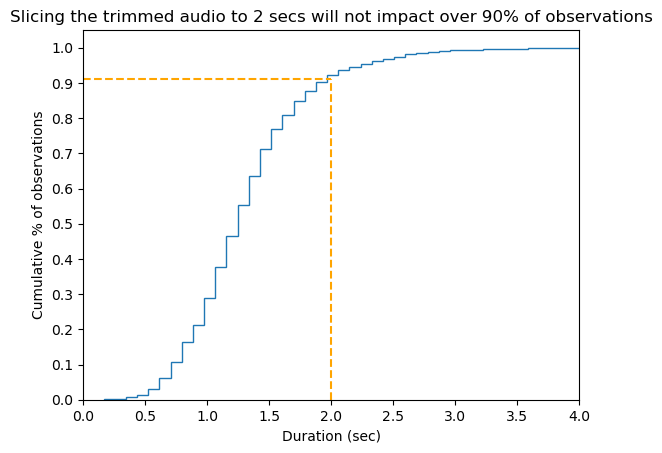

In [39]:
plt.figure()
plt.hist(df['trimmed_duration_sec'],bins=50,density=True, histtype='step',
                           cumulative=True)
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.xlim(0,4)
plt.vlines(x=2,ymin=0,ymax=(df['trimmed_duration_sec'] < 2).sum() / len(df['trimmed_duration_sec']),linestyles = '--',color='orange')
plt.hlines(y=(df['trimmed_duration_sec'] < 2).sum() / len(df['trimmed_duration_sec']),xmin=0,xmax=2,linestyles = '--',color='orange')
plt.xlabel('Duration (sec)')
plt.ylabel('Cumulative % of observations')
plt.title('Slicing the trimmed audio to 2 secs will not impact over 90% of observations')
plt.show()

While our longest audio clip is 4.67 seconds, over 90% of audio clips are less than 2 seconds in duration. In order to reduce file size and accelrate model fitting times, we alter all trimmed audio arrays to be 2 seconds in length.

In [40]:
# alter all arrays to have a length of 2 seconds time a sample rate of 22050Hz
X_train_altered_audio_list = fix_length_1D(X_train_trimmed_audio_list,2*22050)
X_test_altered_audio_list = fix_length_1D(X_test_trimmed_audio_list,2*22050)

In [41]:
# Let's check the lengths now
print('X_train\n----------')
dims_1D(X_train_altered_audio_list)
print('\nX_test\n----------')
dims_1D(X_test_altered_audio_list)

X_train
----------
min length: 44100
max length: 44100
min duration: 2.00 seconds
max duration: 2.00 seconds

X_test
----------
min length: 44100
max length: 44100
min duration: 2.00 seconds
max duration: 2.00 seconds


(44100, 44100)

All lengths are now the same.

#### Create a downsampled version of the two audio lists where sample rate is reduced from 22,050Hz to 8kHz

In [42]:
%%time

# initialize a list to hold the downsampled audio files
X_test_8k_audio_list = []

# initialize a progress counter
counter = 0

# iterate over our list of padded audio files
for audio in X_test_altered_audio_list:
    counter += 1
    print(f'Downsampling file {counter} of {len(X_test_altered_audio_list)}')
    # resample the audio files and append to a list
    X_test_8k_audio_list.append(librosa.resample(y=audio, orig_sr=22050, target_sr=8000))

Downsampling file 1 of 1699
Downsampling file 2 of 1699
Downsampling file 3 of 1699
Downsampling file 4 of 1699
Downsampling file 5 of 1699
Downsampling file 6 of 1699
Downsampling file 7 of 1699
Downsampling file 8 of 1699
Downsampling file 9 of 1699
Downsampling file 10 of 1699
Downsampling file 11 of 1699
Downsampling file 12 of 1699
Downsampling file 13 of 1699
Downsampling file 14 of 1699
Downsampling file 15 of 1699
Downsampling file 16 of 1699
Downsampling file 17 of 1699
Downsampling file 18 of 1699
Downsampling file 19 of 1699
Downsampling file 20 of 1699
Downsampling file 21 of 1699
Downsampling file 22 of 1699
Downsampling file 23 of 1699
Downsampling file 24 of 1699
Downsampling file 25 of 1699
Downsampling file 26 of 1699
Downsampling file 27 of 1699
Downsampling file 28 of 1699
Downsampling file 29 of 1699
Downsampling file 30 of 1699
Downsampling file 31 of 1699
Downsampling file 32 of 1699
Downsampling file 33 of 1699
Downsampling file 34 of 1699
Downsampling file 35 of

Downsampling file 278 of 1699
Downsampling file 279 of 1699
Downsampling file 280 of 1699
Downsampling file 281 of 1699
Downsampling file 282 of 1699
Downsampling file 283 of 1699
Downsampling file 284 of 1699
Downsampling file 285 of 1699
Downsampling file 286 of 1699
Downsampling file 287 of 1699
Downsampling file 288 of 1699
Downsampling file 289 of 1699
Downsampling file 290 of 1699
Downsampling file 291 of 1699
Downsampling file 292 of 1699
Downsampling file 293 of 1699
Downsampling file 294 of 1699
Downsampling file 295 of 1699
Downsampling file 296 of 1699
Downsampling file 297 of 1699
Downsampling file 298 of 1699
Downsampling file 299 of 1699
Downsampling file 300 of 1699
Downsampling file 301 of 1699
Downsampling file 302 of 1699
Downsampling file 303 of 1699
Downsampling file 304 of 1699
Downsampling file 305 of 1699
Downsampling file 306 of 1699
Downsampling file 307 of 1699
Downsampling file 308 of 1699
Downsampling file 309 of 1699
Downsampling file 310 of 1699
Downsampli

Downsampling file 554 of 1699
Downsampling file 555 of 1699
Downsampling file 556 of 1699
Downsampling file 557 of 1699
Downsampling file 558 of 1699
Downsampling file 559 of 1699
Downsampling file 560 of 1699
Downsampling file 561 of 1699
Downsampling file 562 of 1699
Downsampling file 563 of 1699
Downsampling file 564 of 1699
Downsampling file 565 of 1699
Downsampling file 566 of 1699
Downsampling file 567 of 1699
Downsampling file 568 of 1699
Downsampling file 569 of 1699
Downsampling file 570 of 1699
Downsampling file 571 of 1699
Downsampling file 572 of 1699
Downsampling file 573 of 1699
Downsampling file 574 of 1699
Downsampling file 575 of 1699
Downsampling file 576 of 1699
Downsampling file 577 of 1699
Downsampling file 578 of 1699
Downsampling file 579 of 1699
Downsampling file 580 of 1699
Downsampling file 581 of 1699
Downsampling file 582 of 1699
Downsampling file 583 of 1699
Downsampling file 584 of 1699
Downsampling file 585 of 1699
Downsampling file 586 of 1699
Downsampli

Downsampling file 830 of 1699
Downsampling file 831 of 1699
Downsampling file 832 of 1699
Downsampling file 833 of 1699
Downsampling file 834 of 1699
Downsampling file 835 of 1699
Downsampling file 836 of 1699
Downsampling file 837 of 1699
Downsampling file 838 of 1699
Downsampling file 839 of 1699
Downsampling file 840 of 1699
Downsampling file 841 of 1699
Downsampling file 842 of 1699
Downsampling file 843 of 1699
Downsampling file 844 of 1699
Downsampling file 845 of 1699
Downsampling file 846 of 1699
Downsampling file 847 of 1699
Downsampling file 848 of 1699
Downsampling file 849 of 1699
Downsampling file 850 of 1699
Downsampling file 851 of 1699
Downsampling file 852 of 1699
Downsampling file 853 of 1699
Downsampling file 854 of 1699
Downsampling file 855 of 1699
Downsampling file 856 of 1699
Downsampling file 857 of 1699
Downsampling file 858 of 1699
Downsampling file 859 of 1699
Downsampling file 860 of 1699
Downsampling file 861 of 1699
Downsampling file 862 of 1699
Downsampli

Downsampling file 1101 of 1699
Downsampling file 1102 of 1699
Downsampling file 1103 of 1699
Downsampling file 1104 of 1699
Downsampling file 1105 of 1699
Downsampling file 1106 of 1699
Downsampling file 1107 of 1699
Downsampling file 1108 of 1699
Downsampling file 1109 of 1699
Downsampling file 1110 of 1699
Downsampling file 1111 of 1699
Downsampling file 1112 of 1699
Downsampling file 1113 of 1699
Downsampling file 1114 of 1699
Downsampling file 1115 of 1699
Downsampling file 1116 of 1699
Downsampling file 1117 of 1699
Downsampling file 1118 of 1699
Downsampling file 1119 of 1699
Downsampling file 1120 of 1699
Downsampling file 1121 of 1699
Downsampling file 1122 of 1699
Downsampling file 1123 of 1699
Downsampling file 1124 of 1699
Downsampling file 1125 of 1699
Downsampling file 1126 of 1699
Downsampling file 1127 of 1699
Downsampling file 1128 of 1699
Downsampling file 1129 of 1699
Downsampling file 1130 of 1699
Downsampling file 1131 of 1699
Downsampling file 1132 of 1699
Downsamp

Downsampling file 1366 of 1699
Downsampling file 1367 of 1699
Downsampling file 1368 of 1699
Downsampling file 1369 of 1699
Downsampling file 1370 of 1699
Downsampling file 1371 of 1699
Downsampling file 1372 of 1699
Downsampling file 1373 of 1699
Downsampling file 1374 of 1699
Downsampling file 1375 of 1699
Downsampling file 1376 of 1699
Downsampling file 1377 of 1699
Downsampling file 1378 of 1699
Downsampling file 1379 of 1699
Downsampling file 1380 of 1699
Downsampling file 1381 of 1699
Downsampling file 1382 of 1699
Downsampling file 1383 of 1699
Downsampling file 1384 of 1699
Downsampling file 1385 of 1699
Downsampling file 1386 of 1699
Downsampling file 1387 of 1699
Downsampling file 1388 of 1699
Downsampling file 1389 of 1699
Downsampling file 1390 of 1699
Downsampling file 1391 of 1699
Downsampling file 1392 of 1699
Downsampling file 1393 of 1699
Downsampling file 1394 of 1699
Downsampling file 1395 of 1699
Downsampling file 1396 of 1699
Downsampling file 1397 of 1699
Downsamp

Downsampling file 1635 of 1699
Downsampling file 1636 of 1699
Downsampling file 1637 of 1699
Downsampling file 1638 of 1699
Downsampling file 1639 of 1699
Downsampling file 1640 of 1699
Downsampling file 1641 of 1699
Downsampling file 1642 of 1699
Downsampling file 1643 of 1699
Downsampling file 1644 of 1699
Downsampling file 1645 of 1699
Downsampling file 1646 of 1699
Downsampling file 1647 of 1699
Downsampling file 1648 of 1699
Downsampling file 1649 of 1699
Downsampling file 1650 of 1699
Downsampling file 1651 of 1699
Downsampling file 1652 of 1699
Downsampling file 1653 of 1699
Downsampling file 1654 of 1699
Downsampling file 1655 of 1699
Downsampling file 1656 of 1699
Downsampling file 1657 of 1699
Downsampling file 1658 of 1699
Downsampling file 1659 of 1699
Downsampling file 1660 of 1699
Downsampling file 1661 of 1699
Downsampling file 1662 of 1699
Downsampling file 1663 of 1699
Downsampling file 1664 of 1699
Downsampling file 1665 of 1699
Downsampling file 1666 of 1699
Downsamp

In [43]:
%%time

# initialize a list to hold the downsampled audio files
X_train_8k_audio_list = []

# initialize a progress counter
counter = 0

# iterate over our list of padded audio files
for audio in X_train_altered_audio_list:
    counter += 1
    print(f'Downsampling file {counter} of {len(X_train_altered_audio_list)}')
    # resample the audio files and append to a list
    X_train_8k_audio_list.append(librosa.resample(y=audio, orig_sr=22050, target_sr=8000))

Downsampling file 1 of 6792
Downsampling file 2 of 6792
Downsampling file 3 of 6792
Downsampling file 4 of 6792
Downsampling file 5 of 6792
Downsampling file 6 of 6792
Downsampling file 7 of 6792
Downsampling file 8 of 6792
Downsampling file 9 of 6792
Downsampling file 10 of 6792
Downsampling file 11 of 6792
Downsampling file 12 of 6792
Downsampling file 13 of 6792
Downsampling file 14 of 6792
Downsampling file 15 of 6792
Downsampling file 16 of 6792
Downsampling file 17 of 6792
Downsampling file 18 of 6792
Downsampling file 19 of 6792
Downsampling file 20 of 6792
Downsampling file 21 of 6792
Downsampling file 22 of 6792
Downsampling file 23 of 6792
Downsampling file 24 of 6792
Downsampling file 25 of 6792
Downsampling file 26 of 6792
Downsampling file 27 of 6792
Downsampling file 28 of 6792
Downsampling file 29 of 6792
Downsampling file 30 of 6792
Downsampling file 31 of 6792
Downsampling file 32 of 6792
Downsampling file 33 of 6792
Downsampling file 34 of 6792
Downsampling file 35 of

Downsampling file 278 of 6792
Downsampling file 279 of 6792
Downsampling file 280 of 6792
Downsampling file 281 of 6792
Downsampling file 282 of 6792
Downsampling file 283 of 6792
Downsampling file 284 of 6792
Downsampling file 285 of 6792
Downsampling file 286 of 6792
Downsampling file 287 of 6792
Downsampling file 288 of 6792
Downsampling file 289 of 6792
Downsampling file 290 of 6792
Downsampling file 291 of 6792
Downsampling file 292 of 6792
Downsampling file 293 of 6792
Downsampling file 294 of 6792
Downsampling file 295 of 6792
Downsampling file 296 of 6792
Downsampling file 297 of 6792
Downsampling file 298 of 6792
Downsampling file 299 of 6792
Downsampling file 300 of 6792
Downsampling file 301 of 6792
Downsampling file 302 of 6792
Downsampling file 303 of 6792
Downsampling file 304 of 6792
Downsampling file 305 of 6792
Downsampling file 306 of 6792
Downsampling file 307 of 6792
Downsampling file 308 of 6792
Downsampling file 309 of 6792
Downsampling file 310 of 6792
Downsampli

Downsampling file 552 of 6792
Downsampling file 553 of 6792
Downsampling file 554 of 6792
Downsampling file 555 of 6792
Downsampling file 556 of 6792
Downsampling file 557 of 6792
Downsampling file 558 of 6792
Downsampling file 559 of 6792
Downsampling file 560 of 6792
Downsampling file 561 of 6792
Downsampling file 562 of 6792
Downsampling file 563 of 6792
Downsampling file 564 of 6792
Downsampling file 565 of 6792
Downsampling file 566 of 6792
Downsampling file 567 of 6792
Downsampling file 568 of 6792
Downsampling file 569 of 6792
Downsampling file 570 of 6792
Downsampling file 571 of 6792
Downsampling file 572 of 6792
Downsampling file 573 of 6792
Downsampling file 574 of 6792
Downsampling file 575 of 6792
Downsampling file 576 of 6792
Downsampling file 577 of 6792
Downsampling file 578 of 6792
Downsampling file 579 of 6792
Downsampling file 580 of 6792
Downsampling file 581 of 6792
Downsampling file 582 of 6792
Downsampling file 583 of 6792
Downsampling file 584 of 6792
Downsampli

Downsampling file 829 of 6792
Downsampling file 830 of 6792
Downsampling file 831 of 6792
Downsampling file 832 of 6792
Downsampling file 833 of 6792
Downsampling file 834 of 6792
Downsampling file 835 of 6792
Downsampling file 836 of 6792
Downsampling file 837 of 6792
Downsampling file 838 of 6792
Downsampling file 839 of 6792
Downsampling file 840 of 6792
Downsampling file 841 of 6792
Downsampling file 842 of 6792
Downsampling file 843 of 6792
Downsampling file 844 of 6792
Downsampling file 845 of 6792
Downsampling file 846 of 6792
Downsampling file 847 of 6792
Downsampling file 848 of 6792
Downsampling file 849 of 6792
Downsampling file 850 of 6792
Downsampling file 851 of 6792
Downsampling file 852 of 6792
Downsampling file 853 of 6792
Downsampling file 854 of 6792
Downsampling file 855 of 6792
Downsampling file 856 of 6792
Downsampling file 857 of 6792
Downsampling file 858 of 6792
Downsampling file 859 of 6792
Downsampling file 860 of 6792
Downsampling file 861 of 6792
Downsampli

Downsampling file 1099 of 6792
Downsampling file 1100 of 6792
Downsampling file 1101 of 6792
Downsampling file 1102 of 6792
Downsampling file 1103 of 6792
Downsampling file 1104 of 6792
Downsampling file 1105 of 6792
Downsampling file 1106 of 6792
Downsampling file 1107 of 6792
Downsampling file 1108 of 6792
Downsampling file 1109 of 6792
Downsampling file 1110 of 6792
Downsampling file 1111 of 6792
Downsampling file 1112 of 6792
Downsampling file 1113 of 6792
Downsampling file 1114 of 6792
Downsampling file 1115 of 6792
Downsampling file 1116 of 6792
Downsampling file 1117 of 6792
Downsampling file 1118 of 6792
Downsampling file 1119 of 6792
Downsampling file 1120 of 6792
Downsampling file 1121 of 6792
Downsampling file 1122 of 6792
Downsampling file 1123 of 6792
Downsampling file 1124 of 6792
Downsampling file 1125 of 6792
Downsampling file 1126 of 6792
Downsampling file 1127 of 6792
Downsampling file 1128 of 6792
Downsampling file 1129 of 6792
Downsampling file 1130 of 6792
Downsamp

Downsampling file 1368 of 6792
Downsampling file 1369 of 6792
Downsampling file 1370 of 6792
Downsampling file 1371 of 6792
Downsampling file 1372 of 6792
Downsampling file 1373 of 6792
Downsampling file 1374 of 6792
Downsampling file 1375 of 6792
Downsampling file 1376 of 6792
Downsampling file 1377 of 6792
Downsampling file 1378 of 6792
Downsampling file 1379 of 6792
Downsampling file 1380 of 6792
Downsampling file 1381 of 6792
Downsampling file 1382 of 6792
Downsampling file 1383 of 6792
Downsampling file 1384 of 6792
Downsampling file 1385 of 6792
Downsampling file 1386 of 6792
Downsampling file 1387 of 6792
Downsampling file 1388 of 6792
Downsampling file 1389 of 6792
Downsampling file 1390 of 6792
Downsampling file 1391 of 6792
Downsampling file 1392 of 6792
Downsampling file 1393 of 6792
Downsampling file 1394 of 6792
Downsampling file 1395 of 6792
Downsampling file 1396 of 6792
Downsampling file 1397 of 6792
Downsampling file 1398 of 6792
Downsampling file 1399 of 6792
Downsamp

Downsampling file 1635 of 6792
Downsampling file 1636 of 6792
Downsampling file 1637 of 6792
Downsampling file 1638 of 6792
Downsampling file 1639 of 6792
Downsampling file 1640 of 6792
Downsampling file 1641 of 6792
Downsampling file 1642 of 6792
Downsampling file 1643 of 6792
Downsampling file 1644 of 6792
Downsampling file 1645 of 6792
Downsampling file 1646 of 6792
Downsampling file 1647 of 6792
Downsampling file 1648 of 6792
Downsampling file 1649 of 6792
Downsampling file 1650 of 6792
Downsampling file 1651 of 6792
Downsampling file 1652 of 6792
Downsampling file 1653 of 6792
Downsampling file 1654 of 6792
Downsampling file 1655 of 6792
Downsampling file 1656 of 6792
Downsampling file 1657 of 6792
Downsampling file 1658 of 6792
Downsampling file 1659 of 6792
Downsampling file 1660 of 6792
Downsampling file 1661 of 6792
Downsampling file 1662 of 6792
Downsampling file 1663 of 6792
Downsampling file 1664 of 6792
Downsampling file 1665 of 6792
Downsampling file 1666 of 6792
Downsamp

Downsampling file 1900 of 6792
Downsampling file 1901 of 6792
Downsampling file 1902 of 6792
Downsampling file 1903 of 6792
Downsampling file 1904 of 6792
Downsampling file 1905 of 6792
Downsampling file 1906 of 6792
Downsampling file 1907 of 6792
Downsampling file 1908 of 6792
Downsampling file 1909 of 6792
Downsampling file 1910 of 6792
Downsampling file 1911 of 6792
Downsampling file 1912 of 6792
Downsampling file 1913 of 6792
Downsampling file 1914 of 6792
Downsampling file 1915 of 6792
Downsampling file 1916 of 6792
Downsampling file 1917 of 6792
Downsampling file 1918 of 6792
Downsampling file 1919 of 6792
Downsampling file 1920 of 6792
Downsampling file 1921 of 6792
Downsampling file 1922 of 6792
Downsampling file 1923 of 6792
Downsampling file 1924 of 6792
Downsampling file 1925 of 6792
Downsampling file 1926 of 6792
Downsampling file 1927 of 6792
Downsampling file 1928 of 6792
Downsampling file 1929 of 6792
Downsampling file 1930 of 6792
Downsampling file 1931 of 6792
Downsamp

Downsampling file 2165 of 6792
Downsampling file 2166 of 6792
Downsampling file 2167 of 6792
Downsampling file 2168 of 6792
Downsampling file 2169 of 6792
Downsampling file 2170 of 6792
Downsampling file 2171 of 6792
Downsampling file 2172 of 6792
Downsampling file 2173 of 6792
Downsampling file 2174 of 6792
Downsampling file 2175 of 6792
Downsampling file 2176 of 6792
Downsampling file 2177 of 6792
Downsampling file 2178 of 6792
Downsampling file 2179 of 6792
Downsampling file 2180 of 6792
Downsampling file 2181 of 6792
Downsampling file 2182 of 6792
Downsampling file 2183 of 6792
Downsampling file 2184 of 6792
Downsampling file 2185 of 6792
Downsampling file 2186 of 6792
Downsampling file 2187 of 6792
Downsampling file 2188 of 6792
Downsampling file 2189 of 6792
Downsampling file 2190 of 6792
Downsampling file 2191 of 6792
Downsampling file 2192 of 6792
Downsampling file 2193 of 6792
Downsampling file 2194 of 6792
Downsampling file 2195 of 6792
Downsampling file 2196 of 6792
Downsamp

Downsampling file 2430 of 6792
Downsampling file 2431 of 6792
Downsampling file 2432 of 6792
Downsampling file 2433 of 6792
Downsampling file 2434 of 6792
Downsampling file 2435 of 6792
Downsampling file 2436 of 6792
Downsampling file 2437 of 6792
Downsampling file 2438 of 6792
Downsampling file 2439 of 6792
Downsampling file 2440 of 6792
Downsampling file 2441 of 6792
Downsampling file 2442 of 6792
Downsampling file 2443 of 6792
Downsampling file 2444 of 6792
Downsampling file 2445 of 6792
Downsampling file 2446 of 6792
Downsampling file 2447 of 6792
Downsampling file 2448 of 6792
Downsampling file 2449 of 6792
Downsampling file 2450 of 6792
Downsampling file 2451 of 6792
Downsampling file 2452 of 6792
Downsampling file 2453 of 6792
Downsampling file 2454 of 6792
Downsampling file 2455 of 6792
Downsampling file 2456 of 6792
Downsampling file 2457 of 6792
Downsampling file 2458 of 6792
Downsampling file 2459 of 6792
Downsampling file 2460 of 6792
Downsampling file 2461 of 6792
Downsamp

Downsampling file 2696 of 6792
Downsampling file 2697 of 6792
Downsampling file 2698 of 6792
Downsampling file 2699 of 6792
Downsampling file 2700 of 6792
Downsampling file 2701 of 6792
Downsampling file 2702 of 6792
Downsampling file 2703 of 6792
Downsampling file 2704 of 6792
Downsampling file 2705 of 6792
Downsampling file 2706 of 6792
Downsampling file 2707 of 6792
Downsampling file 2708 of 6792
Downsampling file 2709 of 6792
Downsampling file 2710 of 6792
Downsampling file 2711 of 6792
Downsampling file 2712 of 6792
Downsampling file 2713 of 6792
Downsampling file 2714 of 6792
Downsampling file 2715 of 6792
Downsampling file 2716 of 6792
Downsampling file 2717 of 6792
Downsampling file 2718 of 6792
Downsampling file 2719 of 6792
Downsampling file 2720 of 6792
Downsampling file 2721 of 6792
Downsampling file 2722 of 6792
Downsampling file 2723 of 6792
Downsampling file 2724 of 6792
Downsampling file 2725 of 6792
Downsampling file 2726 of 6792
Downsampling file 2727 of 6792
Downsamp

Downsampling file 2961 of 6792
Downsampling file 2962 of 6792
Downsampling file 2963 of 6792
Downsampling file 2964 of 6792
Downsampling file 2965 of 6792
Downsampling file 2966 of 6792
Downsampling file 2967 of 6792
Downsampling file 2968 of 6792
Downsampling file 2969 of 6792
Downsampling file 2970 of 6792
Downsampling file 2971 of 6792
Downsampling file 2972 of 6792
Downsampling file 2973 of 6792
Downsampling file 2974 of 6792
Downsampling file 2975 of 6792
Downsampling file 2976 of 6792
Downsampling file 2977 of 6792
Downsampling file 2978 of 6792
Downsampling file 2979 of 6792
Downsampling file 2980 of 6792
Downsampling file 2981 of 6792
Downsampling file 2982 of 6792
Downsampling file 2983 of 6792
Downsampling file 2984 of 6792
Downsampling file 2985 of 6792
Downsampling file 2986 of 6792
Downsampling file 2987 of 6792
Downsampling file 2988 of 6792
Downsampling file 2989 of 6792
Downsampling file 2990 of 6792
Downsampling file 2991 of 6792
Downsampling file 2992 of 6792
Downsamp

Downsampling file 3229 of 6792
Downsampling file 3230 of 6792
Downsampling file 3231 of 6792
Downsampling file 3232 of 6792
Downsampling file 3233 of 6792
Downsampling file 3234 of 6792
Downsampling file 3235 of 6792
Downsampling file 3236 of 6792
Downsampling file 3237 of 6792
Downsampling file 3238 of 6792
Downsampling file 3239 of 6792
Downsampling file 3240 of 6792
Downsampling file 3241 of 6792
Downsampling file 3242 of 6792
Downsampling file 3243 of 6792
Downsampling file 3244 of 6792
Downsampling file 3245 of 6792
Downsampling file 3246 of 6792
Downsampling file 3247 of 6792
Downsampling file 3248 of 6792
Downsampling file 3249 of 6792
Downsampling file 3250 of 6792
Downsampling file 3251 of 6792
Downsampling file 3252 of 6792
Downsampling file 3253 of 6792
Downsampling file 3254 of 6792
Downsampling file 3255 of 6792
Downsampling file 3256 of 6792
Downsampling file 3257 of 6792
Downsampling file 3258 of 6792
Downsampling file 3259 of 6792
Downsampling file 3260 of 6792
Downsamp

Downsampling file 3495 of 6792
Downsampling file 3496 of 6792
Downsampling file 3497 of 6792
Downsampling file 3498 of 6792
Downsampling file 3499 of 6792
Downsampling file 3500 of 6792
Downsampling file 3501 of 6792
Downsampling file 3502 of 6792
Downsampling file 3503 of 6792
Downsampling file 3504 of 6792
Downsampling file 3505 of 6792
Downsampling file 3506 of 6792
Downsampling file 3507 of 6792
Downsampling file 3508 of 6792
Downsampling file 3509 of 6792
Downsampling file 3510 of 6792
Downsampling file 3511 of 6792
Downsampling file 3512 of 6792
Downsampling file 3513 of 6792
Downsampling file 3514 of 6792
Downsampling file 3515 of 6792
Downsampling file 3516 of 6792
Downsampling file 3517 of 6792
Downsampling file 3518 of 6792
Downsampling file 3519 of 6792
Downsampling file 3520 of 6792
Downsampling file 3521 of 6792
Downsampling file 3522 of 6792
Downsampling file 3523 of 6792
Downsampling file 3524 of 6792
Downsampling file 3525 of 6792
Downsampling file 3526 of 6792
Downsamp

Downsampling file 3761 of 6792
Downsampling file 3762 of 6792
Downsampling file 3763 of 6792
Downsampling file 3764 of 6792
Downsampling file 3765 of 6792
Downsampling file 3766 of 6792
Downsampling file 3767 of 6792
Downsampling file 3768 of 6792
Downsampling file 3769 of 6792
Downsampling file 3770 of 6792
Downsampling file 3771 of 6792
Downsampling file 3772 of 6792
Downsampling file 3773 of 6792
Downsampling file 3774 of 6792
Downsampling file 3775 of 6792
Downsampling file 3776 of 6792
Downsampling file 3777 of 6792
Downsampling file 3778 of 6792
Downsampling file 3779 of 6792
Downsampling file 3780 of 6792
Downsampling file 3781 of 6792
Downsampling file 3782 of 6792
Downsampling file 3783 of 6792
Downsampling file 3784 of 6792
Downsampling file 3785 of 6792
Downsampling file 3786 of 6792
Downsampling file 3787 of 6792
Downsampling file 3788 of 6792
Downsampling file 3789 of 6792
Downsampling file 3790 of 6792
Downsampling file 3791 of 6792
Downsampling file 3792 of 6792
Downsamp

Downsampling file 4029 of 6792
Downsampling file 4030 of 6792
Downsampling file 4031 of 6792
Downsampling file 4032 of 6792
Downsampling file 4033 of 6792
Downsampling file 4034 of 6792
Downsampling file 4035 of 6792
Downsampling file 4036 of 6792
Downsampling file 4037 of 6792
Downsampling file 4038 of 6792
Downsampling file 4039 of 6792
Downsampling file 4040 of 6792
Downsampling file 4041 of 6792
Downsampling file 4042 of 6792
Downsampling file 4043 of 6792
Downsampling file 4044 of 6792
Downsampling file 4045 of 6792
Downsampling file 4046 of 6792
Downsampling file 4047 of 6792
Downsampling file 4048 of 6792
Downsampling file 4049 of 6792
Downsampling file 4050 of 6792
Downsampling file 4051 of 6792
Downsampling file 4052 of 6792
Downsampling file 4053 of 6792
Downsampling file 4054 of 6792
Downsampling file 4055 of 6792
Downsampling file 4056 of 6792
Downsampling file 4057 of 6792
Downsampling file 4058 of 6792
Downsampling file 4059 of 6792
Downsampling file 4060 of 6792
Downsamp

Downsampling file 4294 of 6792
Downsampling file 4295 of 6792
Downsampling file 4296 of 6792
Downsampling file 4297 of 6792
Downsampling file 4298 of 6792
Downsampling file 4299 of 6792
Downsampling file 4300 of 6792
Downsampling file 4301 of 6792
Downsampling file 4302 of 6792
Downsampling file 4303 of 6792
Downsampling file 4304 of 6792
Downsampling file 4305 of 6792
Downsampling file 4306 of 6792
Downsampling file 4307 of 6792
Downsampling file 4308 of 6792
Downsampling file 4309 of 6792
Downsampling file 4310 of 6792
Downsampling file 4311 of 6792
Downsampling file 4312 of 6792
Downsampling file 4313 of 6792
Downsampling file 4314 of 6792
Downsampling file 4315 of 6792
Downsampling file 4316 of 6792
Downsampling file 4317 of 6792
Downsampling file 4318 of 6792
Downsampling file 4319 of 6792
Downsampling file 4320 of 6792
Downsampling file 4321 of 6792
Downsampling file 4322 of 6792
Downsampling file 4323 of 6792
Downsampling file 4324 of 6792
Downsampling file 4325 of 6792
Downsamp

Downsampling file 4561 of 6792
Downsampling file 4562 of 6792
Downsampling file 4563 of 6792
Downsampling file 4564 of 6792
Downsampling file 4565 of 6792
Downsampling file 4566 of 6792
Downsampling file 4567 of 6792
Downsampling file 4568 of 6792
Downsampling file 4569 of 6792
Downsampling file 4570 of 6792
Downsampling file 4571 of 6792
Downsampling file 4572 of 6792
Downsampling file 4573 of 6792
Downsampling file 4574 of 6792
Downsampling file 4575 of 6792
Downsampling file 4576 of 6792
Downsampling file 4577 of 6792
Downsampling file 4578 of 6792
Downsampling file 4579 of 6792
Downsampling file 4580 of 6792
Downsampling file 4581 of 6792
Downsampling file 4582 of 6792
Downsampling file 4583 of 6792
Downsampling file 4584 of 6792
Downsampling file 4585 of 6792
Downsampling file 4586 of 6792
Downsampling file 4587 of 6792
Downsampling file 4588 of 6792
Downsampling file 4589 of 6792
Downsampling file 4590 of 6792
Downsampling file 4591 of 6792
Downsampling file 4592 of 6792
Downsamp

Downsampling file 4826 of 6792
Downsampling file 4827 of 6792
Downsampling file 4828 of 6792
Downsampling file 4829 of 6792
Downsampling file 4830 of 6792
Downsampling file 4831 of 6792
Downsampling file 4832 of 6792
Downsampling file 4833 of 6792
Downsampling file 4834 of 6792
Downsampling file 4835 of 6792
Downsampling file 4836 of 6792
Downsampling file 4837 of 6792
Downsampling file 4838 of 6792
Downsampling file 4839 of 6792
Downsampling file 4840 of 6792
Downsampling file 4841 of 6792
Downsampling file 4842 of 6792
Downsampling file 4843 of 6792
Downsampling file 4844 of 6792
Downsampling file 4845 of 6792
Downsampling file 4846 of 6792
Downsampling file 4847 of 6792
Downsampling file 4848 of 6792
Downsampling file 4849 of 6792
Downsampling file 4850 of 6792
Downsampling file 4851 of 6792
Downsampling file 4852 of 6792
Downsampling file 4853 of 6792
Downsampling file 4854 of 6792
Downsampling file 4855 of 6792
Downsampling file 4856 of 6792
Downsampling file 4857 of 6792
Downsamp

Downsampling file 5093 of 6792
Downsampling file 5094 of 6792
Downsampling file 5095 of 6792
Downsampling file 5096 of 6792
Downsampling file 5097 of 6792
Downsampling file 5098 of 6792
Downsampling file 5099 of 6792
Downsampling file 5100 of 6792
Downsampling file 5101 of 6792
Downsampling file 5102 of 6792
Downsampling file 5103 of 6792
Downsampling file 5104 of 6792
Downsampling file 5105 of 6792
Downsampling file 5106 of 6792
Downsampling file 5107 of 6792
Downsampling file 5108 of 6792
Downsampling file 5109 of 6792
Downsampling file 5110 of 6792
Downsampling file 5111 of 6792
Downsampling file 5112 of 6792
Downsampling file 5113 of 6792
Downsampling file 5114 of 6792
Downsampling file 5115 of 6792
Downsampling file 5116 of 6792
Downsampling file 5117 of 6792
Downsampling file 5118 of 6792
Downsampling file 5119 of 6792
Downsampling file 5120 of 6792
Downsampling file 5121 of 6792
Downsampling file 5122 of 6792
Downsampling file 5123 of 6792
Downsampling file 5124 of 6792
Downsamp

Downsampling file 5362 of 6792
Downsampling file 5363 of 6792
Downsampling file 5364 of 6792
Downsampling file 5365 of 6792
Downsampling file 5366 of 6792
Downsampling file 5367 of 6792
Downsampling file 5368 of 6792
Downsampling file 5369 of 6792
Downsampling file 5370 of 6792
Downsampling file 5371 of 6792
Downsampling file 5372 of 6792
Downsampling file 5373 of 6792
Downsampling file 5374 of 6792
Downsampling file 5375 of 6792
Downsampling file 5376 of 6792
Downsampling file 5377 of 6792
Downsampling file 5378 of 6792
Downsampling file 5379 of 6792
Downsampling file 5380 of 6792
Downsampling file 5381 of 6792
Downsampling file 5382 of 6792
Downsampling file 5383 of 6792
Downsampling file 5384 of 6792
Downsampling file 5385 of 6792
Downsampling file 5386 of 6792
Downsampling file 5387 of 6792
Downsampling file 5388 of 6792
Downsampling file 5389 of 6792
Downsampling file 5390 of 6792
Downsampling file 5391 of 6792
Downsampling file 5392 of 6792
Downsampling file 5393 of 6792
Downsamp

Downsampling file 5628 of 6792
Downsampling file 5629 of 6792
Downsampling file 5630 of 6792
Downsampling file 5631 of 6792
Downsampling file 5632 of 6792
Downsampling file 5633 of 6792
Downsampling file 5634 of 6792
Downsampling file 5635 of 6792
Downsampling file 5636 of 6792
Downsampling file 5637 of 6792
Downsampling file 5638 of 6792
Downsampling file 5639 of 6792
Downsampling file 5640 of 6792
Downsampling file 5641 of 6792
Downsampling file 5642 of 6792
Downsampling file 5643 of 6792
Downsampling file 5644 of 6792
Downsampling file 5645 of 6792
Downsampling file 5646 of 6792
Downsampling file 5647 of 6792
Downsampling file 5648 of 6792
Downsampling file 5649 of 6792
Downsampling file 5650 of 6792
Downsampling file 5651 of 6792
Downsampling file 5652 of 6792
Downsampling file 5653 of 6792
Downsampling file 5654 of 6792
Downsampling file 5655 of 6792
Downsampling file 5656 of 6792
Downsampling file 5657 of 6792
Downsampling file 5658 of 6792
Downsampling file 5659 of 6792
Downsamp

Downsampling file 5893 of 6792
Downsampling file 5894 of 6792
Downsampling file 5895 of 6792
Downsampling file 5896 of 6792
Downsampling file 5897 of 6792
Downsampling file 5898 of 6792
Downsampling file 5899 of 6792
Downsampling file 5900 of 6792
Downsampling file 5901 of 6792
Downsampling file 5902 of 6792
Downsampling file 5903 of 6792
Downsampling file 5904 of 6792
Downsampling file 5905 of 6792
Downsampling file 5906 of 6792
Downsampling file 5907 of 6792
Downsampling file 5908 of 6792
Downsampling file 5909 of 6792
Downsampling file 5910 of 6792
Downsampling file 5911 of 6792
Downsampling file 5912 of 6792
Downsampling file 5913 of 6792
Downsampling file 5914 of 6792
Downsampling file 5915 of 6792
Downsampling file 5916 of 6792
Downsampling file 5917 of 6792
Downsampling file 5918 of 6792
Downsampling file 5919 of 6792
Downsampling file 5920 of 6792
Downsampling file 5921 of 6792
Downsampling file 5922 of 6792
Downsampling file 5923 of 6792
Downsampling file 5924 of 6792
Downsamp

Downsampling file 6161 of 6792
Downsampling file 6162 of 6792
Downsampling file 6163 of 6792
Downsampling file 6164 of 6792
Downsampling file 6165 of 6792
Downsampling file 6166 of 6792
Downsampling file 6167 of 6792
Downsampling file 6168 of 6792
Downsampling file 6169 of 6792
Downsampling file 6170 of 6792
Downsampling file 6171 of 6792
Downsampling file 6172 of 6792
Downsampling file 6173 of 6792
Downsampling file 6174 of 6792
Downsampling file 6175 of 6792
Downsampling file 6176 of 6792
Downsampling file 6177 of 6792
Downsampling file 6178 of 6792
Downsampling file 6179 of 6792
Downsampling file 6180 of 6792
Downsampling file 6181 of 6792
Downsampling file 6182 of 6792
Downsampling file 6183 of 6792
Downsampling file 6184 of 6792
Downsampling file 6185 of 6792
Downsampling file 6186 of 6792
Downsampling file 6187 of 6792
Downsampling file 6188 of 6792
Downsampling file 6189 of 6792
Downsampling file 6190 of 6792
Downsampling file 6191 of 6792
Downsampling file 6192 of 6792
Downsamp

Downsampling file 6429 of 6792
Downsampling file 6430 of 6792
Downsampling file 6431 of 6792
Downsampling file 6432 of 6792
Downsampling file 6433 of 6792
Downsampling file 6434 of 6792
Downsampling file 6435 of 6792
Downsampling file 6436 of 6792
Downsampling file 6437 of 6792
Downsampling file 6438 of 6792
Downsampling file 6439 of 6792
Downsampling file 6440 of 6792
Downsampling file 6441 of 6792
Downsampling file 6442 of 6792
Downsampling file 6443 of 6792
Downsampling file 6444 of 6792
Downsampling file 6445 of 6792
Downsampling file 6446 of 6792
Downsampling file 6447 of 6792
Downsampling file 6448 of 6792
Downsampling file 6449 of 6792
Downsampling file 6450 of 6792
Downsampling file 6451 of 6792
Downsampling file 6452 of 6792
Downsampling file 6453 of 6792
Downsampling file 6454 of 6792
Downsampling file 6455 of 6792
Downsampling file 6456 of 6792
Downsampling file 6457 of 6792
Downsampling file 6458 of 6792
Downsampling file 6459 of 6792
Downsampling file 6460 of 6792
Downsamp

Downsampling file 6695 of 6792
Downsampling file 6696 of 6792
Downsampling file 6697 of 6792
Downsampling file 6698 of 6792
Downsampling file 6699 of 6792
Downsampling file 6700 of 6792
Downsampling file 6701 of 6792
Downsampling file 6702 of 6792
Downsampling file 6703 of 6792
Downsampling file 6704 of 6792
Downsampling file 6705 of 6792
Downsampling file 6706 of 6792
Downsampling file 6707 of 6792
Downsampling file 6708 of 6792
Downsampling file 6709 of 6792
Downsampling file 6710 of 6792
Downsampling file 6711 of 6792
Downsampling file 6712 of 6792
Downsampling file 6713 of 6792
Downsampling file 6714 of 6792
Downsampling file 6715 of 6792
Downsampling file 6716 of 6792
Downsampling file 6717 of 6792
Downsampling file 6718 of 6792
Downsampling file 6719 of 6792
Downsampling file 6720 of 6792
Downsampling file 6721 of 6792
Downsampling file 6722 of 6792
Downsampling file 6723 of 6792
Downsampling file 6724 of 6792
Downsampling file 6725 of 6792
Downsampling file 6726 of 6792
Downsamp

In [44]:
# Let's check the lengths now
print('X_train_8k\n----------')
dims_1D(X_train_8k_audio_list,sr=8000)
print('X_test_8k\n----------')
dims_1D(X_test_8k_audio_list,sr=8000)

X_train_8k
----------
min length: 16000
max length: 16000
min duration: 2.00 seconds
max duration: 2.00 seconds
X_test_8k
----------
min length: 16000
max length: 16000
min duration: 2.00 seconds
max duration: 2.00 seconds


(16000, 16000)

#### Save the lists as numpy arrays for use in Part_4 - Modeling

In [45]:
# transform the lists intro stacked arrays
X_train_1D_stack_array = np.stack(X_train_altered_audio_list,axis=0)
X_test_1D_stack_array = np.stack(X_test_altered_audio_list,axis=0)

In [46]:
# check the shapes of the stacked arrays
print(f'The X_train subset consists of {len(X_train)} observations.\n')
print('X_train array shape:\n--------')
print(X_train_1D_stack_array.shape)
print(f'\nThe X_test subset consists of {len(X_test)} observations.\n')
print('\nX_test shape:\n--------')
print(X_test_1D_stack_array.shape)

The X_train subset consists of 6792 observations.

X_train array shape:
--------
(6792, 44100)

The X_test subset consists of 1699 observations.


X_test shape:
--------
(1699, 44100)


Both arrays have shapes that align the appropriate number of observations and an appropriate number of samples for 2 seconds sampled as 22050Hz.

In [47]:
# transform the lists intro stacked arrays
X_train_1D_8k_stack_array = np.stack(X_train_8k_audio_list,axis=0)
X_test_1D_8k_stack_array = np.stack(X_test_8k_audio_list,axis=0)

In [48]:
# check the shapes of the stacked arrays
print(f'The X_train_8k subset consists of {len(X_train)} observations.\n')
print('X_train array shape:\n--------')
print(X_train_1D_8k_stack_array.shape)
print(f'\nThe X_test_8k subset consists of {len(X_test)} observations.\n')
print('\nX_test shape:\n--------')
print(X_test_1D_8k_stack_array.shape)

The X_train_8k subset consists of 6792 observations.

X_train array shape:
--------
(6792, 16000)

The X_test_8k subset consists of 1699 observations.


X_test shape:
--------
(1699, 16000)


In [49]:
# save the stacked arrays
np.save('extracted_features_for_modeling/X_train_1D_CNN.npy',X_train_1D_stack_array)
np.save('extracted_features_for_modeling/X_test_1D_CNN.npy',X_test_1D_stack_array)

In [50]:
np.save('extracted_features_for_modeling/X_train_1D_8k_CNN.npy',X_train_1D_8k_stack_array)
np.save('extracted_features_for_modeling/X_test_1D_8k_CNN.npy',X_test_1D_8k_stack_array)